# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics
We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to recover the primitive pressure from the conserved variables.

Use this first cell to convert this notebook to a python script.



1.   List item
2.   List item



In [ ]:
%%script echo skipping

!jupyter nbconvert pt7.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on google colab,

In [ ]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Constants and flags to set
Defining some constants and parameters for convenience.

In [ ]:

N_TRIALS = 500 # Number of trials for hyperparameter optimization
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.

# I try out here the values as obtained in Optuna run 5, but I will increase the number of epochs.
# N_LAYERS_NO_OPT = 3
# N_UNITS_NO_OPT = [78, 193, 99]
# HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
# OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
# LOSS_NAME_NO_OPT = "MSE"
# OPTIMIZER_NAME_NO_OPT = "Adam"
# LR_NO_OPT = 0.00036516467819506355
# BATCH_SIZE_NO_OPT = 170
# N_EPOCHS_NO_OPT = 400
# SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

# Dieselhorst hyperparameters
N_LAYERS_NO_OPT = 2
N_UNITS_NO_OPT = [600, 200]
HIDDEN_ACTIVATION_NAME_NO_OPT = "Sigmoid"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "MSE"
OPTIMIZER_NAME_NO_OPT = "Adam"
LR_NO_OPT = 6e-3
BATCH_SIZE_NO_OPT = 32
N_EPOCHS_NO_OPT = 400
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"


c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, 0.721 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

np.random.seed(21) # Uncomment for pseudorandom data.

## Generating the data

In [ ]:

# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon


# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, epsilon


# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    W = 1 / torch.sqrt(1 - vx ** 2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, tau

# Defining a function that generates input data (conserved variables) from given samples of primitive variables
def generate_input_data(rho, vx, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, tau = compute_conserved_variables(rho, vx, epsilon)

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
def generate_labels(rho, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p

Sampling the primitive variables using the sample_primitive_variables function

In [ ]:
rho_train, vx_train, epsilon_train = sample_primitive_variables(n_train_samples)
rho_test, vx_test, epsilon_test = sample_primitive_variables(n_test_samples)


In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

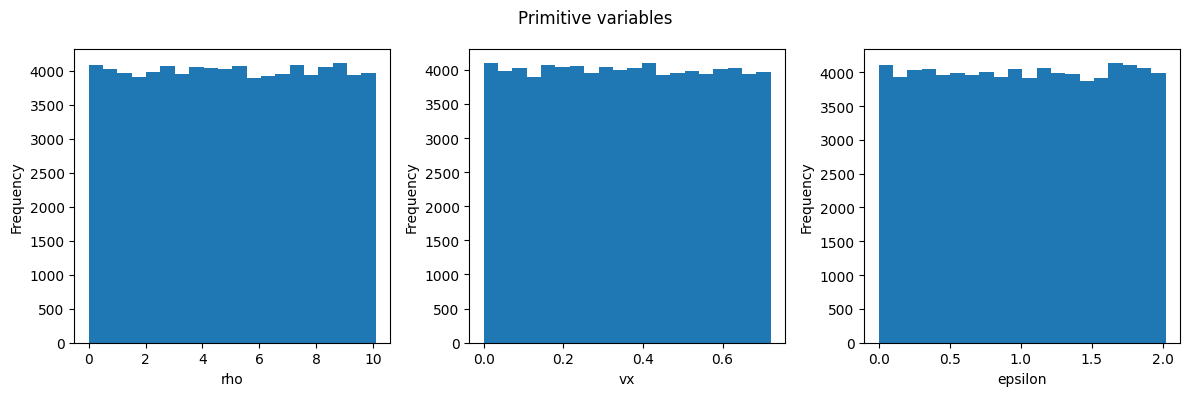

In [ ]:
# Plotting the histograms of rho, vx and epsilon
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(rho_train, bins=20)
plt.xlabel("rho")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(vx_train, bins=20)
plt.xlabel("vx")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(epsilon_train, bins=20)
plt.xlabel("epsilon")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.suptitle("Primitive variables")
plt.tight_layout()
plt.show()



In [ ]:

# Generating the input and output data for train and test sets.
x_train = generate_input_data(rho_train, vx_train, epsilon_train)
y_train = generate_labels(rho_train, epsilon_train) 
x_test = generate_input_data(rho_test, vx_test, epsilon_test) 
y_test = generate_labels(rho_test, epsilon_test) 


tensor([3.7986, 1.5258, 2.5252,  ..., 1.6261, 4.1954, 3.0668], device='cuda:0')

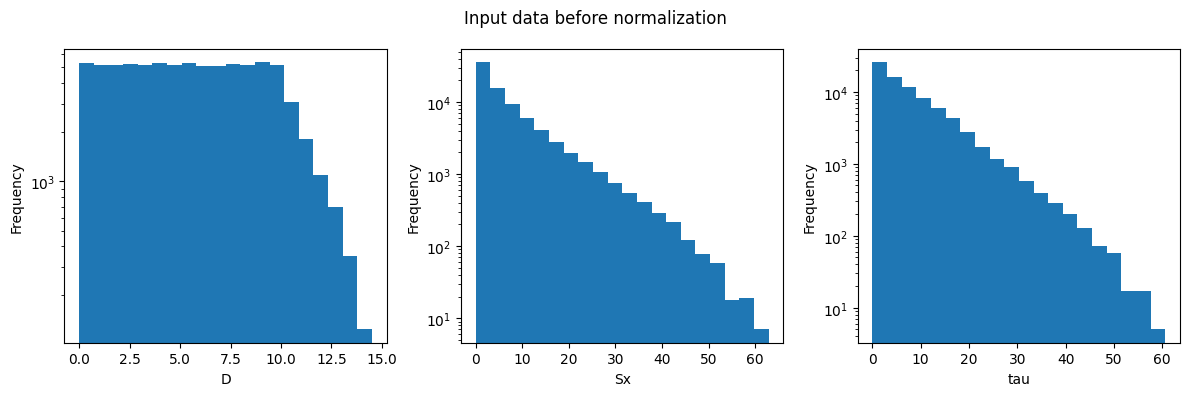

In [ ]:
# Plotting the histograms of the input data before normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data before normalization")
plt.tight_layout()
plt.show()


Perform z-score normalization

In [ ]:
if ZSCORE_NORMALIZATION:
    # Computing the mean and standard deviation of each input variable from the training set
    D_mean = torch.mean(x_train[:, 0])
    D_std = torch.std(x_train[:, 0])
    Sx_mean = torch.mean(x_train[:, 1])
    Sx_std = torch.std(x_train[:, 1])
    tau_mean = torch.mean(x_train[:, 2])
    tau_std = torch.std(x_train[:, 2])

    # Applying z-score normalization to both train and test sets using the statistics from the training set
    x_train[:, 0] = torch.sub(x_train[:, 0], D_mean).div(D_std)
    x_train[:, 1] = torch.sub(x_train[:, 1], Sx_mean).div(Sx_std)
    x_train[:, 2] = torch.sub(x_train[:, 2], tau_mean).div(tau_std)
    x_test[:, 0] = torch.sub(x_test[:, 0], D_mean).div(D_std)
    x_test[:, 1] = torch.sub(x_test[:, 1], Sx_mean).div(Sx_std)
    x_test[:, 2] = torch.sub(x_test[:, 2], tau_mean).div(tau_std)


tensor(5.6347, device='cuda:0')
tensor(3.3321, device='cuda:0')
tensor(6.8763, device='cuda:0')
tensor(8.1528, device='cuda:0')
tensor(8.0532, device='cuda:0')
tensor(7.8969, device='cuda:0')


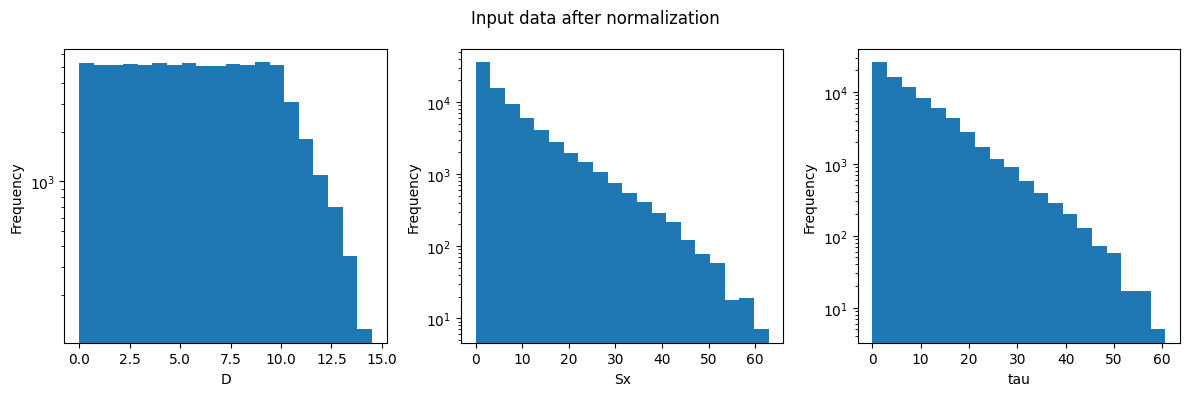

In [ ]:

# Verifying that the means and the stds of the input data are close to 0 and 1 respectively.
print(torch.mean(x_train[:, 0]))
print(torch.std(x_train[:, 0]))
print(torch.mean(x_train[:, 1]))
print(torch.std(x_train[:, 1]))
print(torch.mean(x_train[:, 2]))
print(torch.std(x_train[:, 2]))

# Plotting the histograms of the input data after normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data after normalization")
plt.tight_layout()
plt.show()


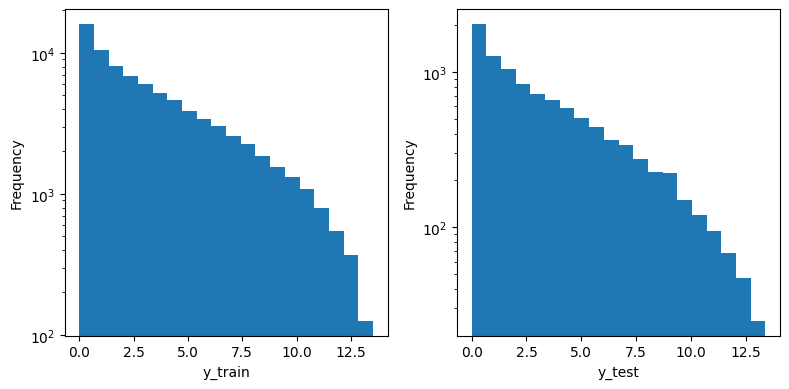

In [ ]:
# Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [ ]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(3, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x

## Defining the model and search space

In [ ]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if optimize:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 1, 5)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 1024) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
        )
        output_activation_name = trial.suggest_categorical(
            #"output_activation", ["Linear", "ReLU", "Softplus"]
            # Assuming pressure cannot be negative, linear output activation is not an option.
            "output_activation", ["ReLU", "Softplus"]
        ) 
        loss_name = trial.suggest_categorical(
            #"loss", ["MSE", "MAE", "Huber", "LogCosh"] 
            "loss", ["MSE", "MAE", "Huber"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 
        batch_size = trial.suggest_int("batch_size", 16, 1024)
        n_epochs = trial.suggest_int("n_epochs", 50, 200) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR"],
        )

    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Softplus":
        output_activation = nn.Softplus()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    if optimize:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            # Added sampling the weight decay and momentum for SGD
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            # Added sampling the weight decay and beta parameters for Adam
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
            beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            # Added sampling the step_size and gamma for StepLR
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.05, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            # Added sampling the gamma for ExponentialLR
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            # Added sampling the T_max for CosineAnnealingLR
            T_max = trial.suggest_int("T_max", 5, 15)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added sampling the factor, patience and threshold for ReduceLROnPlateau
            factor = trial.suggest_uniform("factor", 0.1, 0.9)
            patience = trial.suggest_int("patience", 5, 15)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        # # Added using OneCycleLR scheduler as an option
        # elif scheduler_name == "OneCycleLR":
        #         # Added sampling the max_lr and pct_start for OneCycleLR
        #         max_lr = trial.suggest_loguniform("max_lr", lr, 10 * lr) 
        #         pct_start = trial.suggest_uniform("pct_start", 0.1, 0.9)
        #         scheduler = optim.lr_scheduler.OneCycleLR(
        #             optimizer,
        #             max_lr=max_lr,
        #             epochs=n_epochs,
        #             steps_per_epoch=len(train_loader),
        #             pct_start=pct_start,
        #         )
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            # Added creating the CosineAnnealingLR scheduler
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added creating the ReduceLROnPlateau scheduler
            # Creating the ReduceLROnPlateau scheduler with a threshold value of 0.01
            #scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            #    optimizer, mode="min", factor=0.1, patience=10, threshold=0.01
            #)
            # Use Dieseldorst et al. settings and add to that a minimum lr.
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.5, patience=5, threshold=0.0005, min_lr=1e-6
                    )
        else:
            scheduler = None


    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr



 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [ ]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [ ]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [ ]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-15 01:31:08,035] A new study created in memory with name: no-name-a4a12845-14d4-419b-ad15-af6cfdfe43d0
<ipython-input-59-2ae174f59941>:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
<ipython-input-59-2ae174f59941>:119: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-59-2ae174f59941>:120: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  bet

Epoch 1: Train Loss: 0.8614, Test Loss: 0.0817, Train L1 Norm: 7.6438, Test L1 Norm: 2.7256, Train Linf Norm: 5256.3126, Test Linf Norm: 1098.8896
Epoch 2: Train Loss: 0.0752, Test Loss: 0.0170, Train L1 Norm: 4.2994, Test L1 Norm: 1.7671, Train Linf Norm: 3094.7917, Test Linf Norm: 670.7387
Epoch 3: Train Loss: 0.0490, Test Loss: 0.0172, Train L1 Norm: 2.7423, Test L1 Norm: 1.2958, Train Linf Norm: 1907.9948, Test Linf Norm: 487.3948
Epoch 4: Train Loss: 0.0452, Test Loss: 0.1053, Train L1 Norm: 2.1248, Test L1 Norm: 1.0958, Train Linf Norm: 1443.4041, Test Linf Norm: 402.4612
Epoch 5: Train Loss: 0.0478, Test Loss: 0.0834, Train L1 Norm: 1.8736, Test L1 Norm: 0.9893, Train Linf Norm: 1315.1138, Test Linf Norm: 360.4203
Epoch 6: Train Loss: 0.0377, Test Loss: 0.0175, Train L1 Norm: 1.7209, Test L1 Norm: 0.9539, Train Linf Norm: 1207.6579, Test Linf Norm: 347.9292
Epoch 7: Train Loss: 0.0534, Test Loss: 0.0036, Train L1 Norm: 1.6076, Test L1 Norm: 0.8858, Train Linf Norm: 1116.4620, Te

[I 2023-05-15 01:33:04,628] Trial 0 finished with value: 0.700715224416554 and parameters: {'n_layers': 1, 'n_units_0': 638, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0007113451468087546, 'batch_size': 953, 'n_epochs': 107, 'scheduler': 'None', 'weight_decay': 0.0007746878749640341, 'beta1': 0.5195377741736342, 'beta2': 0.9596679391170292}. Best is trial 0 with value: 0.700715224416554.


Epoch 107: Train Loss: 0.0201, Test Loss: 0.0008, Train L1 Norm: 1.2349, Test L1 Norm: 0.7007, Train Linf Norm: 873.7369, Test Linf Norm: 273.8118
Epoch 1: Train Loss: 0.6722, Test Loss: 0.0344, Train L1 Norm: 0.6861, Test L1 Norm: 0.2298, Train Linf Norm: 279.2344, Test Linf Norm: 78.6909
Epoch 2: Train Loss: 0.0174, Test Loss: 0.0068, Train L1 Norm: 0.3171, Test L1 Norm: 0.1624, Train Linf Norm: 169.1185, Test Linf Norm: 59.3424
Epoch 3: Train Loss: 0.0128, Test Loss: 0.0119, Train L1 Norm: 0.2869, Test L1 Norm: 0.1763, Train Linf Norm: 159.7566, Test Linf Norm: 60.4758
Epoch 4: Train Loss: 0.0062, Test Loss: 0.0061, Train L1 Norm: 0.1369, Test L1 Norm: 0.0991, Train Linf Norm: 58.8114, Test Linf Norm: 27.3963
Epoch 5: Train Loss: 0.0006, Test Loss: 0.0003, Train L1 Norm: 0.1545, Test L1 Norm: 0.1060, Train Linf Norm: 80.4857, Test Linf Norm: 43.8326
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.1385, Test L1 Norm: 0.0880, Train Linf Norm: 71.1373, Test Linf Norm: 

[I 2023-05-15 01:35:15,990] Trial 1 finished with value: 0.06153921245224774 and parameters: {'n_layers': 5, 'n_units_0': 397, 'n_units_1': 664, 'n_units_2': 31, 'n_units_3': 278, 'n_units_4': 763, 'hidden_activation': 'ELU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0008585174387536441, 'batch_size': 758, 'n_epochs': 116, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 0.0006096924345422716, 'beta1': 0.8610765192921084, 'beta2': 0.9872952499573028, 'T_max': 6}. Best is trial 1 with value: 0.06153921245224774.


Epoch 116: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0554, Test L1 Norm: 0.0615, Train Linf Norm: 18.2940, Test Linf Norm: 22.6540
Epoch 1: Train Loss: 3.7467, Test Loss: 0.4392, Train L1 Norm: 1.9927, Test L1 Norm: 0.6276, Train Linf Norm: 468.0951, Test Linf Norm: 217.1393
Epoch 2: Train Loss: 0.4828, Test Loss: 0.4319, Train L1 Norm: 0.9110, Test L1 Norm: 0.9135, Train Linf Norm: 449.6157, Test Linf Norm: 366.0099
Epoch 3: Train Loss: 0.6263, Test Loss: 0.5830, Train L1 Norm: 0.9535, Test L1 Norm: 1.2456, Train Linf Norm: 402.9382, Test Linf Norm: 516.2338
Epoch 4: Train Loss: 0.5900, Test Loss: 0.4457, Train L1 Norm: 1.6360, Test L1 Norm: 1.4264, Train Linf Norm: 924.4038, Test Linf Norm: 607.9305
Epoch 5: Train Loss: 0.4962, Test Loss: 0.5993, Train L1 Norm: 2.2580, Test L1 Norm: 2.2661, Train Linf Norm: 1342.4745, Test Linf Norm: 944.1249
Epoch 6: Train Loss: 0.4621, Test Loss: 0.5786, Train L1 Norm: 2.3576, Test L1 Norm: 2.3939, Train Linf Norm: 1350.6831, Test Lin

[I 2023-05-15 01:37:04,799] Trial 2 finished with value: 0.23756206789016723 and parameters: {'n_layers': 1, 'n_units_0': 927, 'hidden_activation': 'Sigmoid', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.0035779593563951446, 'batch_size': 896, 'n_epochs': 113, 'scheduler': 'None'}. Best is trial 1 with value: 0.06153921245224774.


Epoch 113: Train Loss: 0.0832, Test Loss: 0.0721, Train L1 Norm: 0.4466, Test L1 Norm: 0.2376, Train Linf Norm: 246.0969, Test Linf Norm: 72.3003


<ipython-input-59-2ae174f59941>:145: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.9)
<ipython-input-59-2ae174f59941>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000

[I 2023-05-15 01:39:06,253] Trial 3 finished with value: 0.9999999971687794 and parameters: {'n_layers': 3, 'n_units_0': 814, 'n_units_1': 370, 'n_units_2': 138, 'hidden_activation': 'Sigmoid', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.00017985675287408468, 'batch_size': 635, 'n_epochs': 113, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.34715355398382863, 'patience': 15, 'threshold': 0.00011332975610889221}. Best is trial 1 with value: 0.06153921245224774.


Epoch 113: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


<ipython-input-59-2ae174f59941>:133: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.05, 0.5)


Epoch 1: Train Loss: 3.2299, Test Loss: 1.0892, Train L1 Norm: 1.0584, Test L1 Norm: 0.7082, Train Linf Norm: 207.0371, Test Linf Norm: 115.2518
Epoch 2: Train Loss: 1.0429, Test Loss: 0.9640, Train L1 Norm: 0.9327, Test L1 Norm: 0.7009, Train Linf Norm: 215.5462, Test Linf Norm: 114.7749
Epoch 3: Train Loss: 0.8152, Test Loss: 0.8749, Train L1 Norm: 1.0376, Test L1 Norm: 0.7516, Train Linf Norm: 271.0471, Test Linf Norm: 157.9249
Epoch 4: Train Loss: 0.7216, Test Loss: 0.4103, Train L1 Norm: 1.1955, Test L1 Norm: 0.9910, Train Linf Norm: 347.0958, Test Linf Norm: 223.4918
Epoch 5: Train Loss: 0.7030, Test Loss: 0.2717, Train L1 Norm: 1.1933, Test L1 Norm: 0.7998, Train Linf Norm: 347.7446, Test Linf Norm: 181.6959
Epoch 6: Train Loss: 0.7941, Test Loss: 0.7104, Train L1 Norm: 1.3481, Test L1 Norm: 0.9735, Train Linf Norm: 401.3093, Test Linf Norm: 200.8661
Epoch 7: Train Loss: 0.7013, Test Loss: 0.1678, Train L1 Norm: 1.3384, Test L1 Norm: 0.6856, Train Linf Norm: 408.5410, Test Linf 

[I 2023-05-15 01:42:05,092] Trial 4 finished with value: 0.1417953706085682 and parameters: {'n_layers': 1, 'n_units_0': 519, 'hidden_activation': 'Tanh', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.005775477566599806, 'batch_size': 460, 'n_epochs': 180, 'scheduler': 'StepLR', 'step_size': 12, 'gamma': 0.41583570824168203}. Best is trial 1 with value: 0.06153921245224774.


Epoch 180: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.2491, Test L1 Norm: 0.1418, Train Linf Norm: 90.2390, Test Linf Norm: 37.6229


[I 2023-05-15 01:42:06,314] Trial 5 pruned. 


Epoch 1: Train Loss: 2.1441, Test Loss: 0.2133, Train L1 Norm: 10.8964, Test L1 Norm: 4.1886, Train Linf Norm: 2538.6390, Test Linf Norm: 831.8169
Epoch 1: Train Loss: 0.7650, Test Loss: 0.5960, Train L1 Norm: 0.4437, Test L1 Norm: 0.2709, Train Linf Norm: 42.7643, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 0.3228, Test Loss: 0.2272, Train L1 Norm: 0.1754, Test L1 Norm: 0.1481, Train Linf Norm: 13.8337, Test Linf Norm: 25.5543
Epoch 3: Train Loss: 0.2597, Test Loss: 0.3071, Train L1 Norm: 0.1546, Test L1 Norm: 0.1602, Train Linf Norm: 19.5065, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 0.2340, Test Loss: 0.1309, Train L1 Norm: 0.1334, Test L1 Norm: 0.1236, Train Linf Norm: 12.3407, Test Linf Norm: 29.7832
Epoch 5: Train Loss: 0.2138, Test Loss: 0.2514, Train L1 Norm: 0.1336, Test L1 Norm: 0.1250, Train Linf Norm: 18.7866, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 0.2014, Test Loss: 0.1531, Train L1 Norm: 0.1247, Test L1 Norm: 0.1349, Train Linf Norm: 15.9468, Test Linf Norm: 37.592

[I 2023-05-15 01:44:54,345] Trial 6 finished with value: 0.005462757230503485 and parameters: {'n_layers': 2, 'n_units_0': 654, 'n_units_1': 625, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0001832561608775186, 'batch_size': 815, 'n_epochs': 160, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.3898960937292604, 'patience': 5, 'threshold': 0.00018893292328492237}. Best is trial 6 with value: 0.005462757230503485.


Epoch 160: Train Loss: 0.0029, Test Loss: 0.0029, Train L1 Norm: 0.0055, Test L1 Norm: 0.0055, Train Linf Norm: 1.4382, Test Linf Norm: 0.9510
Epoch 1: Train Loss: 0.3092, Test Loss: 0.0629, Train L1 Norm: 0.5020, Test L1 Norm: 0.1230, Train Linf Norm: 79.0760, Test Linf Norm: 24.2156
Epoch 2: Train Loss: 0.0819, Test Loss: 0.0898, Train L1 Norm: 0.1226, Test L1 Norm: 0.2119, Train Linf Norm: 20.0091, Test Linf Norm: 37.0946
Epoch 3: Train Loss: 0.0673, Test Loss: 0.0418, Train L1 Norm: 0.1119, Test L1 Norm: 0.0991, Train Linf Norm: 18.4071, Test Linf Norm: 17.5360
Epoch 4: Train Loss: 0.0646, Test Loss: 0.0285, Train L1 Norm: 0.1257, Test L1 Norm: 0.0420, Train Linf Norm: 25.8688, Test Linf Norm: 3.6316
Epoch 5: Train Loss: 0.0710, Test Loss: 0.0696, Train L1 Norm: 0.1155, Test L1 Norm: 0.1580, Train Linf Norm: 22.3269, Test Linf Norm: 27.1938
Epoch 6: Train Loss: 0.0604, Test Loss: 0.0862, Train L1 Norm: 0.0674, Test L1 Norm: 0.0628, Train Linf Norm: 7.4480, Test Linf Norm: 1.2326
Ep

[I 2023-05-15 01:46:41,359] Trial 7 finished with value: 0.037806126129813496 and parameters: {'n_layers': 5, 'n_units_0': 222, 'n_units_1': 415, 'n_units_2': 103, 'n_units_3': 286, 'n_units_4': 569, 'hidden_activation': 'ELU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00015109478595419046, 'batch_size': 345, 'n_epochs': 76, 'scheduler': 'None', 'weight_decay': 6.211498260756497e-05, 'beta1': 0.8210997063570367, 'beta2': 0.9267452417179539}. Best is trial 6 with value: 0.005462757230503485.


Epoch 76: Train Loss: 0.0298, Test Loss: 0.0301, Train L1 Norm: 0.0348, Test L1 Norm: 0.0378, Train Linf Norm: 4.5946, Test Linf Norm: 4.9713


<ipython-input-59-2ae174f59941>:137: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
[I 2023-05-15 01:46:42,509] Trial 8 pruned. 


Epoch 1: Train Loss: 0.5920, Test Loss: 0.0841, Train L1 Norm: 3.5380, Test L1 Norm: 2.3360, Train Linf Norm: 665.1346, Test Linf Norm: 530.2211


[I 2023-05-15 01:46:43,729] Trial 9 pruned. 


Epoch 1: Train Loss: 2.8910, Test Loss: 0.3601, Train L1 Norm: 2.2546, Test L1 Norm: 0.6706, Train Linf Norm: 1205.8311, Test Linf Norm: 230.7916


[I 2023-05-15 01:46:47,015] Trial 10 pruned. 


Epoch 1: Train Loss: 3.4027, Test Loss: 3.3771, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


<ipython-input-59-2ae174f59941>:114: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-59-2ae174f59941>:115: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
[I 2023-05-15 01:46:48,902] Trial 11 pruned. 


Epoch 1: Train Loss: 1.2897, Test Loss: 0.9418, Train L1 Norm: 2.9643, Test L1 Norm: 2.0354, Train Linf Norm: 328.0719, Test Linf Norm: 189.8259
Epoch 1: Train Loss: 1.3576, Test Loss: 0.2767, Train L1 Norm: 2.4935, Test L1 Norm: 0.3100, Train Linf Norm: 838.9209, Test Linf Norm: 75.3775
Epoch 2: Train Loss: 0.1714, Test Loss: 0.0745, Train L1 Norm: 0.4700, Test L1 Norm: 0.2924, Train Linf Norm: 185.9596, Test Linf Norm: 105.3620
Epoch 3: Train Loss: 0.0545, Test Loss: 0.0403, Train L1 Norm: 0.1542, Test L1 Norm: 0.0708, Train Linf Norm: 41.8275, Test Linf Norm: 14.2177
Epoch 4: Train Loss: 0.0317, Test Loss: 0.0319, Train L1 Norm: 0.0770, Test L1 Norm: 0.0770, Train Linf Norm: 20.2133, Test Linf Norm: 19.8502
Epoch 5: Train Loss: 0.0511, Test Loss: 0.0470, Train L1 Norm: 0.0808, Test L1 Norm: 0.0531, Train Linf Norm: 19.3954, Test Linf Norm: 2.6780
Epoch 6: Train Loss: 0.0893, Test Loss: 0.2083, Train L1 Norm: 0.0853, Test L1 Norm: 0.1858, Train Linf Norm: 11.3569, Test Linf Norm: 41.

[I 2023-05-15 01:47:51,694] Trial 12 finished with value: 0.03635814436338842 and parameters: {'n_layers': 2, 'n_units_0': 276, 'n_units_1': 484, 'hidden_activation': 'ELU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.00010706811485832055, 'batch_size': 614, 'n_epochs': 63, 'scheduler': 'None', 'weight_decay': 0.00012118760662227318, 'momentum': 0.9703318196980243}. Best is trial 6 with value: 0.005462757230503485.


Epoch 63: Train Loss: 0.0573, Test Loss: 0.0286, Train L1 Norm: 0.0694, Test L1 Norm: 0.0364, Train Linf Norm: 16.1073, Test Linf Norm: 7.2227
Epoch 1: Train Loss: 1.5787, Test Loss: 0.1978, Train L1 Norm: 2.6704, Test L1 Norm: 0.3501, Train Linf Norm: 1091.3061, Test Linf Norm: 117.7303
Epoch 2: Train Loss: 0.1100, Test Loss: 0.0559, Train L1 Norm: 0.2220, Test L1 Norm: 0.1672, Train Linf Norm: 78.6353, Test Linf Norm: 67.6624
Epoch 3: Train Loss: 0.0493, Test Loss: 0.0878, Train L1 Norm: 0.1371, Test L1 Norm: 0.1601, Train Linf Norm: 48.9924, Test Linf Norm: 54.8921
Epoch 4: Train Loss: 0.1166, Test Loss: 0.1350, Train L1 Norm: 0.2748, Test L1 Norm: 0.1878, Train Linf Norm: 103.5308, Test Linf Norm: 52.1818
Epoch 5: Train Loss: 0.0888, Test Loss: 0.1362, Train L1 Norm: 0.2233, Test L1 Norm: 0.3106, Train Linf Norm: 84.8722, Test Linf Norm: 103.0699
Epoch 6: Train Loss: 0.1037, Test Loss: 0.1540, Train L1 Norm: 0.2829, Test L1 Norm: 0.3260, Train Linf Norm: 117.6044, Test Linf Norm: 1

[I 2023-05-15 01:50:14,150] Trial 13 finished with value: 0.02078138626301661 and parameters: {'n_layers': 2, 'n_units_0': 328, 'n_units_1': 703, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.00010143849798666892, 'batch_size': 637, 'n_epochs': 139, 'scheduler': 'ExponentialLR', 'weight_decay': 0.0001832463363212044, 'momentum': 0.9304314086097005, 'gamma': 0.982837562219893}. Best is trial 6 with value: 0.005462757230503485.


Epoch 139: Train Loss: 0.0029, Test Loss: 0.0028, Train L1 Norm: 0.0176, Test L1 Norm: 0.0208, Train Linf Norm: 5.0686, Test Linf Norm: 6.5243
Epoch 1: Train Loss: 0.5086, Test Loss: 0.0658, Train L1 Norm: 1.4351, Test L1 Norm: 0.1674, Train Linf Norm: 690.2459, Test Linf Norm: 71.3267
Epoch 2: Train Loss: 0.2139, Test Loss: 0.1148, Train L1 Norm: 0.3614, Test L1 Norm: 0.3173, Train Linf Norm: 151.4339, Test Linf Norm: 116.2692
Epoch 3: Train Loss: 0.1416, Test Loss: 0.0547, Train L1 Norm: 0.3558, Test L1 Norm: 0.2293, Train Linf Norm: 179.7759, Test Linf Norm: 93.7983
Epoch 4: Train Loss: 0.1789, Test Loss: 0.0678, Train L1 Norm: 0.2692, Test L1 Norm: 0.1372, Train Linf Norm: 100.4761, Test Linf Norm: 50.9984
Epoch 5: Train Loss: 0.1680, Test Loss: 0.1675, Train L1 Norm: 0.3256, Test L1 Norm: 0.1125, Train Linf Norm: 153.0220, Test Linf Norm: 23.3336
Epoch 6: Train Loss: 0.1206, Test Loss: 0.0969, Train L1 Norm: 0.1771, Test L1 Norm: 0.1164, Train Linf Norm: 66.1883, Test Linf Norm: 3

[I 2023-05-15 01:52:44,098] Trial 14 finished with value: 0.012348403438180685 and parameters: {'n_layers': 2, 'n_units_0': 682, 'n_units_1': 840, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.0003093954347157413, 'batch_size': 744, 'n_epochs': 140, 'scheduler': 'ExponentialLR', 'weight_decay': 0.00025199709575929996, 'momentum': 0.9106689129730403, 'gamma': 0.9849369061506181}. Best is trial 6 with value: 0.005462757230503485.


Epoch 140: Train Loss: 0.0103, Test Loss: 0.0112, Train L1 Norm: 0.0133, Test L1 Norm: 0.0123, Train Linf Norm: 2.9547, Test Linf Norm: 1.5698
Epoch 1: Train Loss: 0.1316, Test Loss: 0.0066, Train L1 Norm: 0.2785, Test L1 Norm: 0.1246, Train Linf Norm: 35.0734, Test Linf Norm: 34.6665
Epoch 2: Train Loss: 0.0068, Test Loss: 0.0047, Train L1 Norm: 0.0756, Test L1 Norm: 0.1172, Train Linf Norm: 8.4233, Test Linf Norm: 41.9368
Epoch 3: Train Loss: 0.0026, Test Loss: 0.0055, Train L1 Norm: 0.0599, Test L1 Norm: 0.1099, Train Linf Norm: 13.1006, Test Linf Norm: 38.0386
Epoch 4: Train Loss: 0.0015, Test Loss: 0.0008, Train L1 Norm: 0.0463, Test L1 Norm: 0.0562, Train Linf Norm: 8.4593, Test Linf Norm: 16.7575
Epoch 5: Train Loss: 0.0008, Test Loss: 0.0007, Train L1 Norm: 0.0392, Test L1 Norm: 0.0474, Train Linf Norm: 7.6560, Test Linf Norm: 12.8683
Epoch 6: Train Loss: 0.0006, Test Loss: 0.0006, Train L1 Norm: 0.0358, Test L1 Norm: 0.0499, Train Linf Norm: 5.8493, Test Linf Norm: 15.3467
Epo

[I 2023-05-15 01:55:07,189] Trial 15 finished with value: 0.015282956488942727 and parameters: {'n_layers': 2, 'n_units_0': 678, 'n_units_1': 971, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0003221227718492145, 'batch_size': 783, 'n_epochs': 132, 'scheduler': 'ExponentialLR', 'gamma': 0.9883564408436661}. Best is trial 6 with value: 0.005462757230503485.


Epoch 132: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0122, Test L1 Norm: 0.0153, Train Linf Norm: 1.3389, Test Linf Norm: 3.4758


[I 2023-05-15 01:55:08,319] Trial 16 pruned. 


Epoch 1: Train Loss: 1.2317, Test Loss: 0.7112, Train L1 Norm: 3.5042, Test L1 Norm: 2.3683, Train Linf Norm: 2113.5271, Test Linf Norm: 956.5889


[I 2023-05-15 01:55:09,488] Trial 17 pruned. 


Epoch 1: Train Loss: 0.9106, Test Loss: 0.4918, Train L1 Norm: 1.1366, Test L1 Norm: 0.5701, Train Linf Norm: 385.6861, Test Linf Norm: 166.6640


[I 2023-05-15 01:55:10,477] Trial 18 pruned. 


Epoch 1: Train Loss: 3.4027, Test Loss: 3.3771, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 01:55:11,577] Trial 19 pruned. 


Epoch 1: Train Loss: 0.2698, Test Loss: 0.0799, Train L1 Norm: 1.2399, Test L1 Norm: 0.3474, Train Linf Norm: 488.4139, Test Linf Norm: 77.0834


[I 2023-05-15 01:55:12,755] Trial 20 pruned. 


Epoch 1: Train Loss: 0.4925, Test Loss: 0.1548, Train L1 Norm: 0.5781, Test L1 Norm: 0.3995, Train Linf Norm: 179.1711, Test Linf Norm: 158.9625


[I 2023-05-15 01:55:13,724] Trial 21 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1529, Test Loss: 0.0269, Train L1 Norm: 0.9530, Test L1 Norm: 0.2435, Train Linf Norm: 451.5591, Test Linf Norm: 64.3487
Epoch 2: Train Loss: 0.0074, Test Loss: 0.0041, Train L1 Norm: 0.0940, Test L1 Norm: 0.1165, Train Linf Norm: 10.3066, Test Linf Norm: 26.3261
Epoch 3: Train Loss: 0.0026, Test Loss: 0.0016, Train L1 Norm: 0.0645, Test L1 Norm: 0.0641, Train Linf Norm: 4.7323, Test Linf Norm: 8.2831
Epoch 4: Train Loss: 0.0013, Test Loss: 0.0009, Train L1 Norm: 0.0481, Test L1 Norm: 0.0497, Train Linf Norm: 2.4115, Test Linf Norm: 7.5011
Epoch 5: Train Loss: 0.0008, Test Loss: 0.0006, Train L1 Norm: 0.0377, Test L1 Norm: 0.0378, Train Linf Norm: 2.8784, Test Linf Norm: 5.7369
Epoch 6: Train Loss: 0.0006, Test Loss: 0.0004, Train L1 Norm: 0.0335, Test L1 Norm: 0.0339, Train Linf Norm: 3.2667, Test Linf Norm: 4.6367
Epoch 7:

[I 2023-05-15 01:57:32,516] Trial 22 finished with value: 0.013864895234256982 and parameters: {'n_layers': 2, 'n_units_0': 542, 'n_units_1': 871, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0003532783105874182, 'batch_size': 712, 'n_epochs': 128, 'scheduler': 'ExponentialLR', 'gamma': 0.9899169691786253}. Best is trial 6 with value: 0.005462757230503485.


Epoch 128: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0139, Test L1 Norm: 0.0139, Train Linf Norm: 1.5546, Test Linf Norm: 1.4326


[I 2023-05-15 01:57:33,874] Trial 23 pruned. 


Epoch 1: Train Loss: 0.8336, Test Loss: 0.6233, Train L1 Norm: 1.4001, Test L1 Norm: 1.3534, Train Linf Norm: 374.5817, Test Linf Norm: 375.8740
Epoch 1: Train Loss: 0.2927, Test Loss: 0.0183, Train L1 Norm: 0.8863, Test L1 Norm: 0.2636, Train Linf Norm: 278.6173, Test Linf Norm: 92.3474
Epoch 2: Train Loss: 0.0120, Test Loss: 0.0084, Train L1 Norm: 0.2275, Test L1 Norm: 0.2476, Train Linf Norm: 76.6808, Test Linf Norm: 97.4618


[I 2023-05-15 01:57:36,930] Trial 24 pruned. 


Epoch 3: Train Loss: 0.0057, Test Loss: 0.0041, Train L1 Norm: 0.2197, Test L1 Norm: 0.2182, Train Linf Norm: 79.8517, Test Linf Norm: 86.9969


[I 2023-05-15 01:57:37,867] Trial 25 pruned. 


Epoch 1: Train Loss: 0.8067, Test Loss: 0.5365, Train L1 Norm: 0.5608, Test L1 Norm: 0.4469, Train Linf Norm: 64.5648, Test Linf Norm: 69.4781


[I 2023-05-15 01:57:38,918] Trial 26 pruned. 


Epoch 1: Train Loss: 0.4622, Test Loss: 0.1708, Train L1 Norm: 2.2293, Test L1 Norm: 0.8090, Train Linf Norm: 1186.4704, Test Linf Norm: 261.7138


[I 2023-05-15 01:57:40,032] Trial 27 pruned. 


Epoch 1: Train Loss: 3.6252, Test Loss: 3.3771, Train L1 Norm: 1.3477, Test L1 Norm: 1.0000, Train Linf Norm: 69.0086, Test Linf Norm: 1.0000


[I 2023-05-15 01:57:41,151] Trial 28 pruned. 


Epoch 1: Train Loss: 0.6484, Test Loss: 0.1683, Train L1 Norm: 1.7564, Test L1 Norm: 1.0947, Train Linf Norm: 707.9663, Test Linf Norm: 400.2715


[I 2023-05-15 01:57:42,070] Trial 29 pruned. 


Epoch 1: Train Loss: 0.8682, Test Loss: 0.4712, Train L1 Norm: 9.6384, Test L1 Norm: 4.3416, Train Linf Norm: 6535.2836, Test Linf Norm: 1658.7353


[I 2023-05-15 01:57:42,826] Trial 30 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.5108, Test L1 Norm: 1.3129, Train Linf Norm: 370.0600, Test Linf Norm: 202.2169
Epoch 1: Train Loss: 0.1246, Test Loss: 0.0105, Train L1 Norm: 0.4486, Test L1 Norm: 0.1293, Train Linf Norm: 158.5842, Test Linf Norm: 35.7844
Epoch 2: Train Loss: 0.0080, Test Loss: 0.0033, Train L1 Norm: 0.1460, Test L1 Norm: 0.0857, Train Linf Norm: 54.4868, Test Linf Norm: 21.4279
Epoch 3: Train Loss: 0.0028, Test Loss: 0.0026, Train L1 Norm: 0.0823, Test L1 Norm: 0.0539, Train Linf Norm: 26.6716, Test Linf Norm: 9.1292
Epoch 4: Train Loss: 0.0016, Test Loss: 0.0012, Train L1 Norm: 0.0527, Test L1 Norm: 0.0444, Train Linf Norm: 11.3116, Test Linf Norm: 7.1562
Epoch 5: Train Loss: 0.0010, Test Loss: 0.0014, Train L1 Norm: 0.0433, Test L1 Norm: 0.0377, Train Linf Norm: 9.4061, Test Linf Norm: 4.3517
Epoch 6: Train Loss: 0.0009, Test Loss: 0.0006, Train L1 Norm: 0.0404, Test L1 Norm: 0.0371, Train Linf Norm: 8.4685, Test Linf Norm: 6.3161
Ep

[I 2023-05-15 02:00:07,438] Trial 31 finished with value: 0.013271118786651642 and parameters: {'n_layers': 2, 'n_units_0': 680, 'n_units_1': 918, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0002895124102250292, 'batch_size': 767, 'n_epochs': 130, 'scheduler': 'ExponentialLR', 'gamma': 0.9886931502347074}. Best is trial 6 with value: 0.005462757230503485.


Epoch 130: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0149, Test L1 Norm: 0.0133, Train Linf Norm: 3.9464, Test Linf Norm: 2.4244
Epoch 1: Train Loss: 0.2184, Test Loss: 0.0138, Train L1 Norm: 0.3546, Test L1 Norm: 0.0731, Train Linf Norm: 60.7313, Test Linf Norm: 2.5190
Epoch 2: Train Loss: 0.0106, Test Loss: 0.0016, Train L1 Norm: 0.1187, Test L1 Norm: 0.0369, Train Linf Norm: 41.4384, Test Linf Norm: 3.8983
Epoch 3: Train Loss: 0.0008, Test Loss: 0.0006, Train L1 Norm: 0.0406, Test L1 Norm: 0.0357, Train Linf Norm: 9.3205, Test Linf Norm: 5.6766
Epoch 4: Train Loss: 0.0006, Test Loss: 0.0004, Train L1 Norm: 0.0349, Test L1 Norm: 0.0298, Train Linf Norm: 7.7414, Test Linf Norm: 4.4715
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0283, Test L1 Norm: 0.0225, Train Linf Norm: 5.5803, Test Linf Norm: 2.1987
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0255, Test L1 Norm: 0.0216, Train Linf Norm: 4.3697, Test Linf Norm: 1.9774
Epoch 7: 

[I 2023-05-15 02:02:20,713] Trial 32 pruned. 


Epoch 127: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0153, Test L1 Norm: 0.0143, Train Linf Norm: 2.5678, Test Linf Norm: 1.3332


[I 2023-05-15 02:02:22,329] Trial 33 pruned. 


Epoch 1: Train Loss: 0.1976, Test Loss: 0.0214, Train L1 Norm: 0.8862, Test L1 Norm: 0.3429, Train Linf Norm: 431.2948, Test Linf Norm: 147.1728
Epoch 1: Train Loss: 0.1552, Test Loss: 0.0077, Train L1 Norm: 0.3041, Test L1 Norm: 0.1090, Train Linf Norm: 33.8738, Test Linf Norm: 14.2244
Epoch 2: Train Loss: 0.0097, Test Loss: 0.0076, Train L1 Norm: 0.1043, Test L1 Norm: 0.0804, Train Linf Norm: 12.7724, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.0031, Test Loss: 0.0019, Train L1 Norm: 0.0645, Test L1 Norm: 0.0654, Train Linf Norm: 1.7623, Test Linf Norm: 4.7339
Epoch 4: Train Loss: 0.0018, Test Loss: 0.0009, Train L1 Norm: 0.0505, Test L1 Norm: 0.0491, Train Linf Norm: 1.5741, Test Linf Norm: 3.7198
Epoch 5: Train Loss: 0.0016, Test Loss: 0.0007, Train L1 Norm: 0.0443, Test L1 Norm: 0.0429, Train Linf Norm: 2.9650, Test Linf Norm: 5.1182
Epoch 6: Train Loss: 0.0007, Test Loss: 0.0013, Train L1 Norm: 0.0357, Test L1 Norm: 0.0460, Train Linf Norm: 3.3474, Test Linf Norm: 6.6788
Epoch 

[I 2023-05-15 02:05:09,950] Trial 34 finished with value: 0.011263029187032952 and parameters: {'n_layers': 2, 'n_units_0': 644, 'n_units_1': 880, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0003659279543763978, 'batch_size': 563, 'n_epochs': 153, 'scheduler': 'None'}. Best is trial 6 with value: 0.005462757230503485.


Epoch 153: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0123, Test L1 Norm: 0.0113, Train Linf Norm: 1.8907, Test Linf Norm: 1.0357


[I 2023-05-15 02:05:10,843] Trial 35 pruned. 


Epoch 1: Train Loss: 3.4027, Test Loss: 3.3771, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 02:05:12,052] Trial 36 pruned. 


Epoch 1: Train Loss: 3.1136, Test Loss: 0.1097, Train L1 Norm: 1.2420, Test L1 Norm: 0.2721, Train Linf Norm: 289.9771, Test Linf Norm: 46.6298


[I 2023-05-15 02:05:12,908] Trial 37 pruned. 


Epoch 1: Train Loss: 2.3918, Test Loss: 2.1679, Train L1 Norm: 11.5368, Test L1 Norm: 7.5952, Train Linf Norm: 5065.0841, Test Linf Norm: 2209.9122


[I 2023-05-15 02:05:14,069] Trial 38 pruned. 


Epoch 1: Train Loss: 0.6183, Test Loss: 0.2052, Train L1 Norm: 1.3860, Test L1 Norm: 1.1457, Train Linf Norm: 413.8410, Test Linf Norm: 291.4498


[I 2023-05-15 02:05:15,412] Trial 39 pruned. 


Epoch 1: Train Loss: 59.0454, Test Loss: 20.3369, Train L1 Norm: 3.3698, Test L1 Norm: 1.0000, Train Linf Norm: 437.6464, Test Linf Norm: 1.0000


[I 2023-05-15 02:05:16,542] Trial 40 pruned. 


Epoch 1: Train Loss: 1.6069, Test Loss: 1.1708, Train L1 Norm: 19.3095, Test L1 Norm: 5.2398, Train Linf Norm: 8938.5300, Test Linf Norm: 1497.3530


[I 2023-05-15 02:05:17,538] Trial 41 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2760, Test Loss: 0.0260, Train L1 Norm: 0.3890, Test L1 Norm: 0.1772, Train Linf Norm: 36.4953, Test Linf Norm: 36.4373
Epoch 2: Train Loss: 0.0195, Test Loss: 0.0026, Train L1 Norm: 0.1201, Test L1 Norm: 0.0576, Train Linf Norm: 16.7656, Test Linf Norm: 1.0765
Epoch 3: Train Loss: 0.0071, Test Loss: 0.0021, Train L1 Norm: 0.0728, Test L1 Norm: 0.0513, Train Linf Norm: 6.6895, Test Linf Norm: 5.7664
Epoch 4: Train Loss: 0.0034, Test Loss: 0.0036, Train L1 Norm: 0.0733, Test L1 Norm: 0.0515, Train Linf Norm: 18.0946, Test Linf Norm: 5.7641
Epoch 5: Train Loss: 0.0027, Test Loss: 0.0009, Train L1 Norm: 0.0587, Test L1 Norm: 0.0445, Train Linf Norm: 11.4515, Test Linf Norm: 7.6678
Epoch 6: Train Loss: 0.0020, Test Loss: 0.0004, Train L1 Norm: 0.0488, Test L1 Norm: 0.0278, Train Linf Norm: 9.0550, Test Linf Norm: 1.9329
Epoch 7:

[I 2023-05-15 02:07:43,708] Trial 42 finished with value: 0.009805774236936122 and parameters: {'n_layers': 2, 'n_units_0': 675, 'n_units_1': 795, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0007265879828745127, 'batch_size': 677, 'n_epochs': 139, 'scheduler': 'None'}. Best is trial 6 with value: 0.005462757230503485.


Epoch 139: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0114, Test L1 Norm: 0.0098, Train Linf Norm: 2.0858, Test Linf Norm: 0.8626


[I 2023-05-15 02:07:44,764] Trial 43 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.6597, Test Loss: 0.0382, Train L1 Norm: 0.7184, Test L1 Norm: 0.1335, Train Linf Norm: 198.4893, Test Linf Norm: 23.0196
Epoch 2: Train Loss: 0.0416, Test Loss: 0.0045, Train L1 Norm: 0.0918, Test L1 Norm: 0.0608, Train Linf Norm: 7.6850, Test Linf Norm: 1.3338
Epoch 3: Train Loss: 0.0311, Test Loss: 0.0256, Train L1 Norm: 0.0888, Test L1 Norm: 0.1309, Train Linf Norm: 12.9432, Test Linf Norm: 37.8350
Epoch 4: Train Loss: 0.0374, Test Loss: 0.0628, Train L1 Norm: 0.1467, Test L1 Norm: 0.1059, Train Linf Norm: 50.9124, Test Linf Norm: 1.6918
Epoch 5: Train Loss: 0.0380, Test Loss: 0.0115, Train L1 Norm: 0.0842, Test L1 Norm: 0.0759, Train Linf Norm: 9.6492, Test Linf Norm: 17.4476
Epoch 6: Train Loss: 0.0313, Test Loss: 0.0030, Train L1 Norm: 0.0862, Test L1 Norm: 0.0585, Train Linf Norm: 10.6007, Test Linf Norm: 12.4009
Epoc

[I 2023-05-15 02:08:13,399] Trial 44 pruned. 


Epoch 30: Train Loss: 0.0284, Test Loss: 0.0166, Train L1 Norm: 0.0745, Test L1 Norm: 0.1081, Train Linf Norm: 12.1651, Test Linf Norm: 30.6646
Epoch 1: Train Loss: 0.3152, Test Loss: 0.0256, Train L1 Norm: 0.3894, Test L1 Norm: 0.0821, Train Linf Norm: 26.7129, Test Linf Norm: 1.6262
Epoch 2: Train Loss: 0.0110, Test Loss: 0.0031, Train L1 Norm: 0.0736, Test L1 Norm: 0.0401, Train Linf Norm: 5.9699, Test Linf Norm: 1.8082
Epoch 3: Train Loss: 0.0034, Test Loss: 0.0080, Train L1 Norm: 0.0459, Test L1 Norm: 0.0989, Train Linf Norm: 3.9932, Test Linf Norm: 17.0260
Epoch 4: Train Loss: 0.0019, Test Loss: 0.0009, Train L1 Norm: 0.0379, Test L1 Norm: 0.0291, Train Linf Norm: 2.6638, Test Linf Norm: 1.3256
Epoch 5: Train Loss: 0.0011, Test Loss: 0.0002, Train L1 Norm: 0.0315, Test L1 Norm: 0.0218, Train Linf Norm: 2.2681, Test Linf Norm: 1.2498
Epoch 6: Train Loss: 0.0010, Test Loss: 0.0002, Train L1 Norm: 0.0304, Test L1 Norm: 0.0229, Train Linf Norm: 2.5614, Test Linf Norm: 1.8530
Epoch 7:

[I 2023-05-15 02:10:55,414] Trial 45 finished with value: 0.008240953136701137 and parameters: {'n_layers': 2, 'n_units_0': 652, 'n_units_1': 790, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.00172149136374806, 'batch_size': 430, 'n_epochs': 141, 'scheduler': 'None'}. Best is trial 6 with value: 0.005462757230503485.


Epoch 141: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0096, Test L1 Norm: 0.0082, Train Linf Norm: 1.1418, Test Linf Norm: 0.8242


[I 2023-05-15 02:10:56,499] Trial 46 pruned. 


Epoch 1: Train Loss: 0.6104, Test Loss: 0.4235, Train L1 Norm: 5.6162, Test L1 Norm: 2.3811, Train Linf Norm: 1598.8314, Test Linf Norm: 519.4554


[I 2023-05-15 02:10:57,654] Trial 47 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 02:10:58,668] Trial 48 pruned. 


Epoch 1: Train Loss: 0.7994, Test Loss: 0.3669, Train L1 Norm: 6.2147, Test L1 Norm: 0.5569, Train Linf Norm: 1879.3416, Test Linf Norm: 106.3702
Epoch 1: Train Loss: 1.3438, Test Loss: 0.0258, Train L1 Norm: 0.7136, Test L1 Norm: 0.1502, Train Linf Norm: 62.2819, Test Linf Norm: 2.6021
Epoch 2: Train Loss: 0.0110, Test Loss: 0.0121, Train L1 Norm: 0.2596, Test L1 Norm: 0.1859, Train Linf Norm: 37.9476, Test Linf Norm: 11.6852
Epoch 3: Train Loss: 0.0076, Test Loss: 0.0073, Train L1 Norm: 0.1358, Test L1 Norm: 0.1028, Train Linf Norm: 9.1402, Test Linf Norm: 1.7133


[I 2023-05-15 02:11:04,055] Trial 49 pruned. 


Epoch 4: Train Loss: 0.0079, Test Loss: 0.0087, Train L1 Norm: 0.4787, Test L1 Norm: 0.1232, Train Linf Norm: 98.3833, Test Linf Norm: 1.3841


[I 2023-05-15 02:11:05,534] Trial 50 pruned. 


Epoch 1: Train Loss: 2.6955, Test Loss: 2.9349, Train L1 Norm: 1.0100, Test L1 Norm: 1.0000, Train Linf Norm: 25.1082, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1397, Test Loss: 0.0135, Train L1 Norm: 0.3495, Test L1 Norm: 0.2045, Train Linf Norm: 118.5507, Test Linf Norm: 87.0110


[I 2023-05-15 02:11:07,866] Trial 51 pruned. 


Epoch 2: Train Loss: 0.0106, Test Loss: 0.0166, Train L1 Norm: 0.1720, Test L1 Norm: 0.1925, Train Linf Norm: 86.9316, Test Linf Norm: 69.4394
Epoch 1: Train Loss: 0.2498, Test Loss: 0.0413, Train L1 Norm: 0.3947, Test L1 Norm: 0.1134, Train Linf Norm: 70.0499, Test Linf Norm: 1.4945
Epoch 2: Train Loss: 0.0181, Test Loss: 0.0054, Train L1 Norm: 0.1215, Test L1 Norm: 0.0843, Train Linf Norm: 33.8137, Test Linf Norm: 22.4062
Epoch 3: Train Loss: 0.0038, Test Loss: 0.0014, Train L1 Norm: 0.0531, Test L1 Norm: 0.0341, Train Linf Norm: 9.7812, Test Linf Norm: 2.5667
Epoch 4: Train Loss: 0.0028, Test Loss: 0.0072, Train L1 Norm: 0.0462, Test L1 Norm: 0.0967, Train Linf Norm: 7.3067, Test Linf Norm: 26.7810
Epoch 5: Train Loss: 0.0012, Test Loss: 0.0011, Train L1 Norm: 0.0362, Test L1 Norm: 0.0327, Train Linf Norm: 6.3335, Test Linf Norm: 2.3714
Epoch 6: Train Loss: 0.0018, Test Loss: 0.0015, Train L1 Norm: 0.0407, Test L1 Norm: 0.0354, Train Linf Norm: 7.1430, Test Linf Norm: 2.2105
Epoch 7

[I 2023-05-15 02:13:29,657] Trial 52 pruned. 


Epoch 132: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0144, Test L1 Norm: 0.0132, Train Linf Norm: 3.0345, Test Linf Norm: 1.6883
Epoch 1: Train Loss: 0.1033, Test Loss: 0.0046, Train L1 Norm: 0.2266, Test L1 Norm: 0.0629, Train Linf Norm: 25.0756, Test Linf Norm: 1.3860
Epoch 2: Train Loss: 0.0041, Test Loss: 0.0014, Train L1 Norm: 0.0935, Test L1 Norm: 0.0858, Train Linf Norm: 16.9517, Test Linf Norm: 16.6593
Epoch 3: Train Loss: 0.0012, Test Loss: 0.0006, Train L1 Norm: 0.0924, Test L1 Norm: 0.0740, Train Linf Norm: 20.7977, Test Linf Norm: 13.8844
Epoch 4: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0719, Test L1 Norm: 0.0568, Train Linf Norm: 15.2081, Test Linf Norm: 8.9349
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0441, Test L1 Norm: 0.0446, Train Linf Norm: 5.6091, Test Linf Norm: 5.6142
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0379, Test L1 Norm: 0.0376, Train Linf Norm: 4.3781, Test Linf Norm: 3.5422
Epoch

[I 2023-05-15 02:16:01,873] Trial 53 pruned. 


Epoch 133: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0130, Test L1 Norm: 0.0130, Train Linf Norm: 1.3177, Test Linf Norm: 1.1210
Epoch 1: Train Loss: 0.1060, Test Loss: 0.0170, Train L1 Norm: 0.2492, Test L1 Norm: 0.1530, Train Linf Norm: 30.5177, Test Linf Norm: 44.2560
Epoch 2: Train Loss: 0.0050, Test Loss: 0.0021, Train L1 Norm: 0.1204, Test L1 Norm: 0.0873, Train Linf Norm: 43.1451, Test Linf Norm: 25.8269
Epoch 3: Train Loss: 0.0018, Test Loss: 0.0010, Train L1 Norm: 0.0966, Test L1 Norm: 0.0672, Train Linf Norm: 34.3842, Test Linf Norm: 18.5234
Epoch 4: Train Loss: 0.0011, Test Loss: 0.0006, Train L1 Norm: 0.0769, Test L1 Norm: 0.0558, Train Linf Norm: 26.2121, Test Linf Norm: 14.0009
Epoch 5: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0622, Test L1 Norm: 0.0481, Train Linf Norm: 20.5645, Test Linf Norm: 11.5834
Epoch 6: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0441, Test L1 Norm: 0.0425, Train Linf Norm: 11.0238, Test Linf Norm: 9.7337


[I 2023-05-15 02:18:24,844] Trial 54 pruned. 


Epoch 133: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0137, Test L1 Norm: 0.0128, Train Linf Norm: 2.5614, Test Linf Norm: 1.7840
Epoch 1: Train Loss: 0.4184, Test Loss: 0.1081, Train L1 Norm: 0.7427, Test L1 Norm: 0.0923, Train Linf Norm: 359.4621, Test Linf Norm: 25.8835
Epoch 2: Train Loss: 0.1644, Test Loss: 0.1764, Train L1 Norm: 0.1484, Test L1 Norm: 0.1054, Train Linf Norm: 38.6867, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.1221, Test Loss: 0.0560, Train L1 Norm: 0.0968, Test L1 Norm: 0.0460, Train Linf Norm: 19.4789, Test Linf Norm: 1.1107
Epoch 4: Train Loss: 0.1015, Test Loss: 0.1428, Train L1 Norm: 0.0702, Test L1 Norm: 0.0993, Train Linf Norm: 5.7170, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 0.0898, Test Loss: 0.1691, Train L1 Norm: 0.0637, Test L1 Norm: 0.0892, Train Linf Norm: 5.7082, Test Linf Norm: 1.1552
Epoch 6: Train Loss: 0.0783, Test Loss: 0.0356, Train L1 Norm: 0.0605, Test L1 Norm: 0.0343, Train Linf Norm: 8.2196, Test Linf Norm: 1.1490
Epoch 

[I 2023-05-15 02:19:59,265] Trial 55 pruned. 


Epoch 89: Train Loss: 0.0129, Test Loss: 0.0126, Train L1 Norm: 0.0175, Test L1 Norm: 0.0164, Train Linf Norm: 2.8070, Test Linf Norm: 1.3673
Epoch 1: Train Loss: 0.0099, Test Loss: 0.0003, Train L1 Norm: 0.0705, Test L1 Norm: 0.0262, Train Linf Norm: 1.0112, Test Linf Norm: 0.3348
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0274, Test L1 Norm: 0.0199, Train Linf Norm: 0.4017, Test Linf Norm: 0.2582
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0206, Test L1 Norm: 0.0174, Train Linf Norm: 0.3015, Test Linf Norm: 0.2363
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0183, Test L1 Norm: 0.0166, Train Linf Norm: 0.2694, Test Linf Norm: 0.2271
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0169, Test L1 Norm: 0.0159, Train Linf Norm: 0.2503, Test Linf Norm: 0.2179
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0159, Test L1 Norm: 0.0148, Train Linf Norm: 0.2380, Test Linf Norm: 0.2131
Epoch 7: Tra

[I 2023-05-15 02:42:00,538] Trial 56 finished with value: 0.006365915943071013 and parameters: {'n_layers': 2, 'n_units_0': 566, 'n_units_1': 823, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.00029435182566281464, 'batch_size': 22, 'n_epochs': 162, 'scheduler': 'None'}. Best is trial 6 with value: 0.005462757230503485.


Epoch 162: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0054, Test L1 Norm: 0.0064, Train Linf Norm: 0.0834, Test Linf Norm: 0.1012


[I 2023-05-15 02:42:02,838] Trial 57 pruned. 


Epoch 1: Train Loss: 0.3361, Test Loss: 0.1477, Train L1 Norm: 0.7027, Test L1 Norm: 0.3236, Train Linf Norm: 54.5576, Test Linf Norm: 24.9571
Epoch 1: Train Loss: 0.1674, Test Loss: 0.0392, Train L1 Norm: 0.4658, Test L1 Norm: 0.2094, Train Linf Norm: 19.6408, Test Linf Norm: 1.0000


[I 2023-05-15 02:42:07,046] Trial 58 pruned. 


Epoch 2: Train Loss: 0.0293, Test Loss: 0.0212, Train L1 Norm: 0.1861, Test L1 Norm: 0.1710, Train Linf Norm: 1.0029, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0918, Test Loss: 0.0110, Train L1 Norm: 0.8777, Test L1 Norm: 0.2256, Train Linf Norm: 43.5430, Test Linf Norm: 9.9764
Epoch 2: Train Loss: 0.0256, Test Loss: 0.0028, Train L1 Norm: 0.3447, Test L1 Norm: 0.1555, Train Linf Norm: 16.6788, Test Linf Norm: 6.7291


[I 2023-05-15 02:42:17,734] Trial 59 pruned. 


Epoch 3: Train Loss: 0.0187, Test Loss: 0.0078, Train L1 Norm: 0.2526, Test L1 Norm: 0.1401, Train Linf Norm: 12.0827, Test Linf Norm: 6.0410


[I 2023-05-15 02:42:19,501] Trial 60 pruned. 


Epoch 1: Train Loss: 0.9715, Test Loss: 0.5948, Train L1 Norm: 1.4407, Test L1 Norm: 0.7939, Train Linf Norm: 178.7337, Test Linf Norm: 88.2976
Epoch 1: Train Loss: 0.0663, Test Loss: 0.0034, Train L1 Norm: 0.2515, Test L1 Norm: 0.0978, Train Linf Norm: 33.5233, Test Linf Norm: 14.5405
Epoch 2: Train Loss: 0.0026, Test Loss: 0.0011, Train L1 Norm: 0.0881, Test L1 Norm: 0.0602, Train Linf Norm: 12.6805, Test Linf Norm: 8.3044
Epoch 3: Train Loss: 0.0011, Test Loss: 0.0007, Train L1 Norm: 0.0461, Test L1 Norm: 0.0356, Train Linf Norm: 5.3492, Test Linf Norm: 3.8154
Epoch 4: Train Loss: 0.0006, Test Loss: 0.0004, Train L1 Norm: 0.0338, Test L1 Norm: 0.0330, Train Linf Norm: 3.3975, Test Linf Norm: 3.3223
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0313, Test L1 Norm: 0.0338, Train Linf Norm: 2.9973, Test Linf Norm: 3.9105
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0287, Test L1 Norm: 0.0299, Train Linf Norm: 2.6551, Test Linf Norm: 2.7762
Epoch 7

[I 2023-05-15 02:45:21,804] Trial 61 finished with value: 0.009709616109589115 and parameters: {'n_layers': 2, 'n_units_0': 731, 'n_units_1': 760, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.00031962268830386853, 'batch_size': 286, 'n_epochs': 140, 'scheduler': 'None'}. Best is trial 6 with value: 0.005462757230503485.


Epoch 140: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0111, Test L1 Norm: 0.0097, Train Linf Norm: 1.5285, Test Linf Norm: 0.8021
Epoch 1: Train Loss: 0.0521, Test Loss: 0.0023, Train L1 Norm: 0.1803, Test L1 Norm: 0.0722, Train Linf Norm: 22.3114, Test Linf Norm: 8.3060
Epoch 2: Train Loss: 0.0017, Test Loss: 0.0008, Train L1 Norm: 0.0684, Test L1 Norm: 0.0417, Train Linf Norm: 9.1930, Test Linf Norm: 3.6669
Epoch 3: Train Loss: 0.0006, Test Loss: 0.0003, Train L1 Norm: 0.0460, Test L1 Norm: 0.0296, Train Linf Norm: 6.1202, Test Linf Norm: 2.1095
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0344, Test L1 Norm: 0.0260, Train Linf Norm: 3.7761, Test Linf Norm: 1.7463
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0278, Test L1 Norm: 0.0224, Train Linf Norm: 2.7194, Test Linf Norm: 1.4224
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0274, Test L1 Norm: 0.0210, Train Linf Norm: 2.5714, Test Linf Norm: 1.3193
Epoch 7: T

[I 2023-05-15 02:48:30,867] Trial 62 pruned. 


Epoch 141: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0090, Test L1 Norm: 0.0088, Train Linf Norm: 0.8568, Test Linf Norm: 0.7130


[I 2023-05-15 02:48:32,009] Trial 63 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0040, Test Loss: 0.0001, Train L1 Norm: 0.0377, Test L1 Norm: 0.0197, Train Linf Norm: 0.4199, Test Linf Norm: 0.2326
Epoch 2: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0174, Test L1 Norm: 0.0147, Train Linf Norm: 0.2094, Test Linf Norm: 0.1718
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0157, Test L1 Norm: 0.0138, Train Linf Norm: 0.1961, Test Linf Norm: 0.1631
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0144, Test L1 Norm: 0.0138, Train Linf Norm: 0.1817, Test Linf Norm: 0.1675
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0164, Test L1 Norm: 0.0121, Train Linf Norm: 0.2216, Test Linf Norm: 0.1474
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0129, Test L1 Norm: 0.0115, Train Linf Norm: 0.1660, Test Linf Norm: 0.1387
Epoch 7: Trai

[I 2023-05-15 03:15:09,957] Trial 64 finished with value: 0.005787625664783991 and parameters: {'n_layers': 2, 'n_units_0': 776, 'n_units_1': 789, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0003107520828011405, 'batch_size': 17, 'n_epochs': 155, 'scheduler': 'None'}. Best is trial 6 with value: 0.005462757230503485.


Epoch 155: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0049, Test L1 Norm: 0.0058, Train Linf Norm: 0.0647, Test Linf Norm: 0.0790
Epoch 1: Train Loss: 0.0584, Test Loss: 0.0013, Train L1 Norm: 0.2339, Test L1 Norm: 0.0630, Train Linf Norm: 39.0052, Test Linf Norm: 8.2000
Epoch 2: Train Loss: 0.0012, Test Loss: 0.0010, Train L1 Norm: 0.0461, Test L1 Norm: 0.0387, Train Linf Norm: 4.5740, Test Linf Norm: 3.0678
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.0332, Test L1 Norm: 0.0328, Train Linf Norm: 2.7263, Test Linf Norm: 3.4492
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0290, Test L1 Norm: 0.0299, Train Linf Norm: 2.2571, Test Linf Norm: 2.8454
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0267, Test L1 Norm: 0.0277, Train Linf Norm: 2.1677, Test Linf Norm: 2.5174
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0252, Test L1 Norm: 0.0236, Train Linf Norm: 2.0027, Test Linf Norm: 1.5284
Epoch 7: T

[I 2023-05-15 03:18:10,093] Trial 65 pruned. 


Epoch 141: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0100, Test L1 Norm: 0.0092, Train Linf Norm: 1.2493, Test Linf Norm: 0.9012
Epoch 1: Train Loss: 0.0099, Test Loss: 0.0003, Train L1 Norm: 0.1088, Test L1 Norm: 0.0337, Train Linf Norm: 1.7862, Test Linf Norm: 0.4626
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0311, Test L1 Norm: 0.0249, Train Linf Norm: 0.4582, Test Linf Norm: 0.3432
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0257, Test L1 Norm: 0.0225, Train Linf Norm: 0.3889, Test Linf Norm: 0.3064
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0269, Test L1 Norm: 0.0195, Train Linf Norm: 0.4365, Test Linf Norm: 0.2660
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0214, Test L1 Norm: 0.0187, Train Linf Norm: 0.3336, Test Linf Norm: 0.2666
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0197, Test L1 Norm: 0.0193, Train Linf Norm: 0.3011, Test Linf Norm: 0.2909
Epoch 7: Tr

[I 2023-05-15 03:37:05,732] Trial 66 pruned. 


Epoch 141: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0087, Test L1 Norm: 0.0081, Train Linf Norm: 0.1414, Test Linf Norm: 0.1285


[I 2023-05-15 03:37:10,818] Trial 67 pruned. 


Epoch 1: Train Loss: 0.3011, Test Loss: 0.1972, Train L1 Norm: 0.4473, Test L1 Norm: 0.3821, Train Linf Norm: 3.7071, Test Linf Norm: 2.5613


[I 2023-05-15 03:37:13,606] Trial 68 pruned. 


Epoch 1: Train Loss: 0.1134, Test Loss: 0.0018, Train L1 Norm: 1.3076, Test L1 Norm: 0.2691, Train Linf Norm: 185.8798, Test Linf Norm: 32.8020


[I 2023-05-15 03:37:17,802] Trial 69 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 03:37:19,280] Trial 70 pruned. 


Epoch 1: Train Loss: 0.7211, Test Loss: 0.4445, Train L1 Norm: 2.7759, Test L1 Norm: 1.6291, Train Linf Norm: 300.6725, Test Linf Norm: 144.6005
Epoch 1: Train Loss: 0.2973, Test Loss: 0.1961, Train L1 Norm: 0.9627, Test L1 Norm: 0.1761, Train Linf Norm: 75.2818, Test Linf Norm: 7.9446
Epoch 2: Train Loss: 0.1903, Test Loss: 0.1746, Train L1 Norm: 0.3792, Test L1 Norm: 0.1375, Train Linf Norm: 27.1516, Test Linf Norm: 4.7327


[I 2023-05-15 03:37:25,179] Trial 71 pruned. 


Epoch 3: Train Loss: 0.1536, Test Loss: 0.0918, Train L1 Norm: 0.2940, Test L1 Norm: 0.1730, Train Linf Norm: 20.6805, Test Linf Norm: 11.1613


[I 2023-05-15 03:37:26,801] Trial 72 pruned. 


Epoch 1: Train Loss: 0.4555, Test Loss: 0.1084, Train L1 Norm: 0.8447, Test L1 Norm: 0.2495, Train Linf Norm: 229.5817, Test Linf Norm: 51.1471
Epoch 1: Train Loss: 0.0786, Test Loss: 0.0319, Train L1 Norm: 0.3454, Test L1 Norm: 0.1017, Train Linf Norm: 57.4861, Test Linf Norm: 1.5061
Epoch 2: Train Loss: 0.0313, Test Loss: 0.0153, Train L1 Norm: 0.1488, Test L1 Norm: 0.0920, Train Linf Norm: 17.0281, Test Linf Norm: 1.1747
Epoch 3: Train Loss: 0.0206, Test Loss: 0.0064, Train L1 Norm: 0.1373, Test L1 Norm: 0.0717, Train Linf Norm: 19.3128, Test Linf Norm: 6.7516


[I 2023-05-15 03:37:31,904] Trial 73 pruned. 


Epoch 4: Train Loss: 0.0145, Test Loss: 0.0174, Train L1 Norm: 0.1331, Test L1 Norm: 0.0966, Train Linf Norm: 22.4571, Test Linf Norm: 11.3396
Epoch 1: Train Loss: 0.4696, Test Loss: 0.2968, Train L1 Norm: 0.5608, Test L1 Norm: 0.1693, Train Linf Norm: 199.9759, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 0.1870, Test Loss: 0.1016, Train L1 Norm: 0.1192, Test L1 Norm: 0.0780, Train Linf Norm: 10.5985, Test Linf Norm: 1.7267
Epoch 3: Train Loss: 0.1238, Test Loss: 0.1676, Train L1 Norm: 0.1014, Test L1 Norm: 0.0990, Train Linf Norm: 22.0010, Test Linf Norm: 1.2980


[I 2023-05-15 03:37:35,927] Trial 74 pruned. 


Epoch 4: Train Loss: 0.0845, Test Loss: 0.0818, Train L1 Norm: 0.0611, Test L1 Norm: 0.0562, Train Linf Norm: 5.4258, Test Linf Norm: 1.2954


[I 2023-05-15 03:37:36,993] Trial 75 pruned. 


Epoch 1: Train Loss: 8.6042, Test Loss: 7.5954, Train L1 Norm: 38.9113, Test L1 Norm: 19.8690, Train Linf Norm: 19736.6922, Test Linf Norm: 6612.6123


[I 2023-05-15 03:37:38,069] Trial 76 pruned. 


Epoch 1: Train Loss: 0.1812, Test Loss: 0.0257, Train L1 Norm: 5.1719, Test L1 Norm: 2.3925, Train Linf Norm: 2705.9938, Test Linf Norm: 774.6492
Epoch 1: Train Loss: 0.2702, Test Loss: 0.1221, Train L1 Norm: 0.9080, Test L1 Norm: 0.1540, Train Linf Norm: 343.5755, Test Linf Norm: 3.5691
Epoch 2: Train Loss: 0.0500, Test Loss: 0.0302, Train L1 Norm: 0.2558, Test L1 Norm: 0.0934, Train Linf Norm: 72.9554, Test Linf Norm: 2.2586
Epoch 3: Train Loss: 0.0400, Test Loss: 0.0413, Train L1 Norm: 0.1695, Test L1 Norm: 0.1003, Train Linf Norm: 32.4122, Test Linf Norm: 1.0000


[I 2023-05-15 03:37:43,810] Trial 77 pruned. 


Epoch 4: Train Loss: 0.0367, Test Loss: 0.0724, Train L1 Norm: 0.1947, Test L1 Norm: 0.1318, Train Linf Norm: 50.8693, Test Linf Norm: 1.0000


[I 2023-05-15 03:37:44,812] Trial 78 pruned. 


Epoch 1: Train Loss: 1.3351, Test Loss: 0.9584, Train L1 Norm: 3.0618, Test L1 Norm: 2.1001, Train Linf Norm: 764.0405, Test Linf Norm: 469.3470


[I 2023-05-15 03:37:45,976] Trial 79 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 03:37:47,412] Trial 80 pruned. 


Epoch 1: Train Loss: 0.0736, Test Loss: 0.0046, Train L1 Norm: 1.1982, Test L1 Norm: 0.4810, Train Linf Norm: 178.7619, Test Linf Norm: 65.1923


[I 2023-05-15 03:37:48,478] Trial 81 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 03:37:49,533] Trial 82 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 03:37:50,468] Trial 83 pruned. 


Epoch 1: Train Loss: 0.1088, Test Loss: 0.0158, Train L1 Norm: 0.3414, Test L1 Norm: 0.2073, Train Linf Norm: 75.6822, Test Linf Norm: 67.8707


[I 2023-05-15 03:37:51,511] Trial 84 pruned. 


Epoch 1: Train Loss: 0.1417, Test Loss: 0.0256, Train L1 Norm: 0.3281, Test L1 Norm: 0.1880, Train Linf Norm: 65.7576, Test Linf Norm: 73.4869


[I 2023-05-15 03:37:52,794] Trial 85 pruned. 


Epoch 1: Train Loss: 1.1003, Test Loss: 0.7679, Train L1 Norm: 0.8383, Test L1 Norm: 0.4507, Train Linf Norm: 90.1183, Test Linf Norm: 1.0000


[I 2023-05-15 03:37:54,290] Trial 86 pruned. 


Epoch 1: Train Loss: 0.5147, Test Loss: 0.0387, Train L1 Norm: 5.1136, Test L1 Norm: 2.3716, Train Linf Norm: 2277.6338, Test Linf Norm: 743.2525


[I 2023-05-15 03:37:56,007] Trial 87 pruned. 


Epoch 1: Train Loss: 0.8306, Test Loss: 0.2229, Train L1 Norm: 10.4953, Test L1 Norm: 0.5051, Train Linf Norm: 6093.1641, Test Linf Norm: 133.5825
Epoch 1: Train Loss: 0.0193, Test Loss: 0.0008, Train L1 Norm: 0.0877, Test L1 Norm: 0.0385, Train Linf Norm: 3.8206, Test Linf Norm: 2.0063
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.0270, Test L1 Norm: 0.0247, Train Linf Norm: 1.0944, Test Linf Norm: 0.9184
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0220, Test L1 Norm: 0.0248, Train Linf Norm: 0.8407, Test Linf Norm: 1.0835
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0190, Test L1 Norm: 0.0234, Train Linf Norm: 0.7266, Test Linf Norm: 1.1731
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0173, Test L1 Norm: 0.0205, Train Linf Norm: 0.6882, Test Linf Norm: 0.8809
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0164, Test L1 Norm: 0.0200, Train Linf Norm: 0.6712, Test Linf Norm: 0.9732
Epoch 7

[I 2023-05-15 03:43:43,397] Trial 88 pruned. 


Epoch 141: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0090, Test L1 Norm: 0.0079, Train Linf Norm: 0.4597, Test Linf Norm: 0.3251


[I 2023-05-15 03:43:44,510] Trial 89 pruned. 


Epoch 1: Train Loss: 3.4027, Test Loss: 3.3771, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 03:43:45,342] Trial 90 pruned. 


Epoch 1: Train Loss: 2.0511, Test Loss: 1.3333, Train L1 Norm: 1.6054, Test L1 Norm: 0.7221, Train Linf Norm: 400.8310, Test Linf Norm: 44.5269
Epoch 1: Train Loss: 0.1612, Test Loss: 0.0110, Train L1 Norm: 0.4530, Test L1 Norm: 0.1256, Train Linf Norm: 133.2167, Test Linf Norm: 42.1040
Epoch 2: Train Loss: 0.0084, Test Loss: 0.0057, Train L1 Norm: 0.1374, Test L1 Norm: 0.1298, Train Linf Norm: 53.5196, Test Linf Norm: 48.2032
Epoch 3: Train Loss: 0.0037, Test Loss: 0.0026, Train L1 Norm: 0.0671, Test L1 Norm: 0.0613, Train Linf Norm: 15.5995, Test Linf Norm: 17.3817


[I 2023-05-15 03:43:50,423] Trial 91 pruned. 


Epoch 4: Train Loss: 0.0017, Test Loss: 0.0010, Train L1 Norm: 0.0549, Test L1 Norm: 0.0629, Train Linf Norm: 14.2817, Test Linf Norm: 21.8024


[I 2023-05-15 03:43:51,866] Trial 92 pruned. 


Epoch 1: Train Loss: 0.1834, Test Loss: 0.0348, Train L1 Norm: 0.5444, Test L1 Norm: 0.3036, Train Linf Norm: 225.8242, Test Linf Norm: 108.2466
Epoch 1: Train Loss: 0.1525, Test Loss: 0.0093, Train L1 Norm: 0.8285, Test L1 Norm: 0.1152, Train Linf Norm: 383.5635, Test Linf Norm: 38.2081
Epoch 2: Train Loss: 0.0060, Test Loss: 0.0035, Train L1 Norm: 0.1332, Test L1 Norm: 0.1085, Train Linf Norm: 50.9833, Test Linf Norm: 35.8626
Epoch 3: Train Loss: 0.0028, Test Loss: 0.0023, Train L1 Norm: 0.0816, Test L1 Norm: 0.0785, Train Linf Norm: 25.2858, Test Linf Norm: 24.2398


[I 2023-05-15 03:43:55,677] Trial 93 pruned. 


Epoch 4: Train Loss: 0.0018, Test Loss: 0.0015, Train L1 Norm: 0.0548, Test L1 Norm: 0.0592, Train Linf Norm: 12.8607, Test Linf Norm: 17.0427
Epoch 1: Train Loss: 0.1086, Test Loss: 0.0114, Train L1 Norm: 0.2587, Test L1 Norm: 0.1230, Train Linf Norm: 52.4099, Test Linf Norm: 29.1347
Epoch 2: Train Loss: 0.0073, Test Loss: 0.0035, Train L1 Norm: 0.1175, Test L1 Norm: 0.0681, Train Linf Norm: 32.6441, Test Linf Norm: 12.3107
Epoch 3: Train Loss: 0.0028, Test Loss: 0.0026, Train L1 Norm: 0.0599, Test L1 Norm: 0.0476, Train Linf Norm: 11.2574, Test Linf Norm: 5.3718
Epoch 4: Train Loss: 0.0017, Test Loss: 0.0012, Train L1 Norm: 0.0466, Test L1 Norm: 0.0451, Train Linf Norm: 7.4714, Test Linf Norm: 6.2937
Epoch 5: Train Loss: 0.0011, Test Loss: 0.0014, Train L1 Norm: 0.0420, Test L1 Norm: 0.0480, Train Linf Norm: 6.5392, Test Linf Norm: 7.0111
Epoch 6: Train Loss: 0.0009, Test Loss: 0.0007, Train L1 Norm: 0.0399, Test L1 Norm: 0.0376, Train Linf Norm: 6.2149, Test Linf Norm: 4.0985
Epoch 

[I 2023-05-15 03:44:19,836] Trial 94 pruned. 


Epoch 22: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0255, Test L1 Norm: 0.0274, Train Linf Norm: 3.5643, Test Linf Norm: 3.7945
Epoch 1: Train Loss: 0.1355, Test Loss: 0.0049, Train L1 Norm: 0.4706, Test L1 Norm: 0.1253, Train Linf Norm: 170.2345, Test Linf Norm: 41.5468
Epoch 2: Train Loss: 0.0057, Test Loss: 0.0012, Train L1 Norm: 0.1591, Test L1 Norm: 0.0913, Train Linf Norm: 59.2727, Test Linf Norm: 28.0121
Epoch 3: Train Loss: 0.0018, Test Loss: 0.0012, Train L1 Norm: 0.0949, Test L1 Norm: 0.0701, Train Linf Norm: 32.0344, Test Linf Norm: 19.0455
Epoch 4: Train Loss: 0.0013, Test Loss: 0.0004, Train L1 Norm: 0.0718, Test L1 Norm: 0.0415, Train Linf Norm: 23.6635, Test Linf Norm: 8.1304
Epoch 5: Train Loss: 0.0006, Test Loss: 0.0013, Train L1 Norm: 0.0434, Test L1 Norm: 0.0495, Train Linf Norm: 10.0936, Test Linf Norm: 10.6531
Epoch 6: Train Loss: 0.0009, Test Loss: 0.0003, Train L1 Norm: 0.0384, Test L1 Norm: 0.0301, Train Linf Norm: 6.6074, Test Linf Norm: 3.8366
Ep

[I 2023-05-15 03:46:41,890] Trial 95 pruned. 


Epoch 132: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0115, Test L1 Norm: 0.0118, Train Linf Norm: 1.9705, Test Linf Norm: 1.3238


[I 2023-05-15 03:46:42,832] Trial 96 pruned. 


Epoch 1: Train Loss: 0.4720, Test Loss: 0.0375, Train L1 Norm: 0.6937, Test L1 Norm: 0.2334, Train Linf Norm: 128.6849, Test Linf Norm: 64.8982


[I 2023-05-15 03:46:44,386] Trial 97 pruned. 


Epoch 1: Train Loss: 0.4732, Test Loss: 0.1812, Train L1 Norm: 4.4098, Test L1 Norm: 0.6429, Train Linf Norm: 2847.2456, Test Linf Norm: 241.6597


[I 2023-05-15 03:46:45,780] Trial 98 pruned. 


Epoch 1: Train Loss: 0.0670, Test Loss: 0.0066, Train L1 Norm: 3.7794, Test L1 Norm: 1.3179, Train Linf Norm: 826.9639, Test Linf Norm: 225.2551


[I 2023-05-15 03:46:46,994] Trial 99 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 03:46:48,530] Trial 100 pruned. 


Epoch 1: Train Loss: 5.0170, Test Loss: 1.6792, Train L1 Norm: 3.6756, Test L1 Norm: 0.4664, Train Linf Norm: 1209.6281, Test Linf Norm: 1.9781


[I 2023-05-15 03:46:50,132] Trial 101 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0111, Test Loss: 0.0002, Train L1 Norm: 0.0601, Test L1 Norm: 0.0390, Train Linf Norm: 1.4584, Test Linf Norm: 1.2661
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0240, Test L1 Norm: 0.0194, Train Linf Norm: 0.6105, Test Linf Norm: 0.4657
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0189, Test L1 Norm: 0.0187, Train Linf Norm: 0.4662, Test Linf Norm: 0.4849
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0169, Test L1 Norm: 0.0154, Train Linf Norm: 0.4264, Test Linf Norm: 0.3658
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0156, Test L1 Norm: 0.0147, Train Linf Norm: 0.4039, Test Linf Norm: 0.3574
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0151, Test L1 Norm: 0.0146, Train Linf Norm: 0.3949, Test Linf Norm: 0.3608
Epoch 7: Trai

[I 2023-05-15 03:55:56,019] Trial 102 finished with value: 0.008304114138206933 and parameters: {'n_layers': 2, 'n_units_0': 731, 'n_units_1': 957, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.00024892801059592327, 'batch_size': 49, 'n_epochs': 132, 'scheduler': 'ExponentialLR', 'gamma': 0.9769714596194777}. Best is trial 6 with value: 0.005462757230503485.


Epoch 132: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0086, Test L1 Norm: 0.0083, Train Linf Norm: 0.2643, Test Linf Norm: 0.2364
Epoch 1: Train Loss: 0.0050, Test Loss: 0.0001, Train L1 Norm: 0.0466, Test L1 Norm: 0.0192, Train Linf Norm: 0.5649, Test Linf Norm: 0.2219
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0179, Test L1 Norm: 0.0156, Train Linf Norm: 0.2233, Test Linf Norm: 0.1910
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0178, Test L1 Norm: 0.0150, Train Linf Norm: 0.2413, Test Linf Norm: 0.1936
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0164, Test L1 Norm: 0.0144, Train Linf Norm: 0.2281, Test Linf Norm: 0.1897
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0165, Test L1 Norm: 0.0128, Train Linf Norm: 0.2360, Test Linf Norm: 0.1630
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0143, Test L1 Norm: 0.0133, Train Linf Norm: 0.1999, Test Linf Norm: 0.1816
Epoch 7: Tr

[I 2023-05-15 04:18:21,219] Trial 103 pruned. 


Epoch 142: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0116, Test L1 Norm: 0.0068, Train Linf Norm: 0.1841, Test Linf Norm: 0.0903
Epoch 1: Train Loss: 0.0163, Test Loss: 0.0006, Train L1 Norm: 0.1013, Test L1 Norm: 0.0444, Train Linf Norm: 3.7595, Test Linf Norm: 1.5592
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0358, Test L1 Norm: 0.0313, Train Linf Norm: 1.3771, Test Linf Norm: 1.1343
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0271, Test L1 Norm: 0.0254, Train Linf Norm: 1.0199, Test Linf Norm: 0.9058
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0233, Test L1 Norm: 0.0193, Train Linf Norm: 0.8688, Test Linf Norm: 0.6041
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0233, Test L1 Norm: 0.0242, Train Linf Norm: 0.9270, Test Linf Norm: 0.8595
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0219, Test L1 Norm: 0.0182, Train Linf Norm: 0.8689, Test Linf Norm: 0.6465
Epoch 7: Tr

[I 2023-05-15 04:26:23,620] Trial 104 pruned. 


Epoch 141: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0108, Test L1 Norm: 0.0083, Train Linf Norm: 0.4484, Test Linf Norm: 0.2808


[I 2023-05-15 04:26:26,219] Trial 105 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 04:26:29,862] Trial 106 pruned. 


Epoch 1: Train Loss: 3.4231, Test Loss: 3.3771, Train L1 Norm: 1.0352, Test L1 Norm: 1.0000, Train Linf Norm: 2.0659, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0438, Test Loss: 0.0010, Train L1 Norm: 0.1222, Test L1 Norm: 0.0599, Train Linf Norm: 8.2880, Test Linf Norm: 6.4216
Epoch 2: Train Loss: 0.0008, Test Loss: 0.0003, Train L1 Norm: 0.0381, Test L1 Norm: 0.0351, Train Linf Norm: 2.8362, Test Linf Norm: 2.5935
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0298, Test L1 Norm: 0.0319, Train Linf Norm: 1.8601, Test Linf Norm: 2.4535
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0246, Test L1 Norm: 0.0288, Train Linf Norm: 1.1759, Test Linf Norm: 2.1148
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0227, Test L1 Norm: 0.0269, Train Linf Norm: 1.1333, Test Linf Norm: 2.0899
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0221, Test L1 Norm: 0.0242, Train Linf Norm: 1.2020, Test Linf Norm: 1.5656
Epoch 7: Trai

[I 2023-05-15 04:30:07,823] Trial 107 pruned. 


Epoch 142: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0084, Test L1 Norm: 0.0072, Train Linf Norm: 0.8751, Test Linf Norm: 0.5471
Epoch 1: Train Loss: 0.9750, Test Loss: 0.0026, Train L1 Norm: 0.6743, Test L1 Norm: 0.1392, Train Linf Norm: 32.6388, Test Linf Norm: 10.8540
Epoch 2: Train Loss: 0.0016, Test Loss: 0.0009, Train L1 Norm: 0.0774, Test L1 Norm: 0.0821, Train Linf Norm: 6.0908, Test Linf Norm: 6.9200
Epoch 3: Train Loss: 0.0014, Test Loss: 0.0002, Train L1 Norm: 0.0867, Test L1 Norm: 0.0613, Train Linf Norm: 7.5881, Test Linf Norm: 5.0766
Epoch 4: Train Loss: 0.0014, Test Loss: 0.0004, Train L1 Norm: 0.0793, Test L1 Norm: 0.0461, Train Linf Norm: 6.7641, Test Linf Norm: 3.6576
Epoch 5: Train Loss: 0.0012, Test Loss: 0.0011, Train L1 Norm: 0.0754, Test L1 Norm: 0.0403, Train Linf Norm: 6.4233, Test Linf Norm: 2.5253
Epoch 6: Train Loss: 0.0013, Test Loss: 0.0008, Train L1 Norm: 0.0790, Test L1 Norm: 0.0655, Train Linf Norm: 6.6496, Test Linf Norm: 5.1110
Epoch 7: 

[I 2023-05-15 04:30:34,263] Trial 108 pruned. 


Epoch 13: Train Loss: 0.0003, Test Loss: 0.0018, Train L1 Norm: 0.0577, Test L1 Norm: 0.0800, Train Linf Norm: 5.4238, Test Linf Norm: 6.4972
Epoch 1: Train Loss: 0.0258, Test Loss: 0.0003, Train L1 Norm: 0.0923, Test L1 Norm: 0.0253, Train Linf Norm: 3.8838, Test Linf Norm: 0.9504
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0226, Test L1 Norm: 0.0172, Train Linf Norm: 0.8520, Test Linf Norm: 0.5827
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0192, Test L1 Norm: 0.0154, Train Linf Norm: 0.7595, Test Linf Norm: 0.5271
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0173, Test L1 Norm: 0.0163, Train Linf Norm: 0.7151, Test Linf Norm: 0.6452
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0163, Test L1 Norm: 0.0146, Train Linf Norm: 0.6802, Test Linf Norm: 0.5730
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0153, Test L1 Norm: 0.0131, Train Linf Norm: 0.6556, Test Linf Norm: 0.4783
Epoch 7: Tra

[I 2023-05-15 04:36:41,462] Trial 109 finished with value: 0.00740092922776239 and parameters: {'n_layers': 2, 'n_units_0': 641, 'n_units_1': 816, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0007763576153765258, 'batch_size': 83, 'n_epochs': 140, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 6 with value: 0.005462757230503485.


Epoch 140: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0071, Test L1 Norm: 0.0074, Train Linf Norm: 0.3374, Test Linf Norm: 0.3450
Epoch 1: Train Loss: 0.0477, Test Loss: 0.0004, Train L1 Norm: 0.0918, Test L1 Norm: 0.0528, Train Linf Norm: 2.0502, Test Linf Norm: 2.5782
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0272, Test L1 Norm: 0.0251, Train Linf Norm: 0.9709, Test Linf Norm: 1.0709
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0193, Test L1 Norm: 0.0193, Train Linf Norm: 0.6990, Test Linf Norm: 0.8188
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0164, Test L1 Norm: 0.0165, Train Linf Norm: 0.6512, Test Linf Norm: 0.6854
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0148, Test L1 Norm: 0.0152, Train Linf Norm: 0.5899, Test Linf Norm: 0.6043
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0136, Test L1 Norm: 0.0138, Train Linf Norm: 0.5535, Test Linf Norm: 0.5638
Epoch 7: Tr

[I 2023-05-15 04:42:59,379] Trial 110 finished with value: 0.006519837746035774 and parameters: {'n_layers': 2, 'n_units_0': 640, 'n_units_1': 996, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0009873355406172586, 'batch_size': 81, 'n_epochs': 140, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 6 with value: 0.005462757230503485.


Epoch 140: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0067, Test L1 Norm: 0.0065, Train Linf Norm: 0.3201, Test Linf Norm: 0.2904
Epoch 1: Train Loss: 0.0370, Test Loss: 0.0001, Train L1 Norm: 0.0745, Test L1 Norm: 0.0236, Train Linf Norm: 2.0301, Test Linf Norm: 0.8411
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0206, Test L1 Norm: 0.0177, Train Linf Norm: 0.6586, Test Linf Norm: 0.5873
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0178, Test L1 Norm: 0.0165, Train Linf Norm: 0.6264, Test Linf Norm: 0.5417
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0157, Test L1 Norm: 0.0145, Train Linf Norm: 0.5789, Test Linf Norm: 0.4797
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0139, Test L1 Norm: 0.0137, Train Linf Norm: 0.4996, Test Linf Norm: 0.4846
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0140, Test L1 Norm: 0.0130, Train Linf Norm: 0.5576, Test Linf Norm: 0.4596
Epoch 7: Tr

[I 2023-05-15 04:49:20,348] Trial 111 finished with value: 0.006024669038690627 and parameters: {'n_layers': 2, 'n_units_0': 659, 'n_units_1': 993, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008202802944237591, 'batch_size': 82, 'n_epochs': 140, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 6 with value: 0.005462757230503485.


Epoch 140: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0081, Test L1 Norm: 0.0060, Train Linf Norm: 0.4283, Test Linf Norm: 0.2554
Epoch 1: Train Loss: 0.0325, Test Loss: 0.0002, Train L1 Norm: 0.0931, Test L1 Norm: 0.0252, Train Linf Norm: 3.2209, Test Linf Norm: 0.8616
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0238, Test L1 Norm: 0.0170, Train Linf Norm: 0.7675, Test Linf Norm: 0.4869
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0209, Test L1 Norm: 0.0176, Train Linf Norm: 0.8314, Test Linf Norm: 0.4785
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0139, Test L1 Norm: 0.0130, Train Linf Norm: 0.4388, Test Linf Norm: 0.4041
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0124, Test L1 Norm: 0.0116, Train Linf Norm: 0.4059, Test Linf Norm: 0.3826
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0115, Test L1 Norm: 0.0114, Train Linf Norm: 0.3921, Test Linf Norm: 0.3896
Epoch 7: Tr

[I 2023-05-15 04:56:08,423] Trial 112 finished with value: 0.005899905284354463 and parameters: {'n_layers': 2, 'n_units_0': 653, 'n_units_1': 987, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.000784856100027347, 'batch_size': 76, 'n_epochs': 140, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 6 with value: 0.005462757230503485.


Epoch 140: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0063, Test L1 Norm: 0.0059, Train Linf Norm: 0.2797, Test Linf Norm: 0.2511


[I 2023-05-15 04:56:10,594] Trial 113 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0354, Test Loss: 0.0002, Train L1 Norm: 0.1528, Test L1 Norm: 0.0289, Train Linf Norm: 7.4803, Test Linf Norm: 1.3657
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0002, Train L1 Norm: 0.0455, Test L1 Norm: 0.0177, Train Linf Norm: 2.7072, Test Linf Norm: 0.6433
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0328, Test L1 Norm: 0.0164, Train Linf Norm: 2.0226, Test Linf Norm: 0.7774
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0242, Test L1 Norm: 0.0156, Train Linf Norm: 1.4661, Test Linf Norm: 0.7854
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0212, Test L1 Norm: 0.0128, Train Linf Norm: 1.2899, Test Linf Norm: 0.6073
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0183, Test L1 Norm: 0.0109, Train Linf Norm: 1.1001, Test Linf Norm: 0.4892
Epoch 7: Trai

[I 2023-05-15 05:03:50,972] Trial 114 finished with value: 0.004029531804128783 and parameters: {'n_layers': 4, 'n_units_0': 626, 'n_units_1': 984, 'n_units_2': 334, 'n_units_3': 687, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0009608618224567868, 'batch_size': 81, 'n_epochs': 140, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 114 with value: 0.004029531804128783.


Epoch 140: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0090, Test L1 Norm: 0.0040, Train Linf Norm: 0.6022, Test Linf Norm: 0.2010


[I 2023-05-15 05:03:54,676] Trial 115 pruned. 


Epoch 1: Train Loss: 0.0271, Test Loss: 0.0002, Train L1 Norm: 0.3930, Test L1 Norm: 0.1353, Train Linf Norm: 26.9958, Test Linf Norm: 9.1017
Epoch 1: Train Loss: 0.0288, Test Loss: 0.0002, Train L1 Norm: 0.1574, Test L1 Norm: 0.0376, Train Linf Norm: 6.6239, Test Linf Norm: 1.7255
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0374, Test L1 Norm: 0.0215, Train Linf Norm: 1.7102, Test Linf Norm: 0.9120
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0235, Test L1 Norm: 0.0141, Train Linf Norm: 1.0851, Test Linf Norm: 0.5196
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0169, Test L1 Norm: 0.0110, Train Linf Norm: 0.7538, Test Linf Norm: 0.3567
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0131, Test L1 Norm: 0.0166, Train Linf Norm: 0.5570, Test Linf Norm: 0.7859
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0121, Test L1 Norm: 0.0102, Train Linf Norm: 0.5142, Test Linf Norm: 0.3730
Epoch 7: Tra

[I 2023-05-15 05:13:46,484] Trial 116 finished with value: 0.004282635393959936 and parameters: {'n_layers': 5, 'n_units_0': 617, 'n_units_1': 949, 'n_units_2': 336, 'n_units_3': 728, 'n_units_4': 53, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.00105447773509764, 'batch_size': 66, 'n_epochs': 140, 'scheduler': 'CosineAnnealingLR', 'T_max': 13}. Best is trial 114 with value: 0.004029531804128783.


Epoch 140: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0052, Test L1 Norm: 0.0043, Train Linf Norm: 0.2546, Test Linf Norm: 0.1927
Epoch 1: Train Loss: 0.0299, Test Loss: 0.0004, Train L1 Norm: 0.1756, Test L1 Norm: 0.0332, Train Linf Norm: 7.7045, Test Linf Norm: 1.3170
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0002, Train L1 Norm: 0.0317, Test L1 Norm: 0.0253, Train Linf Norm: 1.3396, Test Linf Norm: 1.0712
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0165, Test L1 Norm: 0.0127, Train Linf Norm: 0.6299, Test Linf Norm: 0.4930
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0160, Test L1 Norm: 0.0108, Train Linf Norm: 0.7048, Test Linf Norm: 0.4134
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0111, Test L1 Norm: 0.0103, Train Linf Norm: 0.4557, Test Linf Norm: 0.3693
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0119, Test L1 Norm: 0.0106, Train Linf Norm: 0.5425, Test Linf Norm: 0.4592
Epoch 7: Tr

[I 2023-05-15 05:22:58,714] Trial 117 finished with value: 0.005225629714271054 and parameters: {'n_layers': 5, 'n_units_0': 621, 'n_units_1': 995, 'n_units_2': 335, 'n_units_3': 754, 'n_units_4': 46, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010217508949106743, 'batch_size': 69, 'n_epochs': 135, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 114 with value: 0.004029531804128783.


Epoch 135: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0059, Test L1 Norm: 0.0052, Train Linf Norm: 0.2984, Test Linf Norm: 0.2562


[I 2023-05-15 05:23:03,711] Trial 118 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0408, Test Loss: 0.0002, Train L1 Norm: 0.2538, Test L1 Norm: 0.0681, Train Linf Norm: 20.0947, Test Linf Norm: 5.7794
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0631, Test L1 Norm: 0.0366, Train Linf Norm: 5.4409, Test Linf Norm: 2.9423
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0400, Test L1 Norm: 0.0262, Train Linf Norm: 3.4308, Test Linf Norm: 2.0398
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0329, Test L1 Norm: 0.0174, Train Linf Norm: 2.9295, Test Linf Norm: 1.1547
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0275, Test L1 Norm: 0.0154, Train Linf Norm: 2.4459, Test Linf Norm: 0.9973
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0231, Test L1 Norm: 0.0131, Train Linf Norm: 2.0207, Test Linf Norm: 0.8415
Epoch 7: Tra

[I 2023-05-15 05:29:28,011] Trial 119 finished with value: 0.0037849992803414352 and parameters: {'n_layers': 5, 'n_units_0': 582, 'n_units_1': 956, 'n_units_2': 217, 'n_units_3': 565, 'n_units_4': 214, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008309019534873818, 'batch_size': 117, 'n_epochs': 143, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 143: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0048, Test L1 Norm: 0.0038, Train Linf Norm: 0.3326, Test Linf Norm: 0.1998
Epoch 1: Train Loss: 0.0457, Test Loss: 0.0003, Train L1 Norm: 0.1173, Test L1 Norm: 0.0356, Train Linf Norm: 5.6526, Test Linf Norm: 2.2192
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0279, Test L1 Norm: 0.0216, Train Linf Norm: 1.6288, Test Linf Norm: 1.2485
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0224, Test L1 Norm: 0.0203, Train Linf Norm: 1.4968, Test Linf Norm: 1.3151
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0187, Test L1 Norm: 0.0139, Train Linf Norm: 1.2964, Test Linf Norm: 0.7742
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0154, Test L1 Norm: 0.0125, Train Linf Norm: 1.0117, Test Linf Norm: 0.7136
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0120, Test L1 Norm: 0.0111, Train Linf Norm: 0.7278, Test Linf Norm: 0.6224
Epoch 7: Tr

[I 2023-05-15 05:35:47,435] Trial 120 finished with value: 0.004406434180075303 and parameters: {'n_layers': 5, 'n_units_0': 523, 'n_units_1': 996, 'n_units_2': 183, 'n_units_3': 583, 'n_units_4': 246, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010186699887060951, 'batch_size': 117, 'n_epochs': 143, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 143: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0037, Test L1 Norm: 0.0044, Train Linf Norm: 0.2168, Test Linf Norm: 0.2908
Epoch 1: Train Loss: 0.0440, Test Loss: 0.0003, Train L1 Norm: 0.5285, Test L1 Norm: 0.0749, Train Linf Norm: 55.4979, Test Linf Norm: 6.7378
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0606, Test L1 Norm: 0.0351, Train Linf Norm: 5.3132, Test Linf Norm: 2.7752
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0403, Test L1 Norm: 0.0300, Train Linf Norm: 3.5386, Test Linf Norm: 2.4523
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0344, Test L1 Norm: 0.0229, Train Linf Norm: 3.1231, Test Linf Norm: 1.7767
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0259, Test L1 Norm: 0.0195, Train Linf Norm: 2.2131, Test Linf Norm: 1.4534
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0226, Test L1 Norm: 0.0202, Train Linf Norm: 1.8895, Test Linf Norm: 1.5745
Epoch 7: T

[I 2023-05-15 05:41:52,349] Trial 121 finished with value: 0.0054803876563324595 and parameters: {'n_layers': 5, 'n_units_0': 533, 'n_units_1': 996, 'n_units_2': 210, 'n_units_3': 567, 'n_units_4': 242, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008409635787321113, 'batch_size': 123, 'n_epochs': 142, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 142: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0054, Test L1 Norm: 0.0055, Train Linf Norm: 0.3955, Test Linf Norm: 0.3887
Epoch 1: Train Loss: 0.1401, Test Loss: 0.0010, Train L1 Norm: 0.1990, Test L1 Norm: 0.0814, Train Linf Norm: 10.3634, Test Linf Norm: 6.2254
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0394, Test L1 Norm: 0.0277, Train Linf Norm: 2.8246, Test Linf Norm: 1.7968
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0355, Test L1 Norm: 0.0234, Train Linf Norm: 2.7640, Test Linf Norm: 1.5457
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0264, Test L1 Norm: 0.0191, Train Linf Norm: 1.9877, Test Linf Norm: 1.2109
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0245, Test L1 Norm: 0.0176, Train Linf Norm: 1.9098, Test Linf Norm: 1.1412
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0225, Test L1 Norm: 0.0176, Train Linf Norm: 1.7766, Test Linf Norm: 1.1447
Epoch 7: T

[I 2023-05-15 05:48:29,036] Trial 122 finished with value: 0.004384295010566711 and parameters: {'n_layers': 5, 'n_units_0': 493, 'n_units_1': 985, 'n_units_2': 207, 'n_units_3': 579, 'n_units_4': 236, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008090270658000048, 'batch_size': 112, 'n_epochs': 144, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 144: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0067, Test L1 Norm: 0.0044, Train Linf Norm: 0.4981, Test Linf Norm: 0.2477
Epoch 1: Train Loss: 0.0382, Test Loss: 0.0002, Train L1 Norm: 0.3226, Test L1 Norm: 0.0505, Train Linf Norm: 27.6448, Test Linf Norm: 3.7890
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0608, Test L1 Norm: 0.0271, Train Linf Norm: 5.1093, Test Linf Norm: 1.8221
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0426, Test L1 Norm: 0.0267, Train Linf Norm: 3.5065, Test Linf Norm: 1.8682
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0316, Test L1 Norm: 0.0165, Train Linf Norm: 2.6380, Test Linf Norm: 0.9993
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0265, Test L1 Norm: 0.0164, Train Linf Norm: 2.1783, Test Linf Norm: 1.0585
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0233, Test L1 Norm: 0.0146, Train Linf Norm: 1.8950, Test Linf Norm: 0.9234
Epoch 7: T

[I 2023-05-15 05:55:33,699] Trial 123 finished with value: 0.004486315953324083 and parameters: {'n_layers': 5, 'n_units_0': 520, 'n_units_1': 1000, 'n_units_2': 204, 'n_units_3': 559, 'n_units_4': 238, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008409881056757108, 'batch_size': 109, 'n_epochs': 151, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 151: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0097, Test L1 Norm: 0.0045, Train Linf Norm: 0.8334, Test Linf Norm: 0.2674


[I 2023-05-15 05:55:36,326] Trial 124 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 05:55:38,973] Trial 125 pruned. 


Epoch 1: Train Loss: 0.0712, Test Loss: 0.0005, Train L1 Norm: 0.4742, Test L1 Norm: 0.1440, Train Linf Norm: 62.3731, Test Linf Norm: 19.6244


[I 2023-05-15 05:55:41,713] Trial 126 pruned. 


Epoch 1: Train Loss: 0.0579, Test Loss: 0.0008, Train L1 Norm: 0.3775, Test L1 Norm: 0.0939, Train Linf Norm: 39.0814, Test Linf Norm: 9.1680


[I 2023-05-15 05:55:48,105] Trial 127 pruned. 


Epoch 1: Train Loss: 0.0176, Test Loss: 0.0001, Train L1 Norm: 0.7845, Test L1 Norm: 0.2142, Train Linf Norm: 26.7763, Test Linf Norm: 7.2781


[I 2023-05-15 05:55:50,194] Trial 128 pruned. 


Epoch 1: Train Loss: 0.0668, Test Loss: 0.0068, Train L1 Norm: 1.1210, Test L1 Norm: 0.2260, Train Linf Norm: 145.5984, Test Linf Norm: 22.7657


[I 2023-05-15 05:55:53,918] Trial 129 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 05:56:04,903] Trial 130 pruned. 


Epoch 1: Train Loss: 3.3768, Test Loss: 2.9349, Train L1 Norm: 1.1667, Test L1 Norm: 1.0000, Train Linf Norm: 1.7308, Test Linf Norm: 1.0000


[I 2023-05-15 05:56:08,747] Trial 131 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0292, Test Loss: 0.0002, Train L1 Norm: 0.2927, Test L1 Norm: 0.0320, Train Linf Norm: 16.9086, Test Linf Norm: 1.3644
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0580, Test L1 Norm: 0.0267, Train Linf Norm: 3.2441, Test Linf Norm: 1.3062
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0003, Train L1 Norm: 0.0345, Test L1 Norm: 0.0361, Train Linf Norm: 1.9742, Test Linf Norm: 1.7095
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0265, Test L1 Norm: 0.0297, Train Linf Norm: 1.4749, Test Linf Norm: 1.5244
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0259, Test L1 Norm: 0.0186, Train Linf Norm: 1.4933, Test Linf Norm: 0.9247
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0214, Test L1 Norm: 0.0148, Train Linf Norm: 1.2107, Test Linf Norm: 0.7332
Epoch 7: Tra

[I 2023-05-15 06:05:25,393] Trial 132 finished with value: 0.0038387563857249915 and parameters: {'n_layers': 5, 'n_units_0': 544, 'n_units_1': 1024, 'n_units_2': 150, 'n_units_3': 663, 'n_units_4': 394, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.000932663500728252, 'batch_size': 71, 'n_epochs': 142, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 142: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0049, Test L1 Norm: 0.0038, Train Linf Norm: 0.2258, Test Linf Norm: 0.1503


[I 2023-05-15 06:05:28,583] Trial 133 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0236, Test Loss: 0.0002, Train L1 Norm: 0.5393, Test L1 Norm: 0.0554, Train Linf Norm: 31.0203, Test Linf Norm: 2.6449
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0379, Test L1 Norm: 0.0336, Train Linf Norm: 1.6291, Test Linf Norm: 1.4882
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0270, Test L1 Norm: 0.0221, Train Linf Norm: 1.1476, Test Linf Norm: 0.8604
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0194, Test L1 Norm: 0.0248, Train Linf Norm: 0.7707, Test Linf Norm: 1.1005
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0208, Test L1 Norm: 0.0179, Train Linf Norm: 0.9057, Test Linf Norm: 0.7294
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0184, Test L1 Norm: 0.0156, Train Linf Norm: 0.7995, Test Linf Norm: 0.6107
Epoch 7: Tra

[I 2023-05-15 06:07:10,240] Trial 134 pruned. 


Epoch 24: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0121, Test L1 Norm: 0.0133, Train Linf Norm: 0.5121, Test Linf Norm: 0.5702


[I 2023-05-15 06:07:16,750] Trial 135 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0435, Test Loss: 0.0002, Train L1 Norm: 0.2838, Test L1 Norm: 0.0542, Train Linf Norm: 25.5993, Test Linf Norm: 4.5673
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0559, Test L1 Norm: 0.0276, Train Linf Norm: 5.1234, Test Linf Norm: 1.9591
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0403, Test L1 Norm: 0.0281, Train Linf Norm: 3.7461, Test Linf Norm: 2.2863
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0265, Test L1 Norm: 0.0242, Train Linf Norm: 2.2549, Test Linf Norm: 1.8651
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0227, Test L1 Norm: 0.0169, Train Linf Norm: 1.9790, Test Linf Norm: 1.2487
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0179, Test L1 Norm: 0.0151, Train Linf Norm: 1.4558, Test Linf Norm: 1.1050
Epoch 7: Tra

[I 2023-05-15 06:13:00,219] Trial 136 finished with value: 0.005717339115601499 and parameters: {'n_layers': 5, 'n_units_0': 533, 'n_units_1': 982, 'n_units_2': 468, 'n_units_3': 648, 'n_units_4': 318, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0006383474331079485, 'batch_size': 127, 'n_epochs': 134, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 134: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0053, Test L1 Norm: 0.0057, Train Linf Norm: 0.4052, Test Linf Norm: 0.4563


[I 2023-05-15 06:13:02,314] Trial 137 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0713, Test Loss: 0.0012, Train L1 Norm: 0.3164, Test L1 Norm: 0.0815, Train Linf Norm: 29.2563, Test Linf Norm: 7.5378


[I 2023-05-15 06:13:06,759] Trial 138 pruned. 


Epoch 2: Train Loss: 0.0011, Test Loss: 0.0001, Train L1 Norm: 0.0793, Test L1 Norm: 0.0415, Train Linf Norm: 8.0599, Test Linf Norm: 3.9044
Epoch 1: Train Loss: 0.1516, Test Loss: 0.0003, Train L1 Norm: 0.2597, Test L1 Norm: 0.0803, Train Linf Norm: 21.9121, Test Linf Norm: 7.3460


[I 2023-05-15 06:13:12,755] Trial 139 pruned. 


Epoch 2: Train Loss: 0.0007, Test Loss: 0.0001, Train L1 Norm: 0.0946, Test L1 Norm: 0.0505, Train Linf Norm: 9.4930, Test Linf Norm: 4.4704


[I 2023-05-15 06:13:14,828] Trial 140 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0361, Test Loss: 0.0002, Train L1 Norm: 0.2326, Test L1 Norm: 0.0520, Train Linf Norm: 17.5588, Test Linf Norm: 3.5839
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0415, Test L1 Norm: 0.0249, Train Linf Norm: 2.9507, Test Linf Norm: 1.4454
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0348, Test L1 Norm: 0.0225, Train Linf Norm: 2.5389, Test Linf Norm: 1.3786
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0303, Test L1 Norm: 0.0201, Train Linf Norm: 2.2614, Test Linf Norm: 1.2353
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0338, Test L1 Norm: 0.0173, Train Linf Norm: 2.7119, Test Linf Norm: 1.0411
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0247, Test L1 Norm: 0.0160, Train Linf Norm: 1.8629, Test Linf Norm: 0.9363
Epoch 7: Tra

[I 2023-05-15 06:20:40,201] Trial 141 finished with value: 0.00507190907606855 and parameters: {'n_layers': 5, 'n_units_0': 584, 'n_units_1': 977, 'n_units_2': 183, 'n_units_3': 574, 'n_units_4': 306, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0006445009171582178, 'batch_size': 100, 'n_epochs': 149, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 149: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0088, Test L1 Norm: 0.0051, Train Linf Norm: 0.6702, Test Linf Norm: 0.3022


[I 2023-05-15 06:20:44,170] Trial 142 pruned. 


Epoch 1: Train Loss: 0.0341, Test Loss: 0.0002, Train L1 Norm: 0.4100, Test L1 Norm: 0.1293, Train Linf Norm: 33.6455, Test Linf Norm: 9.8225


[I 2023-05-15 06:20:46,272] Trial 143 pruned. 


Epoch 1: Train Loss: 0.0586, Test Loss: 0.0008, Train L1 Norm: 0.3546, Test L1 Norm: 0.1075, Train Linf Norm: 37.5648, Test Linf Norm: 12.2816
Epoch 1: Train Loss: 0.0242, Test Loss: 0.0003, Train L1 Norm: 0.1710, Test L1 Norm: 0.0594, Train Linf Norm: 7.7116, Test Linf Norm: 2.9248
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0466, Test L1 Norm: 0.0235, Train Linf Norm: 2.3102, Test Linf Norm: 1.0224
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0243, Test L1 Norm: 0.0139, Train Linf Norm: 1.1064, Test Linf Norm: 0.5267
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0190, Test L1 Norm: 0.0109, Train Linf Norm: 0.8974, Test Linf Norm: 0.3497
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0138, Test L1 Norm: 0.0097, Train Linf Norm: 0.6197, Test Linf Norm: 0.3338
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0130, Test L1 Norm: 0.0111, Train Linf Norm: 0.5835, Test Linf Norm: 0.4772
Epoch 7: Tr

[I 2023-05-15 06:30:48,484] Trial 144 finished with value: 0.003929003169207136 and parameters: {'n_layers': 5, 'n_units_0': 553, 'n_units_1': 979, 'n_units_2': 219, 'n_units_3': 430, 'n_units_4': 200, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0009965937278546258, 'batch_size': 65, 'n_epochs': 142, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 142: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0056, Test L1 Norm: 0.0039, Train Linf Norm: 0.2718, Test Linf Norm: 0.1621


[I 2023-05-15 06:30:49,620] Trial 145 pruned. 


Epoch 1: Train Loss: 0.3274, Test Loss: 0.0374, Train L1 Norm: 0.5847, Test L1 Norm: 0.3589, Train Linf Norm: 223.5611, Test Linf Norm: 152.7983


[I 2023-05-15 06:30:52,159] Trial 146 pruned. 


Epoch 1: Train Loss: 0.3362, Test Loss: 0.0204, Train L1 Norm: 1.3745, Test L1 Norm: 0.7049, Train Linf Norm: 116.7689, Test Linf Norm: 58.0588


[I 2023-05-15 06:30:56,199] Trial 147 pruned. 


Epoch 1: Train Loss: 0.1983, Test Loss: 0.1409, Train L1 Norm: 0.5293, Test L1 Norm: 0.2787, Train Linf Norm: 21.2496, Test Linf Norm: 9.1288


[I 2023-05-15 06:31:02,723] Trial 148 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 06:31:04,393] Trial 149 pruned. 


Epoch 1: Train Loss: 0.1139, Test Loss: 0.0022, Train L1 Norm: 2.2350, Test L1 Norm: 0.5119, Train Linf Norm: 440.5903, Test Linf Norm: 81.7016


[I 2023-05-15 06:31:06,755] Trial 150 pruned. 


Epoch 1: Train Loss: 0.0470, Test Loss: 0.0017, Train L1 Norm: 0.3168, Test L1 Norm: 0.1299, Train Linf Norm: 28.9796, Test Linf Norm: 11.5496
Epoch 1: Train Loss: 0.0314, Test Loss: 0.0006, Train L1 Norm: 0.1177, Test L1 Norm: 0.0466, Train Linf Norm: 4.9126, Test Linf Norm: 2.1630
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0291, Test L1 Norm: 0.0234, Train Linf Norm: 1.3044, Test Linf Norm: 1.0544
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0201, Test L1 Norm: 0.0178, Train Linf Norm: 0.8908, Test Linf Norm: 0.5684
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0188, Test L1 Norm: 0.0127, Train Linf Norm: 0.9319, Test Linf Norm: 0.5188
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0143, Test L1 Norm: 0.0113, Train Linf Norm: 0.6729, Test Linf Norm: 0.4723
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0153, Test L1 Norm: 0.0091, Train Linf Norm: 0.7914, Test Linf Norm: 0.3060
Epoch 7: Tr

[I 2023-05-15 06:40:08,573] Trial 151 finished with value: 0.004137372014892753 and parameters: {'n_layers': 5, 'n_units_0': 589, 'n_units_1': 999, 'n_units_2': 296, 'n_units_3': 784, 'n_units_4': 105, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008338556443506378, 'batch_size': 74, 'n_epochs': 141, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 119 with value: 0.0037849992803414352.


Epoch 141: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0070, Test L1 Norm: 0.0041, Train Linf Norm: 0.3989, Test Linf Norm: 0.1927
Epoch 1: Train Loss: 0.0265, Test Loss: 0.0006, Train L1 Norm: 0.2839, Test L1 Norm: 0.0506, Train Linf Norm: 16.7202, Test Linf Norm: 2.4143
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0577, Test L1 Norm: 0.0344, Train Linf Norm: 3.2845, Test Linf Norm: 1.8042
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0441, Test L1 Norm: 0.0227, Train Linf Norm: 2.5529, Test Linf Norm: 1.1049
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0328, Test L1 Norm: 0.0227, Train Linf Norm: 1.8758, Test Linf Norm: 1.1691


[I 2023-05-15 06:40:28,226] Trial 152 pruned. 


Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0260, Test L1 Norm: 0.0192, Train Linf Norm: 1.4505, Test Linf Norm: 0.9529
Epoch 1: Train Loss: 0.0398, Test Loss: 0.0004, Train L1 Norm: 0.2870, Test L1 Norm: 0.0394, Train Linf Norm: 21.3263, Test Linf Norm: 2.0737


[I 2023-05-15 06:40:34,965] Trial 153 pruned. 


Epoch 2: Train Loss: 0.0004, Test Loss: 0.0019, Train L1 Norm: 0.0549, Test L1 Norm: 0.1050, Train Linf Norm: 4.0041, Test Linf Norm: 6.5569
Epoch 1: Train Loss: 0.0276, Test Loss: 0.0002, Train L1 Norm: 0.3209, Test L1 Norm: 0.0578, Train Linf Norm: 18.9444, Test Linf Norm: 3.0778
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0733, Test L1 Norm: 0.0319, Train Linf Norm: 4.4034, Test Linf Norm: 1.6585


[I 2023-05-15 06:40:46,820] Trial 154 pruned. 


Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0425, Test L1 Norm: 0.0328, Train Linf Norm: 2.4829, Test Linf Norm: 1.8579


[I 2023-05-15 06:40:53,761] Trial 155 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 06:40:56,039] Trial 156 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0088, Test Loss: 0.0000, Train L1 Norm: 0.0884, Test L1 Norm: 0.0249, Train Linf Norm: 1.1301, Test Linf Norm: 0.3226
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0264, Test L1 Norm: 0.0182, Train Linf Norm: 0.3529, Test Linf Norm: 0.2419
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0256, Test L1 Norm: 0.0125, Train Linf Norm: 0.3607, Test Linf Norm: 0.1494
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0165, Test L1 Norm: 0.0151, Train Linf Norm: 0.2244, Test Linf Norm: 0.2032
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0185, Test L1 Norm: 0.0090, Train Linf Norm: 0.2603, Test Linf Norm: 0.1102
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0192, Test L1 Norm: 0.0084, Train Linf Norm: 0.2737, Test Linf Norm: 0.1007
Epoch 7: Trai

[I 2023-05-15 07:15:39,627] Trial 157 finished with value: 0.0027139041169546544 and parameters: {'n_layers': 5, 'n_units_0': 478, 'n_units_1': 967, 'n_units_2': 235, 'n_units_3': 639, 'n_units_4': 484, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010721367485280054, 'batch_size': 16, 'n_epochs': 138, 'scheduler': 'CosineAnnealingLR', 'T_max': 8}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 138: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0040, Test L1 Norm: 0.0027, Train Linf Norm: 0.0511, Test Linf Norm: 0.0308
Epoch 1: Train Loss: 0.0101, Test Loss: 0.0000, Train L1 Norm: 0.0746, Test L1 Norm: 0.0243, Train Linf Norm: 1.1800, Test Linf Norm: 0.4076
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0188, Test L1 Norm: 0.0258, Train Linf Norm: 0.3023, Test Linf Norm: 0.4343
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0192, Test L1 Norm: 0.0144, Train Linf Norm: 0.3356, Test Linf Norm: 0.2303
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0113, Test L1 Norm: 0.0098, Train Linf Norm: 0.1774, Test Linf Norm: 0.1491
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0122, Test L1 Norm: 0.0091, Train Linf Norm: 0.2041, Test Linf Norm: 0.1383
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0139, Test L1 Norm: 0.0095, Train Linf Norm: 0.2436, Test Linf Norm: 0.1528
Epoch 7: Tr

[I 2023-05-15 07:41:10,608] Trial 158 finished with value: 0.002966995475650765 and parameters: {'n_layers': 5, 'n_units_0': 430, 'n_units_1': 954, 'n_units_2': 228, 'n_units_3': 632, 'n_units_4': 635, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010432493028599487, 'batch_size': 21, 'n_epochs': 131, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 131: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0030, Test L1 Norm: 0.0030, Train Linf Norm: 0.0447, Test Linf Norm: 0.0439


[I 2023-05-15 07:41:15,798] Trial 159 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 07:41:18,754] Trial 160 pruned. 


Epoch 1: Train Loss: 172.3513, Test Loss: 20.3369, Train L1 Norm: 1.2695, Test L1 Norm: 1.0000, Train Linf Norm: 6.6401, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0113, Test Loss: 0.0000, Train L1 Norm: 0.1277, Test L1 Norm: 0.0226, Train Linf Norm: 2.2380, Test Linf Norm: 0.3621
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0261, Test L1 Norm: 0.0166, Train Linf Norm: 0.4400, Test Linf Norm: 0.2648
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0192, Test L1 Norm: 0.0116, Train Linf Norm: 0.3254, Test Linf Norm: 0.1460
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0127, Test L1 Norm: 0.0100, Train Linf Norm: 0.2066, Test Linf Norm: 0.1542
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0125, Test L1 Norm: 0.0102, Train Linf Norm: 0.2083, Test Linf Norm: 0.1610
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0111, Test L1 Norm: 0.0097, Train Linf Norm: 0.1866, Test Linf Norm: 0.1544
Epoch 7: T

[I 2023-05-15 08:08:12,973] Trial 161 finished with value: 0.0031596716335596286 and parameters: {'n_layers': 5, 'n_units_0': 425, 'n_units_1': 968, 'n_units_2': 285, 'n_units_3': 544, 'n_units_4': 712, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0009795791455137705, 'batch_size': 21, 'n_epochs': 138, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 138: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0038, Test L1 Norm: 0.0032, Train Linf Norm: 0.0608, Test Linf Norm: 0.0468


[I 2023-05-15 08:08:22,140] Trial 162 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0277, Test Loss: 0.0004, Train L1 Norm: 0.1957, Test L1 Norm: 0.0489, Train Linf Norm: 8.2258, Test Linf Norm: 1.9636
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0583, Test L1 Norm: 0.0231, Train Linf Norm: 2.7247, Test Linf Norm: 0.8688
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0421, Test L1 Norm: 0.0238, Train Linf Norm: 1.9446, Test Linf Norm: 0.9694
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0279, Test L1 Norm: 0.0149, Train Linf Norm: 1.2630, Test Linf Norm: 0.5537
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0263, Test L1 Norm: 0.0091, Train Linf Norm: 1.2211, Test Linf Norm: 0.2500
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0219, Test L1 Norm: 0.0112, Train Linf Norm: 0.9941, Test Linf Norm: 0.3929
Epoch 7: Trai

[I 2023-05-15 08:19:06,708] Trial 163 finished with value: 0.003015107848448679 and parameters: {'n_layers': 5, 'n_units_0': 478, 'n_units_1': 965, 'n_units_2': 227, 'n_units_3': 620, 'n_units_4': 713, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0009900901125966296, 'batch_size': 56, 'n_epochs': 132, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 132: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0050, Test L1 Norm: 0.0030, Train Linf Norm: 0.1983, Test Linf Norm: 0.0856


[I 2023-05-15 08:19:11,109] Trial 164 pruned. 


Epoch 1: Train Loss: 0.0350, Test Loss: 0.0012, Train L1 Norm: 0.1545, Test L1 Norm: 0.0854, Train Linf Norm: 4.9885, Test Linf Norm: 2.9963
Epoch 1: Train Loss: 0.0362, Test Loss: 0.0001, Train L1 Norm: 0.2367, Test L1 Norm: 0.0534, Train Linf Norm: 15.2244, Test Linf Norm: 3.5135


[I 2023-05-15 08:19:18,222] Trial 165 pruned. 


Epoch 2: Train Loss: 0.0006, Test Loss: 0.0001, Train L1 Norm: 0.0541, Test L1 Norm: 0.0313, Train Linf Norm: 3.6067, Test Linf Norm: 1.9336
Epoch 1: Train Loss: 0.0111, Test Loss: 0.0002, Train L1 Norm: 0.1123, Test L1 Norm: 0.0295, Train Linf Norm: 1.8664, Test Linf Norm: 0.4595
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0250, Test L1 Norm: 0.0152, Train Linf Norm: 0.4099, Test Linf Norm: 0.2459
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0127, Test L1 Norm: 0.0194, Train Linf Norm: 0.1921, Test Linf Norm: 0.2917
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0106, Test L1 Norm: 0.0113, Train Linf Norm: 0.1657, Test Linf Norm: 0.1833
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0096, Test L1 Norm: 0.0113, Train Linf Norm: 0.1505, Test Linf Norm: 0.1874
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0081, Test L1 Norm: 0.0101, Train Linf Norm: 0.1250, Test Linf Norm: 0.1666
Epoch 7: Trai

[I 2023-05-15 08:48:04,781] Trial 166 finished with value: 0.0045259798889659576 and parameters: {'n_layers': 5, 'n_units_0': 402, 'n_units_1': 940, 'n_units_2': 292, 'n_units_3': 615, 'n_units_4': 677, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010524691700370004, 'batch_size': 21, 'n_epochs': 146, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 146: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0046, Test L1 Norm: 0.0045, Train Linf Norm: 0.0748, Test Linf Norm: 0.0746


[I 2023-05-15 08:48:13,435] Trial 167 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:48:25,907] Trial 168 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:48:31,949] Trial 169 pruned. 


Epoch 1: Train Loss: 0.1478, Test Loss: 0.1111, Train L1 Norm: 0.1851, Test L1 Norm: 0.0570, Train Linf Norm: 6.3206, Test Linf Norm: 1.0013


[I 2023-05-15 08:48:47,148] Trial 170 pruned. 


Epoch 1: Train Loss: 0.0681, Test Loss: 0.0073, Train L1 Norm: 0.2024, Test L1 Norm: 0.1228, Train Linf Norm: 1.2456, Test Linf Norm: 0.8153


[I 2023-05-15 08:48:51,113] Trial 171 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:48:54,671] Trial 172 pruned. 


Epoch 1: Train Loss: 0.0283, Test Loss: 0.0002, Train L1 Norm: 0.4417, Test L1 Norm: 0.1028, Train Linf Norm: 30.5759, Test Linf Norm: 6.6245
Epoch 1: Train Loss: 0.0205, Test Loss: 0.0047, Train L1 Norm: 0.1868, Test L1 Norm: 0.0428, Train Linf Norm: 7.2929, Test Linf Norm: 0.5898


[I 2023-05-15 08:49:05,092] Trial 173 pruned. 


Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0603, Test L1 Norm: 0.0321, Train Linf Norm: 2.5442, Test Linf Norm: 1.2141
Epoch 1: Train Loss: 0.0339, Test Loss: 0.0003, Train L1 Norm: 0.1490, Test L1 Norm: 0.0562, Train Linf Norm: 8.2485, Test Linf Norm: 3.6780


[I 2023-05-15 08:49:12,024] Trial 174 pruned. 


Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0473, Test L1 Norm: 0.0353, Train Linf Norm: 3.1139, Test Linf Norm: 2.2944


[I 2023-05-15 08:49:17,517] Trial 175 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:49:21,502] Trial 176 pruned. 


Epoch 1: Train Loss: 0.0529, Test Loss: 0.0056, Train L1 Norm: 0.8331, Test L1 Norm: 0.3101, Train Linf Norm: 50.8983, Test Linf Norm: 18.7716


[I 2023-05-15 08:49:24,871] Trial 177 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:49:31,599] Trial 178 pruned. 


Epoch 1: Train Loss: 0.0140, Test Loss: 0.0001, Train L1 Norm: 0.7793, Test L1 Norm: 0.2022, Train Linf Norm: 25.0589, Test Linf Norm: 6.3997


[I 2023-05-15 08:49:35,534] Trial 179 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0383, Test Loss: 0.0003, Train L1 Norm: 0.1454, Test L1 Norm: 0.0285, Train Linf Norm: 8.0939, Test Linf Norm: 1.4722


[I 2023-05-15 08:49:41,836] Trial 180 pruned. 


Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0334, Test L1 Norm: 0.0316, Train Linf Norm: 2.1148, Test Linf Norm: 2.0724


[I 2023-05-15 08:49:44,242] Trial 181 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:49:47,761] Trial 182 pruned. 


Epoch 1: Train Loss: 0.0476, Test Loss: 0.0006, Train L1 Norm: 0.3199, Test L1 Norm: 0.0651, Train Linf Norm: 19.8337, Test Linf Norm: 3.7730


[I 2023-05-15 08:49:50,696] Trial 183 pruned. 


Epoch 1: Train Loss: 0.0535, Test Loss: 0.0003, Train L1 Norm: 1.1571, Test L1 Norm: 0.0978, Train Linf Norm: 170.8430, Test Linf Norm: 11.5259
Epoch 1: Train Loss: 0.0430, Test Loss: 0.0003, Train L1 Norm: 0.3774, Test L1 Norm: 0.0480, Train Linf Norm: 30.5130, Test Linf Norm: 3.2651


[I 2023-05-15 08:49:56,298] Trial 184 pruned. 


Epoch 2: Train Loss: 0.0009, Test Loss: 0.0018, Train L1 Norm: 0.0526, Test L1 Norm: 0.0663, Train Linf Norm: 3.8019, Test Linf Norm: 4.3871


[I 2023-05-15 08:49:58,755] Trial 185 pruned. 


Epoch 1: Train Loss: 0.0438, Test Loss: 0.0013, Train L1 Norm: 0.3357, Test L1 Norm: 0.0629, Train Linf Norm: 30.7060, Test Linf Norm: 4.2433


[I 2023-05-15 08:50:04,595] Trial 186 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:50:08,267] Trial 187 pruned. 


Epoch 1: Train Loss: 0.1834, Test Loss: 0.0500, Train L1 Norm: 0.2110, Test L1 Norm: 0.0830, Train Linf Norm: 10.1157, Test Linf Norm: 4.3448


[I 2023-05-15 08:50:15,214] Trial 188 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:50:18,337] Trial 189 pruned. 


Epoch 1: Train Loss: 0.0743, Test Loss: 0.0006, Train L1 Norm: 0.2958, Test L1 Norm: 0.0849, Train Linf Norm: 27.8948, Test Linf Norm: 8.8888


[I 2023-05-15 08:50:21,067] Trial 190 pruned. 


Epoch 1: Train Loss: 0.1130, Test Loss: 0.0009, Train L1 Norm: 0.7909, Test L1 Norm: 0.2771, Train Linf Norm: 67.7232, Test Linf Norm: 23.8015
Epoch 1: Train Loss: 0.0126, Test Loss: 0.0000, Train L1 Norm: 0.2615, Test L1 Norm: 0.0384, Train Linf Norm: 8.1771, Test Linf Norm: 1.0667
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0456, Test L1 Norm: 0.0224, Train Linf Norm: 1.3371, Test Linf Norm: 0.5751
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0237, Test L1 Norm: 0.0193, Train Linf Norm: 0.6458, Test Linf Norm: 0.5107
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0233, Test L1 Norm: 0.0203, Train Linf Norm: 0.6532, Test Linf Norm: 0.5634


[I 2023-05-15 08:50:56,274] Trial 191 pruned. 


Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0179, Test L1 Norm: 0.0201, Train Linf Norm: 0.4867, Test Linf Norm: 0.5723


[I 2023-05-15 08:51:12,276] Trial 192 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:51:16,842] Trial 193 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:51:30,212] Trial 194 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:51:33,275] Trial 195 pruned. 


Epoch 1: Train Loss: 0.0347, Test Loss: 0.0860, Train L1 Norm: 0.3982, Test L1 Norm: 0.1518, Train Linf Norm: 28.7329, Test Linf Norm: 3.6182


[I 2023-05-15 08:51:37,501] Trial 196 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:51:42,350] Trial 197 pruned. 


Epoch 1: Train Loss: 3.0059, Test Loss: 2.9349, Train L1 Norm: 1.0341, Test L1 Norm: 1.0000, Train Linf Norm: 1.3657, Test Linf Norm: 1.0000


[I 2023-05-15 08:51:45,288] Trial 198 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:51:49,192] Trial 199 pruned. 


Epoch 1: Train Loss: 0.0406, Test Loss: 0.0010, Train L1 Norm: 0.3023, Test L1 Norm: 0.0769, Train Linf Norm: 14.9104, Test Linf Norm: 2.6434
Epoch 1: Train Loss: 0.0143, Test Loss: 0.0001, Train L1 Norm: 0.1336, Test L1 Norm: 0.0283, Train Linf Norm: 3.6267, Test Linf Norm: 0.7047


[I 2023-05-15 08:52:03,776] Trial 200 pruned. 


Epoch 2: Train Loss: 0.0001, Test Loss: 0.0004, Train L1 Norm: 0.0229, Test L1 Norm: 0.0294, Train Linf Norm: 0.5581, Test Linf Norm: 0.6539
Epoch 1: Train Loss: 0.0335, Test Loss: 0.0002, Train L1 Norm: 0.2248, Test L1 Norm: 0.0563, Train Linf Norm: 13.8535, Test Linf Norm: 3.4633


[I 2023-05-15 08:52:11,561] Trial 201 pruned. 


Epoch 2: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0594, Test L1 Norm: 0.0355, Train Linf Norm: 3.7649, Test Linf Norm: 1.9287
Epoch 1: Train Loss: 0.0544, Test Loss: 0.0002, Train L1 Norm: 0.3373, Test L1 Norm: 0.0504, Train Linf Norm: 33.5886, Test Linf Norm: 4.2910
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0523, Test L1 Norm: 0.0227, Train Linf Norm: 4.6929, Test Linf Norm: 1.0829
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0496, Test L1 Norm: 0.0324, Train Linf Norm: 5.0537, Test Linf Norm: 2.8882


[I 2023-05-15 08:52:21,861] Trial 202 pruned. 


Epoch 4: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0312, Test L1 Norm: 0.0274, Train Linf Norm: 3.0537, Test Linf Norm: 2.5017


[I 2023-05-15 08:52:26,338] Trial 203 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:52:29,536] Trial 204 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 08:52:32,604] Trial 205 pruned. 


Epoch 1: Train Loss: 0.0473, Test Loss: 0.0072, Train L1 Norm: 0.3837, Test L1 Norm: 0.0934, Train Linf Norm: 32.4508, Test Linf Norm: 5.9114
Epoch 1: Train Loss: 0.0669, Test Loss: 0.0640, Train L1 Norm: 0.2784, Test L1 Norm: 0.0378, Train Linf Norm: 4.7962, Test Linf Norm: 0.3286
Epoch 2: Train Loss: 0.0217, Test Loss: 0.0417, Train L1 Norm: 0.0245, Test L1 Norm: 0.0271, Train Linf Norm: 0.3069, Test Linf Norm: 0.2534
Epoch 3: Train Loss: 0.0118, Test Loss: 0.0136, Train L1 Norm: 0.0234, Test L1 Norm: 0.0135, Train Linf Norm: 0.3533, Test Linf Norm: 0.1737
Epoch 4: Train Loss: 0.0054, Test Loss: 0.0038, Train L1 Norm: 0.0159, Test L1 Norm: 0.0083, Train Linf Norm: 0.2547, Test Linf Norm: 0.1192
Epoch 5: Train Loss: 0.0030, Test Loss: 0.0031, Train L1 Norm: 0.0098, Test L1 Norm: 0.0065, Train Linf Norm: 0.1544, Test Linf Norm: 0.0911
Epoch 6: Train Loss: 0.0031, Test Loss: 0.0031, Train L1 Norm: 0.0101, Test L1 Norm: 0.0065, Train Linf Norm: 0.1605, Test Linf Norm: 0.0911
Epoch 7: Tra

[I 2023-05-15 09:20:49,756] Trial 206 finished with value: 0.002846161664475221 and parameters: {'n_layers': 5, 'n_units_0': 580, 'n_units_1': 938, 'n_units_2': 305, 'n_units_3': 455, 'n_units_4': 44, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.000838155906901339, 'batch_size': 19, 'n_epochs': 135, 'scheduler': 'CosineAnnealingLR', 'T_max': 5}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 135: Train Loss: 0.0010, Test Loss: 0.0011, Train L1 Norm: 0.0031, Test L1 Norm: 0.0028, Train Linf Norm: 0.0477, Test Linf Norm: 0.0423


[I 2023-05-15 09:21:00,920] Trial 207 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 09:21:06,644] Trial 208 pruned. 


Epoch 1: Train Loss: 3.4027, Test Loss: 3.3771, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 09:21:13,341] Trial 209 pruned. 


Epoch 1: Train Loss: 0.4460, Test Loss: 0.1849, Train L1 Norm: 0.5575, Test L1 Norm: 0.3386, Train Linf Norm: 14.5818, Test Linf Norm: 9.3760


[I 2023-05-15 09:21:25,540] Trial 210 pruned. 


Epoch 1: Train Loss: 0.2606, Test Loss: 0.0498, Train L1 Norm: 1.4485, Test L1 Norm: 0.2826, Train Linf Norm: 21.5021, Test Linf Norm: 4.1181


[I 2023-05-15 09:21:29,363] Trial 211 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 09:21:34,075] Trial 212 pruned. 


Epoch 1: Train Loss: 3.4027, Test Loss: 3.3771, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 09:21:38,169] Trial 213 pruned. 


Epoch 1: Train Loss: 3.4027, Test Loss: 3.3771, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 09:21:40,826] Trial 214 pruned. 


Epoch 1: Train Loss: 0.0423, Test Loss: 0.0003, Train L1 Norm: 0.2772, Test L1 Norm: 0.0596, Train Linf Norm: 23.2077, Test Linf Norm: 4.6413
Epoch 1: Train Loss: 0.0086, Test Loss: 0.0000, Train L1 Norm: 0.0773, Test L1 Norm: 0.0324, Train Linf Norm: 0.9724, Test Linf Norm: 0.4404
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0389, Test L1 Norm: 0.0188, Train Linf Norm: 0.5483, Test Linf Norm: 0.2169
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0293, Test L1 Norm: 0.0139, Train Linf Norm: 0.4105, Test Linf Norm: 0.1739
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0234, Test L1 Norm: 0.0124, Train Linf Norm: 0.3275, Test Linf Norm: 0.1563
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0203, Test L1 Norm: 0.0081, Train Linf Norm: 0.2780, Test Linf Norm: 0.0884
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0136, Test L1 Norm: 0.0109, Train Linf Norm: 0.1766, Test Linf Norm: 0.1372
Epoch 7: Tra

[I 2023-05-15 09:48:50,244] Trial 215 pruned. 


Epoch 114: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0107, Test L1 Norm: 0.0061, Train Linf Norm: 0.1473, Test Linf Norm: 0.0717
Epoch 1: Train Loss: 0.0370, Test Loss: 0.0002, Train L1 Norm: 0.3661, Test L1 Norm: 0.0486, Train Linf Norm: 23.3920, Test Linf Norm: 2.6384


[I 2023-05-15 09:48:57,108] Trial 216 pruned. 


Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0530, Test L1 Norm: 0.0308, Train Linf Norm: 3.1630, Test Linf Norm: 1.6693


[I 2023-05-15 09:49:02,922] Trial 217 pruned. 


Epoch 1: Train Loss: 0.0429, Test Loss: 0.0007, Train L1 Norm: 0.4542, Test L1 Norm: 0.1924, Train Linf Norm: 18.0443, Test Linf Norm: 7.7952


[I 2023-05-15 09:49:06,561] Trial 218 pruned. 


Epoch 1: Train Loss: 0.1132, Test Loss: 0.0184, Train L1 Norm: 0.1092, Test L1 Norm: 0.0621, Train Linf Norm: 3.5701, Test Linf Norm: 3.0927


[I 2023-05-15 09:49:08,610] Trial 219 pruned. 


Epoch 1: Train Loss: 0.6432, Test Loss: 0.0832, Train L1 Norm: 1.3920, Test L1 Norm: 0.1612, Train Linf Norm: 114.3970, Test Linf Norm: 6.5003
Epoch 1: Train Loss: 0.0463, Test Loss: 0.0002, Train L1 Norm: 0.2959, Test L1 Norm: 0.0365, Train Linf Norm: 22.1345, Test Linf Norm: 2.0749
Epoch 2: Train Loss: 0.0006, Test Loss: 0.0001, Train L1 Norm: 0.0406, Test L1 Norm: 0.0205, Train Linf Norm: 2.6212, Test Linf Norm: 1.1083
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0292, Test L1 Norm: 0.0177, Train Linf Norm: 2.0311, Test Linf Norm: 1.0455
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0183, Test L1 Norm: 0.0170, Train Linf Norm: 1.2051, Test Linf Norm: 1.0795
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0177, Test L1 Norm: 0.0106, Train Linf Norm: 1.2347, Test Linf Norm: 0.4573
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0135, Test L1 Norm: 0.0097, Train Linf Norm: 0.8775, Test Linf Norm: 0.5129
Epoch 7: T

[I 2023-05-15 09:56:05,625] Trial 220 finished with value: 0.003176236677484121 and parameters: {'n_layers': 5, 'n_units_0': 602, 'n_units_1': 957, 'n_units_2': 417, 'n_units_3': 820, 'n_units_4': 788, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0007724130613129685, 'batch_size': 102, 'n_epochs': 139, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 139: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0034, Test L1 Norm: 0.0032, Train Linf Norm: 0.1959, Test Linf Norm: 0.1657
Epoch 1: Train Loss: 0.0449, Test Loss: 0.0002, Train L1 Norm: 0.1853, Test L1 Norm: 0.0487, Train Linf Norm: 12.0495, Test Linf Norm: 3.5862


[I 2023-05-15 09:56:11,368] Trial 221 pruned. 


Epoch 2: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0419, Test L1 Norm: 0.0302, Train Linf Norm: 3.0507, Test Linf Norm: 2.2330
Epoch 1: Train Loss: 0.0377, Test Loss: 0.0001, Train L1 Norm: 0.1761, Test L1 Norm: 0.0413, Train Linf Norm: 9.9981, Test Linf Norm: 2.6490
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0524, Test L1 Norm: 0.0206, Train Linf Norm: 3.6958, Test Linf Norm: 0.8867
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0011, Train L1 Norm: 0.0230, Test L1 Norm: 0.0442, Train Linf Norm: 1.3752, Test Linf Norm: 2.5026
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0170, Test L1 Norm: 0.0156, Train Linf Norm: 0.9883, Test Linf Norm: 0.8232
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0180, Test L1 Norm: 0.0167, Train Linf Norm: 1.1866, Test Linf Norm: 1.0070


[I 2023-05-15 09:56:31,301] Trial 222 pruned. 


Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0130, Test L1 Norm: 0.0152, Train Linf Norm: 0.7684, Test Linf Norm: 0.8992
Epoch 1: Train Loss: 0.0189, Test Loss: 0.0000, Train L1 Norm: 0.1864, Test L1 Norm: 0.0148, Train Linf Norm: 5.2586, Test Linf Norm: 0.2755
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0187, Test L1 Norm: 0.0189, Train Linf Norm: 0.4351, Test Linf Norm: 0.4987
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0161, Test L1 Norm: 0.0088, Train Linf Norm: 0.4134, Test Linf Norm: 0.1821
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0111, Test L1 Norm: 0.0114, Train Linf Norm: 0.2648, Test Linf Norm: 0.2910
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0099, Test L1 Norm: 0.0119, Train Linf Norm: 0.2417, Test Linf Norm: 0.3056
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0087, Test L1 Norm: 0.0079, Train Linf Norm: 0.2097, Test Linf Norm: 0.1815
Epoch 7: Trai

[I 2023-05-15 10:13:47,072] Trial 223 finished with value: 0.003014321416860912 and parameters: {'n_layers': 5, 'n_units_0': 557, 'n_units_1': 986, 'n_units_2': 438, 'n_units_3': 855, 'n_units_4': 714, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008862085525762075, 'batch_size': 34, 'n_epochs': 134, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 134: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0030, Test L1 Norm: 0.0030, Train Linf Norm: 0.0736, Test Linf Norm: 0.0704
Epoch 1: Train Loss: 0.0187, Test Loss: 0.0001, Train L1 Norm: 0.1190, Test L1 Norm: 0.0229, Train Linf Norm: 3.0664, Test Linf Norm: 0.5243
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0349, Test L1 Norm: 0.0145, Train Linf Norm: 0.9813, Test Linf Norm: 0.3322
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0206, Test L1 Norm: 0.0153, Train Linf Norm: 0.5527, Test Linf Norm: 0.3926
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0201, Test L1 Norm: 0.0102, Train Linf Norm: 0.5541, Test Linf Norm: 0.2266
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0199, Test L1 Norm: 0.0106, Train Linf Norm: 0.5716, Test Linf Norm: 0.2543
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0140, Test L1 Norm: 0.0092, Train Linf Norm: 0.3799, Test Linf Norm: 0.2214
Epoch 7: Tr

[I 2023-05-15 10:30:55,509] Trial 224 finished with value: 0.0032213811997440643 and parameters: {'n_layers': 5, 'n_units_0': 553, 'n_units_1': 930, 'n_units_2': 434, 'n_units_3': 901, 'n_units_4': 719, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008856988457352149, 'batch_size': 34, 'n_epochs': 134, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 134: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0070, Test L1 Norm: 0.0032, Train Linf Norm: 0.2059, Test Linf Norm: 0.0748
Epoch 1: Train Loss: 0.0189, Test Loss: 0.0010, Train L1 Norm: 0.1413, Test L1 Norm: 0.0465, Train Linf Norm: 4.1487, Test Linf Norm: 1.2082
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0374, Test L1 Norm: 0.0223, Train Linf Norm: 1.1777, Test Linf Norm: 0.6575
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0319, Test L1 Norm: 0.0170, Train Linf Norm: 1.0335, Test Linf Norm: 0.5045
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0223, Test L1 Norm: 0.0089, Train Linf Norm: 0.7150, Test Linf Norm: 0.2097
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0166, Test L1 Norm: 0.0080, Train Linf Norm: 0.5183, Test Linf Norm: 0.1947
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0176, Test L1 Norm: 0.0091, Train Linf Norm: 0.5646, Test Linf Norm: 0.2435
Epoch 7: Tr

[I 2023-05-15 10:45:54,230] Trial 225 finished with value: 0.003522212618699996 and parameters: {'n_layers': 5, 'n_units_0': 552, 'n_units_1': 922, 'n_units_2': 430, 'n_units_3': 891, 'n_units_4': 688, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008826918110169375, 'batch_size': 38, 'n_epochs': 130, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 130: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0066, Test L1 Norm: 0.0035, Train Linf Norm: 0.2111, Test Linf Norm: 0.0923
Epoch 1: Train Loss: 0.0182, Test Loss: 0.0001, Train L1 Norm: 0.0942, Test L1 Norm: 0.0194, Train Linf Norm: 2.3587, Test Linf Norm: 0.4172
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0222, Test L1 Norm: 0.0143, Train Linf Norm: 0.5759, Test Linf Norm: 0.3070
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0174, Test L1 Norm: 0.0226, Train Linf Norm: 0.4679, Test Linf Norm: 0.6854
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0138, Test L1 Norm: 0.0109, Train Linf Norm: 0.3709, Test Linf Norm: 0.2610
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0104, Test L1 Norm: 0.0099, Train Linf Norm: 0.2684, Test Linf Norm: 0.2398
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0100, Test L1 Norm: 0.0078, Train Linf Norm: 0.2652, Test Linf Norm: 0.1874
Epoch 7: Tr

[I 2023-05-15 11:01:05,827] Trial 226 finished with value: 0.003369563822913915 and parameters: {'n_layers': 5, 'n_units_0': 558, 'n_units_1': 921, 'n_units_2': 413, 'n_units_3': 887, 'n_units_4': 699, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008874160757144182, 'batch_size': 37, 'n_epochs': 129, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 129: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0030, Test L1 Norm: 0.0034, Train Linf Norm: 0.0752, Test Linf Norm: 0.0847
Epoch 1: Train Loss: 0.0212, Test Loss: 0.0001, Train L1 Norm: 0.1157, Test L1 Norm: 0.0203, Train Linf Norm: 2.9106, Test Linf Norm: 0.4642
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0000, Train L1 Norm: 0.0305, Test L1 Norm: 0.0219, Train Linf Norm: 0.8389, Test Linf Norm: 0.6019
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0228, Test L1 Norm: 0.0097, Train Linf Norm: 0.6543, Test Linf Norm: 0.1897
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0172, Test L1 Norm: 0.0100, Train Linf Norm: 0.4865, Test Linf Norm: 0.2392
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0153, Test L1 Norm: 0.0073, Train Linf Norm: 0.4329, Test Linf Norm: 0.1531
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0133, Test L1 Norm: 0.0065, Train Linf Norm: 0.3776, Test Linf Norm: 0.1366
Epoch 7: Tr

[I 2023-05-15 11:16:33,364] Trial 227 finished with value: 0.00324454833001073 and parameters: {'n_layers': 5, 'n_units_0': 564, 'n_units_1': 913, 'n_units_2': 431, 'n_units_3': 908, 'n_units_4': 704, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010034976485330115, 'batch_size': 35, 'n_epochs': 125, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 157 with value: 0.0027139041169546544.


Epoch 125: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0039, Test L1 Norm: 0.0032, Train Linf Norm: 0.0976, Test Linf Norm: 0.0751


[I 2023-05-15 11:16:40,244] Trial 228 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 11:16:46,570] Trial 229 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0165, Test Loss: 0.0000, Train L1 Norm: 0.1214, Test L1 Norm: 0.0278, Train Linf Norm: 2.9614, Test Linf Norm: 0.6835


[I 2023-05-15 11:17:03,814] Trial 230 pruned. 


Epoch 2: Train Loss: 0.0002, Test Loss: 0.0003, Train L1 Norm: 0.0302, Test L1 Norm: 0.0320, Train Linf Norm: 0.7563, Test Linf Norm: 0.7072
Epoch 1: Train Loss: 0.0113, Test Loss: 0.0000, Train L1 Norm: 0.0457, Test L1 Norm: 0.0108, Train Linf Norm: 0.4878, Test Linf Norm: 0.1151
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0206, Test L1 Norm: 0.0151, Train Linf Norm: 0.2704, Test Linf Norm: 0.1854
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0130, Test L1 Norm: 0.0075, Train Linf Norm: 0.1659, Test Linf Norm: 0.0694
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0119, Test L1 Norm: 0.0081, Train Linf Norm: 0.1548, Test Linf Norm: 0.0779
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0131, Test L1 Norm: 0.0062, Train Linf Norm: 0.1795, Test Linf Norm: 0.0654
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0090, Test L1 Norm: 0.0048, Train Linf Norm: 0.1155, Test Linf Norm: 0.0506
Epoch 7: Trai

[I 2023-05-15 11:51:01,672] Trial 231 finished with value: 0.0027000437868293374 and parameters: {'n_layers': 5, 'n_units_0': 609, 'n_units_1': 932, 'n_units_2': 474, 'n_units_3': 881, 'n_units_4': 700, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010275328068650828, 'batch_size': 16, 'n_epochs': 130, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 231 with value: 0.0027000437868293374.


Epoch 130: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0048, Test L1 Norm: 0.0027, Train Linf Norm: 0.0672, Test Linf Norm: 0.0321
Epoch 1: Train Loss: 0.0106, Test Loss: 0.0000, Train L1 Norm: 0.0723, Test L1 Norm: 0.0150, Train Linf Norm: 0.9521, Test Linf Norm: 0.1922
Epoch 2: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0252, Test L1 Norm: 0.0086, Train Linf Norm: 0.3709, Test Linf Norm: 0.0994
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0175, Test L1 Norm: 0.0101, Train Linf Norm: 0.2511, Test Linf Norm: 0.1341
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0184, Test L1 Norm: 0.0104, Train Linf Norm: 0.2765, Test Linf Norm: 0.1430
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0123, Test L1 Norm: 0.0103, Train Linf Norm: 0.1768, Test Linf Norm: 0.1431
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0147, Test L1 Norm: 0.0059, Train Linf Norm: 0.2214, Test Linf Norm: 0.0727
Epoch 7: Tr

[I 2023-05-15 12:22:35,524] Trial 232 finished with value: 0.002784786993835587 and parameters: {'n_layers': 5, 'n_units_0': 604, 'n_units_1': 931, 'n_units_2': 439, 'n_units_3': 924, 'n_units_4': 663, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.001031982257118906, 'batch_size': 17, 'n_epochs': 128, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 231 with value: 0.0027000437868293374.


Epoch 128: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0024, Test L1 Norm: 0.0028, Train Linf Norm: 0.0303, Test Linf Norm: 0.0359
Epoch 1: Train Loss: 0.0106, Test Loss: 0.0000, Train L1 Norm: 0.1031, Test L1 Norm: 0.0234, Train Linf Norm: 1.4535, Test Linf Norm: 0.3261
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0313, Test L1 Norm: 0.0471, Train Linf Norm: 0.4600, Test Linf Norm: 0.7063
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0129, Test L1 Norm: 0.0081, Train Linf Norm: 0.1713, Test Linf Norm: 0.0954
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0101, Test L1 Norm: 0.0096, Train Linf Norm: 0.1336, Test Linf Norm: 0.1210
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0102, Test L1 Norm: 0.0075, Train Linf Norm: 0.1404, Test Linf Norm: 0.0930
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0088, Test L1 Norm: 0.0065, Train Linf Norm: 0.1212, Test Linf Norm: 0.0768
Epoch 7: Tr

[I 2023-05-15 12:54:08,490] Trial 233 finished with value: 0.002560708946260274 and parameters: {'n_layers': 5, 'n_units_0': 592, 'n_units_1': 912, 'n_units_2': 427, 'n_units_3': 889, 'n_units_4': 662, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0008933834504709638, 'batch_size': 17, 'n_epochs': 129, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 233 with value: 0.002560708946260274.


Epoch 129: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0026, Train Linf Norm: 0.0489, Test Linf Norm: 0.0311
Epoch 1: Train Loss: 0.0088, Test Loss: 0.0000, Train L1 Norm: 0.0763, Test L1 Norm: 0.0296, Train Linf Norm: 0.9446, Test Linf Norm: 0.4077
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0280, Test L1 Norm: 0.0220, Train Linf Norm: 0.3802, Test Linf Norm: 0.3044


[I 2023-05-15 12:54:55,130] Trial 234 pruned. 


Epoch 3: Train Loss: 0.0000, Test Loss: 0.0005, Train L1 Norm: 0.0158, Test L1 Norm: 0.0532, Train Linf Norm: 0.2061, Test Linf Norm: 0.6641


[I 2023-05-15 12:55:03,878] Trial 235 pruned. 


Epoch 1: Train Loss: 0.0202, Test Loss: 0.0001, Train L1 Norm: 0.0732, Test L1 Norm: 0.0514, Train Linf Norm: 1.4056, Test Linf Norm: 1.3222


[I 2023-05-15 12:55:10,939] Trial 236 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0219, Test Loss: 0.0000, Train L1 Norm: 0.1015, Test L1 Norm: 0.0138, Train Linf Norm: 1.2856, Test Linf Norm: 0.1450
Epoch 2: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0224, Test L1 Norm: 0.0125, Train Linf Norm: 0.3030, Test Linf Norm: 0.1571
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0118, Test L1 Norm: 0.0081, Train Linf Norm: 0.1501, Test Linf Norm: 0.0951
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0002, Train L1 Norm: 0.0112, Test L1 Norm: 0.0106, Train Linf Norm: 0.1477, Test Linf Norm: 0.0854
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0090, Test L1 Norm: 0.0075, Train Linf Norm: 0.1158, Test Linf Norm: 0.0928
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0083, Test L1 Norm: 0.0065, Train Linf Norm: 0.1085, Test Linf Norm: 0.0790
Epoch 7: Trai

[I 2023-05-15 13:27:37,569] Trial 237 finished with value: 0.002879135822481476 and parameters: {'n_layers': 5, 'n_units_0': 607, 'n_units_1': 934, 'n_units_2': 417, 'n_units_3': 962, 'n_units_4': 711, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0009485984221934883, 'batch_size': 16, 'n_epochs': 123, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 233 with value: 0.002560708946260274.


Epoch 123: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0027, Test L1 Norm: 0.0029, Train Linf Norm: 0.0321, Test Linf Norm: 0.0357


[I 2023-05-15 13:27:43,711] Trial 238 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 13:27:52,015] Trial 239 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0286, Test Loss: 0.0001, Train L1 Norm: 0.1297, Test L1 Norm: 0.0315, Train Linf Norm: 4.4500, Test Linf Norm: 1.1558
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0368, Test L1 Norm: 0.0211, Train Linf Norm: 1.4796, Test Linf Norm: 0.7595


[I 2023-05-15 13:28:07,850] Trial 240 pruned. 


Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0265, Test L1 Norm: 0.0211, Train Linf Norm: 1.1134, Test Linf Norm: 0.8657
Epoch 1: Train Loss: 0.0146, Test Loss: 0.0000, Train L1 Norm: 0.0811, Test L1 Norm: 0.0238, Train Linf Norm: 1.3320, Test Linf Norm: 0.4469
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0318, Test L1 Norm: 0.0190, Train Linf Norm: 0.6273, Test Linf Norm: 0.3467
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0160, Test L1 Norm: 0.0076, Train Linf Norm: 0.2964, Test Linf Norm: 0.1187
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0229, Test L1 Norm: 0.0084, Train Linf Norm: 0.4695, Test Linf Norm: 0.1025
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0150, Test L1 Norm: 0.0058, Train Linf Norm: 0.2954, Test Linf Norm: 0.0851
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0129, Test L1 Norm: 0.0055, Train Linf Norm: 0.2534, Test Linf Norm: 0.0864
Epoch 7: Trai

[I 2023-05-15 13:51:14,346] Trial 241 finished with value: 0.0027201482420263347 and parameters: {'n_layers': 5, 'n_units_0': 612, 'n_units_1': 943, 'n_units_2': 420, 'n_units_3': 959, 'n_units_4': 685, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010567536726743274, 'batch_size': 23, 'n_epochs': 125, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 233 with value: 0.002560708946260274.


Epoch 125: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0041, Test L1 Norm: 0.0027, Train Linf Norm: 0.0757, Test Linf Norm: 0.0412
Epoch 1: Train Loss: 0.0118, Test Loss: 0.0000, Train L1 Norm: 0.0715, Test L1 Norm: 0.0122, Train Linf Norm: 0.9382, Test Linf Norm: 0.1513
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0292, Test L1 Norm: 0.0119, Train Linf Norm: 0.4624, Test Linf Norm: 0.1474
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0163, Test L1 Norm: 0.0069, Train Linf Norm: 0.2483, Test Linf Norm: 0.0819
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0186, Test L1 Norm: 0.0059, Train Linf Norm: 0.2961, Test Linf Norm: 0.0715
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0153, Test L1 Norm: 0.0079, Train Linf Norm: 0.2426, Test Linf Norm: 0.0902
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0125, Test L1 Norm: 0.0066, Train Linf Norm: 0.1952, Test Linf Norm: 0.0896
Epoch 7: Tr

[I 2023-05-15 14:20:10,256] Trial 242 finished with value: 0.0027002759301103653 and parameters: {'n_layers': 5, 'n_units_0': 614, 'n_units_1': 906, 'n_units_2': 413, 'n_units_3': 960, 'n_units_4': 663, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0011061552710778756, 'batch_size': 18, 'n_epochs': 125, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 233 with value: 0.002560708946260274.


Epoch 125: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0038, Test L1 Norm: 0.0027, Train Linf Norm: 0.0556, Test Linf Norm: 0.0355
Epoch 1: Train Loss: 0.0100, Test Loss: 0.0007, Train L1 Norm: 0.0919, Test L1 Norm: 0.0343, Train Linf Norm: 1.2270, Test Linf Norm: 0.3943
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0191, Test L1 Norm: 0.0142, Train Linf Norm: 0.2533, Test Linf Norm: 0.1902
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0145, Test L1 Norm: 0.0160, Train Linf Norm: 0.1925, Test Linf Norm: 0.2249
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0110, Test L1 Norm: 0.0128, Train Linf Norm: 0.1445, Test Linf Norm: 0.1781
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0088, Test L1 Norm: 0.0119, Train Linf Norm: 0.1131, Test Linf Norm: 0.1660
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0097, Test L1 Norm: 0.0081, Train Linf Norm: 0.1304, Test Linf Norm: 0.1065
Epoch 7: Tr

[I 2023-05-15 14:52:17,279] Trial 243 finished with value: 0.0031053340857382862 and parameters: {'n_layers': 5, 'n_units_0': 618, 'n_units_1': 898, 'n_units_2': 416, 'n_units_3': 968, 'n_units_4': 662, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010778125638123616, 'batch_size': 16, 'n_epochs': 124, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 233 with value: 0.002560708946260274.


Epoch 124: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0045, Test L1 Norm: 0.0031, Train Linf Norm: 0.0611, Test Linf Norm: 0.0399
Epoch 1: Train Loss: 0.0203, Test Loss: 0.0001, Train L1 Norm: 0.1944, Test L1 Norm: 0.0233, Train Linf Norm: 4.9181, Test Linf Norm: 0.3384
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0211, Test L1 Norm: 0.0158, Train Linf Norm: 0.4563, Test Linf Norm: 0.3337
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0131, Test L1 Norm: 0.0145, Train Linf Norm: 0.2728, Test Linf Norm: 0.3282
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0128, Test L1 Norm: 0.0118, Train Linf Norm: 0.2861, Test Linf Norm: 0.2523
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0097, Test L1 Norm: 0.0094, Train Linf Norm: 0.2114, Test Linf Norm: 0.2038
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0101, Test L1 Norm: 0.0072, Train Linf Norm: 0.2295, Test Linf Norm: 0.1466
Epoch 7: Tr

[I 2023-05-15 15:10:11,015] Trial 244 finished with value: 0.003903598111268366 and parameters: {'n_layers': 5, 'n_units_0': 629, 'n_units_1': 868, 'n_units_2': 419, 'n_units_3': 1016, 'n_units_4': 592, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0011308684139406638, 'batch_size': 30, 'n_epochs': 126, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 233 with value: 0.002560708946260274.


Epoch 126: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0037, Test L1 Norm: 0.0039, Train Linf Norm: 0.0825, Test Linf Norm: 0.0887
Epoch 1: Train Loss: 0.0124, Test Loss: 0.0001, Train L1 Norm: 0.0691, Test L1 Norm: 0.0238, Train Linf Norm: 0.8832, Test Linf Norm: 0.3016
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0152, Test L1 Norm: 0.0078, Train Linf Norm: 0.1945, Test Linf Norm: 0.0888
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0124, Test L1 Norm: 0.0076, Train Linf Norm: 0.1673, Test Linf Norm: 0.0819
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0095, Test L1 Norm: 0.0100, Train Linf Norm: 0.1257, Test Linf Norm: 0.1378
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0086, Test L1 Norm: 0.0082, Train Linf Norm: 0.1156, Test Linf Norm: 0.1089
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0066, Test L1 Norm: 0.0057, Train Linf Norm: 0.0848, Test Linf Norm: 0.0703
Epoch 7: Tr

[I 2023-05-15 15:40:30,752] Trial 245 finished with value: 0.0023848925970261915 and parameters: {'n_layers': 5, 'n_units_0': 632, 'n_units_1': 876, 'n_units_2': 419, 'n_units_3': 1020, 'n_units_4': 579, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0011808002364042352, 'batch_size': 17, 'n_epochs': 125, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 125: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0024, Train Linf Norm: 0.0473, Test Linf Norm: 0.0285
Epoch 1: Train Loss: 0.0122, Test Loss: 0.0001, Train L1 Norm: 0.0790, Test L1 Norm: 0.0152, Train Linf Norm: 1.1802, Test Linf Norm: 0.2056
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0357, Test L1 Norm: 0.0124, Train Linf Norm: 0.6340, Test Linf Norm: 0.1929
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0119, Test L1 Norm: 0.0119, Train Linf Norm: 0.1780, Test Linf Norm: 0.1902
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0100, Test L1 Norm: 0.0080, Train Linf Norm: 0.1530, Test Linf Norm: 0.1121
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0078, Test L1 Norm: 0.0073, Train Linf Norm: 0.1143, Test Linf Norm: 0.1093
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0085, Test L1 Norm: 0.0060, Train Linf Norm: 0.1331, Test Linf Norm: 0.0836
Epoch 7: Tr

[I 2023-05-15 16:06:33,752] Trial 246 finished with value: 0.0028750870875664985 and parameters: {'n_layers': 5, 'n_units_0': 635, 'n_units_1': 873, 'n_units_2': 419, 'n_units_3': 968, 'n_units_4': 603, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0011912743646355151, 'batch_size': 20, 'n_epochs': 125, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 125: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0032, Test L1 Norm: 0.0029, Train Linf Norm: 0.0473, Test Linf Norm: 0.0392
Epoch 1: Train Loss: 0.0143, Test Loss: 0.0000, Train L1 Norm: 0.1512, Test L1 Norm: 0.0257, Train Linf Norm: 2.4809, Test Linf Norm: 0.3908
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0249, Test L1 Norm: 0.0110, Train Linf Norm: 0.3837, Test Linf Norm: 0.1404
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0003, Train L1 Norm: 0.0175, Test L1 Norm: 0.0144, Train Linf Norm: 0.2727, Test Linf Norm: 0.1201
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0163, Test L1 Norm: 0.0079, Train Linf Norm: 0.2607, Test Linf Norm: 0.0914
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0159, Test L1 Norm: 0.0071, Train Linf Norm: 0.2589, Test Linf Norm: 0.0907
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0173, Test L1 Norm: 0.0064, Train Linf Norm: 0.2910, Test Linf Norm: 0.0808
Epoch 7: Tr

[I 2023-05-15 16:33:04,788] Trial 247 finished with value: 0.003805445951386355 and parameters: {'n_layers': 5, 'n_units_0': 631, 'n_units_1': 871, 'n_units_2': 415, 'n_units_3': 963, 'n_units_4': 599, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0012098920648422834, 'batch_size': 19, 'n_epochs': 121, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 121: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0084, Test L1 Norm: 0.0038, Train Linf Norm: 0.1385, Test Linf Norm: 0.0546
Epoch 1: Train Loss: 0.0146, Test Loss: 0.0001, Train L1 Norm: 0.0670, Test L1 Norm: 0.0195, Train Linf Norm: 0.8940, Test Linf Norm: 0.2887
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0253, Test L1 Norm: 0.0093, Train Linf Norm: 0.4098, Test Linf Norm: 0.1207
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0168, Test L1 Norm: 0.0085, Train Linf Norm: 0.2676, Test Linf Norm: 0.1026
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0165, Test L1 Norm: 0.0074, Train Linf Norm: 0.2768, Test Linf Norm: 0.1021
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0137, Test L1 Norm: 0.0074, Train Linf Norm: 0.2288, Test Linf Norm: 0.1081
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0128, Test L1 Norm: 0.0080, Train Linf Norm: 0.2180, Test Linf Norm: 0.1188
Epoch 7: Tr

[I 2023-05-15 16:58:06,181] Trial 248 finished with value: 0.003055367176013533 and parameters: {'n_layers': 5, 'n_units_0': 648, 'n_units_1': 848, 'n_units_2': 403, 'n_units_3': 1019, 'n_units_4': 552, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0013652638360182293, 'batch_size': 20, 'n_epochs': 119, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 119: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0030, Test L1 Norm: 0.0031, Train Linf Norm: 0.0434, Test Linf Norm: 0.0417


[I 2023-05-15 16:58:22,304] Trial 249 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 16:58:34,460] Trial 250 pruned. 


Epoch 1: Train Loss: 20.6112, Test Loss: 20.3369, Train L1 Norm: 1.0019, Test L1 Norm: 1.0000, Train Linf Norm: 1.0224, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0172, Test Loss: 0.0000, Train L1 Norm: 0.0847, Test L1 Norm: 0.0184, Train Linf Norm: 1.7923, Test Linf Norm: 0.3984
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0238, Test L1 Norm: 0.0165, Train Linf Norm: 0.5525, Test Linf Norm: 0.3859
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0164, Test L1 Norm: 0.0149, Train Linf Norm: 0.3824, Test Linf Norm: 0.3322
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0125, Test L1 Norm: 0.0097, Train Linf Norm: 0.2896, Test Linf Norm: 0.2154
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0095, Test L1 Norm: 0.0104, Train Linf Norm: 0.2119, Test Linf Norm: 0.2425
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0094, Test L1 Norm: 0.0099, Train Linf Norm: 0.2141, Test Linf Norm: 0.2036
Epoch 7: Tr

[I 2023-05-15 17:16:27,879] Trial 251 finished with value: 0.003816533291421365 and parameters: {'n_layers': 5, 'n_units_0': 628, 'n_units_1': 886, 'n_units_2': 441, 'n_units_3': 1016, 'n_units_4': 564, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0014030268472019062, 'batch_size': 30, 'n_epochs': 124, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 124: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0039, Test L1 Norm: 0.0038, Train Linf Norm: 0.0894, Test Linf Norm: 0.0851
Epoch 1: Train Loss: 0.0135, Test Loss: 0.0001, Train L1 Norm: 0.0957, Test L1 Norm: 0.0274, Train Linf Norm: 1.2928, Test Linf Norm: 0.3994
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0283, Test L1 Norm: 0.0165, Train Linf Norm: 0.4116, Test Linf Norm: 0.2371
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0263, Test L1 Norm: 0.0203, Train Linf Norm: 0.3989, Test Linf Norm: 0.3036


[I 2023-05-15 17:17:27,422] Trial 252 pruned. 


Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0222, Test L1 Norm: 0.0150, Train Linf Norm: 0.3396, Test Linf Norm: 0.2221


[I 2023-05-15 17:17:42,139] Trial 253 pruned. 


Epoch 1: Train Loss: 0.0159, Test Loss: 0.0000, Train L1 Norm: 0.5098, Test L1 Norm: 0.1651, Train Linf Norm: 8.1574, Test Linf Norm: 2.6580
Epoch 1: Train Loss: 0.0297, Test Loss: 0.0001, Train L1 Norm: 0.1714, Test L1 Norm: 0.0242, Train Linf Norm: 5.1344, Test Linf Norm: 0.6544
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0000, Train L1 Norm: 0.0217, Test L1 Norm: 0.0146, Train Linf Norm: 0.5428, Test Linf Norm: 0.3846
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0151, Test L1 Norm: 0.0163, Train Linf Norm: 0.4050, Test Linf Norm: 0.4524
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0185, Test L1 Norm: 0.0099, Train Linf Norm: 0.5808, Test Linf Norm: 0.2227
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0117, Test L1 Norm: 0.0161, Train Linf Norm: 0.3373, Test Linf Norm: 0.5043
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0091, Test L1 Norm: 0.0108, Train Linf Norm: 0.2497, Test Linf Norm: 0.3198
Epoch 7: Trai

[I 2023-05-15 17:31:31,906] Trial 254 finished with value: 0.004088696832302958 and parameters: {'n_layers': 5, 'n_units_0': 629, 'n_units_1': 900, 'n_units_2': 403, 'n_units_3': 932, 'n_units_4': 631, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.001174774879840715, 'batch_size': 39, 'n_epochs': 123, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 123: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0032, Test L1 Norm: 0.0041, Train Linf Norm: 0.0766, Test Linf Norm: 0.1180
Epoch 1: Train Loss: 0.0256, Test Loss: 0.0001, Train L1 Norm: 0.1206, Test L1 Norm: 0.0204, Train Linf Norm: 3.0028, Test Linf Norm: 0.4390
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0355, Test L1 Norm: 0.0168, Train Linf Norm: 1.0552, Test Linf Norm: 0.4579
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0207, Test L1 Norm: 0.0085, Train Linf Norm: 0.6068, Test Linf Norm: 0.1793
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0112, Test L1 Norm: 0.0086, Train Linf Norm: 0.2930, Test Linf Norm: 0.1977
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0110, Test L1 Norm: 0.0065, Train Linf Norm: 0.3022, Test Linf Norm: 0.1405
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0075, Test L1 Norm: 0.0085, Train Linf Norm: 0.1825, Test Linf Norm: 0.1873
Epoch 7: Tr

[I 2023-05-15 17:45:06,762] Trial 255 finished with value: 0.0035587647806154562 and parameters: {'n_layers': 5, 'n_units_0': 606, 'n_units_1': 863, 'n_units_2': 476, 'n_units_3': 987, 'n_units_4': 664, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0013818076921567903, 'batch_size': 37, 'n_epochs': 113, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 113: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0037, Test L1 Norm: 0.0036, Train Linf Norm: 0.1011, Test Linf Norm: 0.0925
Epoch 1: Train Loss: 0.0284, Test Loss: 0.0001, Train L1 Norm: 0.1612, Test L1 Norm: 0.0194, Train Linf Norm: 4.5028, Test Linf Norm: 0.4476
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0299, Test L1 Norm: 0.0142, Train Linf Norm: 0.8814, Test Linf Norm: 0.3000
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0277, Test L1 Norm: 0.0099, Train Linf Norm: 0.8659, Test Linf Norm: 0.1922
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0104, Test L1 Norm: 0.0073, Train Linf Norm: 0.2638, Test Linf Norm: 0.1621
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0147, Test L1 Norm: 0.0090, Train Linf Norm: 0.4418, Test Linf Norm: 0.2397
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0089, Test L1 Norm: 0.0130, Train Linf Norm: 0.2373, Test Linf Norm: 0.3830
Epoch 7: Tr

[I 2023-05-15 17:58:18,337] Trial 256 finished with value: 0.002792612404981628 and parameters: {'n_layers': 5, 'n_units_0': 601, 'n_units_1': 852, 'n_units_2': 477, 'n_units_3': 984, 'n_units_4': 654, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0015480492927929794, 'batch_size': 37, 'n_epochs': 111, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 111: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0028, Test L1 Norm: 0.0028, Train Linf Norm: 0.0635, Test Linf Norm: 0.0622
Epoch 1: Train Loss: 0.0253, Test Loss: 0.0001, Train L1 Norm: 0.0951, Test L1 Norm: 0.0225, Train Linf Norm: 1.1799, Test Linf Norm: 0.2888
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0257, Test L1 Norm: 0.0150, Train Linf Norm: 0.3533, Test Linf Norm: 0.2000
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0167, Test L1 Norm: 0.0092, Train Linf Norm: 0.2294, Test Linf Norm: 0.1069
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0156, Test L1 Norm: 0.0068, Train Linf Norm: 0.2170, Test Linf Norm: 0.0739
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0136, Test L1 Norm: 0.0066, Train Linf Norm: 0.1884, Test Linf Norm: 0.0754
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0132, Test L1 Norm: 0.0063, Train Linf Norm: 0.1833, Test Linf Norm: 0.0718
Epoch 7: Tr

[I 2023-05-15 18:27:05,852] Trial 257 finished with value: 0.0026552004517056047 and parameters: {'n_layers': 5, 'n_units_0': 601, 'n_units_1': 858, 'n_units_2': 487, 'n_units_3': 984, 'n_units_4': 663, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0013968467196526784, 'batch_size': 16, 'n_epochs': 109, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 109: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0036, Test L1 Norm: 0.0027, Train Linf Norm: 0.0434, Test Linf Norm: 0.0308


[I 2023-05-15 18:27:11,911] Trial 258 pruned. 


Epoch 1: Train Loss: 2.9574, Test Loss: 2.9349, Train L1 Norm: 1.0172, Test L1 Norm: 1.0000, Train Linf Norm: 1.6865, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0134, Test Loss: 0.0000, Train L1 Norm: 0.1227, Test L1 Norm: 0.0132, Train Linf Norm: 1.6494, Test Linf Norm: 0.1461
Epoch 2: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0206, Test L1 Norm: 0.0164, Train Linf Norm: 0.2782, Test Linf Norm: 0.2234
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0153, Test L1 Norm: 0.0079, Train Linf Norm: 0.2087, Test Linf Norm: 0.0900
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0138, Test L1 Norm: 0.0077, Train Linf Norm: 0.1895, Test Linf Norm: 0.0934
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0124, Test L1 Norm: 0.0075, Train Linf Norm: 0.1682, Test Linf Norm: 0.0912
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0140, Test L1 Norm: 0.0075, Train Linf Norm: 0.1955, Test Linf Norm: 0.0912
Epoch 7: Trai

[I 2023-05-15 18:54:17,946] Trial 259 finished with value: 0.002409601548174396 and parameters: {'n_layers': 5, 'n_units_0': 605, 'n_units_1': 847, 'n_units_2': 513, 'n_units_3': 911, 'n_units_4': 658, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.001571701637270447, 'batch_size': 16, 'n_epochs': 103, 'scheduler': 'CosineAnnealingLR', 'T_max': 5}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 103: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0031, Test L1 Norm: 0.0024, Train Linf Norm: 0.0381, Test Linf Norm: 0.0271


[I 2023-05-15 18:54:30,757] Trial 260 pruned. 


Epoch 1: Train Loss: 0.1268, Test Loss: 0.0062, Train L1 Norm: 1.7828, Test L1 Norm: 0.6356, Train Linf Norm: 26.6976, Test Linf Norm: 9.4992


[I 2023-05-15 18:54:37,168] Trial 261 pruned. 


Epoch 1: Train Loss: 0.0279, Test Loss: 0.0038, Train L1 Norm: 0.5972, Test L1 Norm: 0.2442, Train Linf Norm: 21.7021, Test Linf Norm: 8.5269
Epoch 1: Train Loss: 0.0313, Test Loss: 0.0001, Train L1 Norm: 0.1234, Test L1 Norm: 0.0187, Train Linf Norm: 3.1796, Test Linf Norm: 0.3909
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0215, Test L1 Norm: 0.0195, Train Linf Norm: 0.5310, Test Linf Norm: 0.4472


[I 2023-05-15 18:54:58,536] Trial 262 pruned. 


Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0217, Test L1 Norm: 0.0196, Train Linf Norm: 0.6080, Test Linf Norm: 0.5917
Epoch 1: Train Loss: 0.0362, Test Loss: 0.0002, Train L1 Norm: 0.2207, Test L1 Norm: 0.0331, Train Linf Norm: 7.9347, Test Linf Norm: 1.0862
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0346, Test L1 Norm: 0.0172, Train Linf Norm: 1.2796, Test Linf Norm: 0.5219
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0267, Test L1 Norm: 0.0136, Train Linf Norm: 1.0171, Test Linf Norm: 0.4087
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0171, Test L1 Norm: 0.0127, Train Linf Norm: 0.6042, Test Linf Norm: 0.3869
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0168, Test L1 Norm: 0.0117, Train Linf Norm: 0.5986, Test Linf Norm: 0.3618


[I 2023-05-15 18:55:34,000] Trial 263 pruned. 


Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0161, Test L1 Norm: 0.0117, Train Linf Norm: 0.5656, Test Linf Norm: 0.3618
Epoch 1: Train Loss: 0.0325, Test Loss: 0.0005, Train L1 Norm: 0.1177, Test L1 Norm: 0.0250, Train Linf Norm: 2.7347, Test Linf Norm: 0.4786
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0251, Test L1 Norm: 0.0171, Train Linf Norm: 0.6544, Test Linf Norm: 0.4427
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0158, Test L1 Norm: 0.0101, Train Linf Norm: 0.4111, Test Linf Norm: 0.2271
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0149, Test L1 Norm: 0.0117, Train Linf Norm: 0.4047, Test Linf Norm: 0.3016
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0125, Test L1 Norm: 0.0093, Train Linf Norm: 0.3369, Test Linf Norm: 0.2178
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0131, Test L1 Norm: 0.0103, Train Linf Norm: 0.3619, Test Linf Norm: 0.2625
Epoch 7: Trai

[I 2023-05-15 18:56:51,030] Trial 264 pruned. 


Epoch 10: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0123, Test L1 Norm: 0.0098, Train Linf Norm: 0.3378, Test Linf Norm: 0.2473
Epoch 1: Train Loss: 0.0129, Test Loss: 0.0002, Train L1 Norm: 0.0746, Test L1 Norm: 0.0228, Train Linf Norm: 1.0195, Test Linf Norm: 0.2919
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0138, Test L1 Norm: 0.0144, Train Linf Norm: 0.1849, Test Linf Norm: 0.2124
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0109, Test L1 Norm: 0.0065, Train Linf Norm: 0.1530, Test Linf Norm: 0.0765
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0092, Test L1 Norm: 0.0065, Train Linf Norm: 0.1300, Test Linf Norm: 0.0813
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0097, Test L1 Norm: 0.0058, Train Linf Norm: 0.1415, Test Linf Norm: 0.0711
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0096, Test L1 Norm: 0.0058, Train Linf Norm: 0.1408, Test Linf Norm: 0.0721
Epoch 7: Tra

[I 2023-05-15 19:22:51,603] Trial 265 finished with value: 0.0029600648177263793 and parameters: {'n_layers': 5, 'n_units_0': 592, 'n_units_1': 818, 'n_units_2': 377, 'n_units_3': 958, 'n_units_4': 761, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0013285747228610704, 'batch_size': 18, 'n_epochs': 112, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 112: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0028, Test L1 Norm: 0.0030, Train Linf Norm: 0.0376, Test Linf Norm: 0.0388


[I 2023-05-15 19:23:07,010] Trial 266 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 19:23:22,395] Trial 267 pruned. 


Epoch 1: Train Loss: 0.0158, Test Loss: 0.0005, Train L1 Norm: 0.0998, Test L1 Norm: 0.0388, Train Linf Norm: 1.3373, Test Linf Norm: 0.5104


[I 2023-05-15 19:23:27,284] Trial 268 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 19:23:32,410] Trial 269 pruned. 


Epoch 1: Train Loss: 0.1914, Test Loss: 0.0633, Train L1 Norm: 3.8934, Test L1 Norm: 1.9399, Train Linf Norm: 163.2638, Test Linf Norm: 76.2835
Epoch 1: Train Loss: 0.0286, Test Loss: 0.0001, Train L1 Norm: 0.1630, Test L1 Norm: 0.0254, Train Linf Norm: 4.3629, Test Linf Norm: 0.6360
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0355, Test L1 Norm: 0.0160, Train Linf Norm: 1.0289, Test Linf Norm: 0.4161
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0162, Test L1 Norm: 0.0111, Train Linf Norm: 0.4305, Test Linf Norm: 0.2649
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0170, Test L1 Norm: 0.0101, Train Linf Norm: 0.4770, Test Linf Norm: 0.2410
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0152, Test L1 Norm: 0.0105, Train Linf Norm: 0.4227, Test Linf Norm: 0.2597
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0139, Test L1 Norm: 0.0105, Train Linf Norm: 0.3788, Test Linf Norm: 0.2597
Epoch 7: T

[I 2023-05-15 19:24:32,872] Trial 270 pruned. 


Epoch 8: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0125, Test L1 Norm: 0.0101, Train Linf Norm: 0.3302, Test Linf Norm: 0.2499


[I 2023-05-15 19:24:46,888] Trial 271 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 19:24:52,952] Trial 272 pruned. 


Epoch 1: Train Loss: 2.9564, Test Loss: 2.9349, Train L1 Norm: 1.0013, Test L1 Norm: 1.0000, Train Linf Norm: 1.0533, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0121, Test Loss: 0.0000, Train L1 Norm: 0.1062, Test L1 Norm: 0.0269, Train Linf Norm: 1.5136, Test Linf Norm: 0.3879
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0239, Test L1 Norm: 0.0095, Train Linf Norm: 0.3446, Test Linf Norm: 0.1054
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0171, Test L1 Norm: 0.0117, Train Linf Norm: 0.2428, Test Linf Norm: 0.1592
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0149, Test L1 Norm: 0.0082, Train Linf Norm: 0.2140, Test Linf Norm: 0.1047
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0140, Test L1 Norm: 0.0084, Train Linf Norm: 0.2061, Test Linf Norm: 0.1128
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0137, Test L1 Norm: 0.0065, Train Linf Norm: 0.2025, Test Linf Norm: 0.0810
Epoch 7: Trai

[I 2023-05-15 19:57:12,636] Trial 273 finished with value: 0.003205284134572139 and parameters: {'n_layers': 5, 'n_units_0': 619, 'n_units_1': 927, 'n_units_2': 422, 'n_units_3': 973, 'n_units_4': 688, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0012106728984464623, 'batch_size': 17, 'n_epochs': 130, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 130: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0047, Test L1 Norm: 0.0032, Train Linf Norm: 0.0682, Test Linf Norm: 0.0425


[I 2023-05-15 19:57:26,904] Trial 274 pruned. 


Epoch 1: Train Loss: 0.0139, Test Loss: 0.0001, Train L1 Norm: 0.5169, Test L1 Norm: 0.1620, Train Linf Norm: 8.6822, Test Linf Norm: 2.7408


[I 2023-05-15 19:57:31,954] Trial 275 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0164, Test Loss: 0.0001, Train L1 Norm: 0.1071, Test L1 Norm: 0.0171, Train Linf Norm: 2.6305, Test Linf Norm: 0.3180
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0420, Test L1 Norm: 0.0123, Train Linf Norm: 1.2066, Test Linf Norm: 0.2221
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0320, Test L1 Norm: 0.0162, Train Linf Norm: 0.9248, Test Linf Norm: 0.3933
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0223, Test L1 Norm: 0.0105, Train Linf Norm: 0.6184, Test Linf Norm: 0.2112
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0223, Test L1 Norm: 0.0125, Train Linf Norm: 0.6281, Test Linf Norm: 0.2843
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0245, Test L1 Norm: 0.0125, Train Linf Norm: 0.6923, Test Linf Norm: 0.2843
Epoch 7: Trai

[I 2023-05-15 19:58:32,202] Trial 276 pruned. 


Epoch 8: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0196, Test L1 Norm: 0.0095, Train Linf Norm: 0.5370, Test Linf Norm: 0.1872


[I 2023-05-15 19:58:48,403] Trial 277 pruned. 


Epoch 1: Train Loss: 2.9581, Test Loss: 2.9349, Train L1 Norm: 1.0005, Test L1 Norm: 1.0000, Train Linf Norm: 1.0024, Test Linf Norm: 1.0000


[I 2023-05-15 19:58:54,028] Trial 278 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0098, Test Loss: 0.0000, Train L1 Norm: 0.0811, Test L1 Norm: 0.0130, Train Linf Norm: 1.0228, Test Linf Norm: 0.1457
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0192, Test L1 Norm: 0.0080, Train Linf Norm: 0.2555, Test Linf Norm: 0.0909
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0124, Test L1 Norm: 0.0085, Train Linf Norm: 0.1580, Test Linf Norm: 0.1071
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0137, Test L1 Norm: 0.0072, Train Linf Norm: 0.1872, Test Linf Norm: 0.0858
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0129, Test L1 Norm: 0.0063, Train Linf Norm: 0.1796, Test Linf Norm: 0.0766
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0118, Test L1 Norm: 0.0051, Train Linf Norm: 0.1659, Test Linf Norm: 0.0576
Epoch 7: Trai

[I 2023-05-15 20:28:07,011] Trial 279 finished with value: 0.002432885000971146 and parameters: {'n_layers': 5, 'n_units_0': 614, 'n_units_1': 832, 'n_units_2': 429, 'n_units_3': 1021, 'n_units_4': 620, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010941221683926315, 'batch_size': 16, 'n_epochs': 111, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 111: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0037, Test L1 Norm: 0.0024, Train Linf Norm: 0.0502, Test Linf Norm: 0.0287
Epoch 1: Train Loss: 0.0109, Test Loss: 0.0002, Train L1 Norm: 0.1727, Test L1 Norm: 0.0239, Train Linf Norm: 2.5067, Test Linf Norm: 0.2768
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0174, Test L1 Norm: 0.0088, Train Linf Norm: 0.2120, Test Linf Norm: 0.0948
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0152, Test L1 Norm: 0.0094, Train Linf Norm: 0.2013, Test Linf Norm: 0.1137
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0147, Test L1 Norm: 0.0064, Train Linf Norm: 0.1986, Test Linf Norm: 0.0696
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0111, Test L1 Norm: 0.0077, Train Linf Norm: 0.1462, Test Linf Norm: 0.0960
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0119, Test L1 Norm: 0.0056, Train Linf Norm: 0.1623, Test Linf Norm: 0.0629
Epoch 7: Tr

[I 2023-05-15 20:58:45,878] Trial 280 finished with value: 0.0034146688225213436 and parameters: {'n_layers': 5, 'n_units_0': 619, 'n_units_1': 836, 'n_units_2': 469, 'n_units_3': 1004, 'n_units_4': 815, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010726795199301879, 'batch_size': 16, 'n_epochs': 115, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 115: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0049, Test L1 Norm: 0.0034, Train Linf Norm: 0.0669, Test Linf Norm: 0.0431


[I 2023-05-15 20:58:52,464] Trial 281 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0110, Test Loss: 0.0000, Train L1 Norm: 0.0655, Test L1 Norm: 0.0161, Train Linf Norm: 0.8057, Test Linf Norm: 0.2045
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0139, Test L1 Norm: 0.0127, Train Linf Norm: 0.1677, Test Linf Norm: 0.1633
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0116, Test L1 Norm: 0.0094, Train Linf Norm: 0.1458, Test Linf Norm: 0.1174
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0088, Test L1 Norm: 0.0106, Train Linf Norm: 0.1066, Test Linf Norm: 0.1346
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0072, Test L1 Norm: 0.0076, Train Linf Norm: 0.0866, Test Linf Norm: 0.0940
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0060, Test L1 Norm: 0.0084, Train Linf Norm: 0.0710, Test Linf Norm: 0.1068
Epoch 7: Trai

[I 2023-05-15 21:31:59,610] Trial 282 finished with value: 0.0036289934227010236 and parameters: {'n_layers': 5, 'n_units_0': 662, 'n_units_1': 864, 'n_units_2': 502, 'n_units_3': 952, 'n_units_4': 630, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0013146315154811503, 'batch_size': 16, 'n_epochs': 125, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 125: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0020, Test L1 Norm: 0.0036, Train Linf Norm: 0.0225, Test Linf Norm: 0.0476


[I 2023-05-15 21:32:04,240] Trial 283 pruned. 


Epoch 1: Train Loss: 2.9574, Test Loss: 2.9349, Train L1 Norm: 1.0005, Test L1 Norm: 1.0000, Train Linf Norm: 1.0091, Test Linf Norm: 1.0000


[I 2023-05-15 21:32:11,102] Trial 284 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 21:32:15,684] Trial 285 pruned. 


Epoch 1: Train Loss: 2.9573, Test Loss: 2.9349, Train L1 Norm: 1.0009, Test L1 Norm: 1.0000, Train Linf Norm: 1.0107, Test Linf Norm: 1.0000


[I 2023-05-15 21:32:23,531] Trial 286 pruned. 


Epoch 1: Train Loss: 0.0599, Test Loss: 0.0081, Train L1 Norm: 0.9729, Test L1 Norm: 0.3982, Train Linf Norm: 30.4730, Test Linf Norm: 12.0061


[I 2023-05-15 21:32:31,009] Trial 287 pruned. 


Epoch 1: Train Loss: 3.0577, Test Loss: 2.9349, Train L1 Norm: 1.0765, Test L1 Norm: 1.0000, Train Linf Norm: 1.5721, Test Linf Norm: 1.0000


[I 2023-05-15 21:32:46,647] Trial 288 pruned. 


Epoch 1: Train Loss: 2.9579, Test Loss: 2.9349, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0337, Test Loss: 0.0004, Train L1 Norm: 0.3154, Test L1 Norm: 0.0289, Train Linf Norm: 14.6929, Test Linf Norm: 0.9800
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0335, Test L1 Norm: 0.0142, Train Linf Norm: 1.3628, Test Linf Norm: 0.3101
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0006, Train L1 Norm: 0.0226, Test L1 Norm: 0.0287, Train Linf Norm: 0.9173, Test Linf Norm: 0.9682
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0185, Test L1 Norm: 0.0119, Train Linf Norm: 0.7528, Test Linf Norm: 0.4221
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0171, Test L1 Norm: 0.0090, Train Linf Norm: 0.7331, Test Linf Norm: 0.3104
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0170, Test L1 Norm: 0.0105, Train Linf Norm: 0.7508, Test Linf Norm: 0.3971
Epoch 7: Tra

[I 2023-05-15 21:43:10,169] Trial 289 finished with value: 0.0034914351895859 and parameters: {'n_layers': 5, 'n_units_0': 600, 'n_units_1': 864, 'n_units_2': 437, 'n_units_3': 963, 'n_units_4': 717, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0012756823363957687, 'batch_size': 55, 'n_epochs': 123, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 123: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0042, Test L1 Norm: 0.0035, Train Linf Norm: 0.1596, Test Linf Norm: 0.1095
Epoch 1: Train Loss: 0.0145, Test Loss: 0.0001, Train L1 Norm: 0.0802, Test L1 Norm: 0.0227, Train Linf Norm: 0.9376, Test Linf Norm: 0.3018


[I 2023-05-15 21:43:41,490] Trial 290 pruned. 


Epoch 2: Train Loss: 0.0001, Test Loss: 0.0004, Train L1 Norm: 0.0227, Test L1 Norm: 0.0355, Train Linf Norm: 0.3031, Test Linf Norm: 0.4352
Epoch 1: Train Loss: 0.0412, Test Loss: 0.0001, Train L1 Norm: 0.2028, Test L1 Norm: 0.0225, Train Linf Norm: 8.9880, Test Linf Norm: 0.9606
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0321, Test L1 Norm: 0.0107, Train Linf Norm: 1.4693, Test Linf Norm: 0.3245
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0222, Test L1 Norm: 0.0094, Train Linf Norm: 1.0274, Test Linf Norm: 0.3422
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0150, Test L1 Norm: 0.0066, Train Linf Norm: 0.6781, Test Linf Norm: 0.2249
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0137, Test L1 Norm: 0.0062, Train Linf Norm: 0.6232, Test Linf Norm: 0.1973
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0136, Test L1 Norm: 0.0051, Train Linf Norm: 0.6393, Test Linf Norm: 0.1604
Epoch 7: Trai

[I 2023-05-15 21:54:52,885] Trial 291 finished with value: 0.0026941026015236277 and parameters: {'n_layers': 5, 'n_units_0': 579, 'n_units_1': 827, 'n_units_2': 890, 'n_units_3': 920, 'n_units_4': 679, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0014733431908267437, 'batch_size': 57, 'n_epochs': 130, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 130: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0046, Test L1 Norm: 0.0027, Train Linf Norm: 0.2099, Test Linf Norm: 0.0995


[I 2023-05-15 21:54:57,978] Trial 292 pruned. 


Epoch 1: Train Loss: 0.0387, Test Loss: 0.0002, Train L1 Norm: 0.4829, Test L1 Norm: 0.1692, Train Linf Norm: 23.6935, Test Linf Norm: 8.3984
Epoch 1: Train Loss: 0.1149, Test Loss: 0.0002, Train L1 Norm: 0.1286, Test L1 Norm: 0.0240, Train Linf Norm: 4.7121, Test Linf Norm: 0.9125
Epoch 2: Train Loss: 0.0016, Test Loss: 0.0003, Train L1 Norm: 0.0231, Test L1 Norm: 0.0182, Train Linf Norm: 0.7207, Test Linf Norm: 0.5717
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0151, Test L1 Norm: 0.0072, Train Linf Norm: 0.5207, Test Linf Norm: 0.1876
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0003, Train L1 Norm: 0.0126, Test L1 Norm: 0.0127, Train Linf Norm: 0.4742, Test Linf Norm: 0.3485
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0104, Test L1 Norm: 0.0067, Train Linf Norm: 0.3921, Test Linf Norm: 0.2010
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0069, Test L1 Norm: 0.0093, Train Linf Norm: 0.2268, Test Linf Norm: 0.3449
Epoch 7: Tra

[I 2023-05-15 22:06:33,878] Trial 293 finished with value: 0.002695775395311648 and parameters: {'n_layers': 5, 'n_units_0': 619, 'n_units_1': 818, 'n_units_2': 706, 'n_units_3': 927, 'n_units_4': 675, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.001658532126796037, 'batch_size': 53, 'n_epochs': 129, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 129: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0043, Test L1 Norm: 0.0027, Train Linf Norm: 0.1728, Test Linf Norm: 0.0831


[I 2023-05-15 22:06:38,676] Trial 294 pruned. 


Epoch 1: Train Loss: 3.4027, Test Loss: 3.3771, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1159, Test Loss: 0.0002, Train L1 Norm: 0.1261, Test L1 Norm: 0.0187, Train Linf Norm: 3.9953, Test Linf Norm: 0.6169
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0213, Test L1 Norm: 0.0096, Train Linf Norm: 0.7314, Test Linf Norm: 0.2695
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0156, Test L1 Norm: 0.0096, Train Linf Norm: 0.5881, Test Linf Norm: 0.3173
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0098, Test L1 Norm: 0.0100, Train Linf Norm: 0.3317, Test Linf Norm: 0.3519
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0083, Test L1 Norm: 0.0069, Train Linf Norm: 0.2701, Test Linf Norm: 0.2013
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0088, Test L1 Norm: 0.0071, Train Linf Norm: 0.3017, Test Linf Norm: 0.2164
Epoch 7: Trai

[I 2023-05-15 22:18:36,461] Trial 295 finished with value: 0.002962595554708969 and parameters: {'n_layers': 5, 'n_units_0': 664, 'n_units_1': 836, 'n_units_2': 949, 'n_units_3': 954, 'n_units_4': 808, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0015747609002710683, 'batch_size': 50, 'n_epochs': 120, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 120: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0028, Test L1 Norm: 0.0030, Train Linf Norm: 0.0798, Test Linf Norm: 0.0896
Epoch 1: Train Loss: 0.1867, Test Loss: 0.0002, Train L1 Norm: 0.1429, Test L1 Norm: 0.0244, Train Linf Norm: 6.2101, Test Linf Norm: 1.1142
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0256, Test L1 Norm: 0.0131, Train Linf Norm: 1.2533, Test Linf Norm: 0.5553
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0185, Test L1 Norm: 0.0085, Train Linf Norm: 0.9246, Test Linf Norm: 0.2910
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0145, Test L1 Norm: 0.0084, Train Linf Norm: 0.7168, Test Linf Norm: 0.3200
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0137, Test L1 Norm: 0.0073, Train Linf Norm: 0.6814, Test Linf Norm: 0.2652
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0122, Test L1 Norm: 0.0066, Train Linf Norm: 0.5903, Test Linf Norm: 0.2242
Epoch 7: Tr

[I 2023-05-15 22:27:26,730] Trial 296 finished with value: 0.002540254947001813 and parameters: {'n_layers': 5, 'n_units_0': 662, 'n_units_1': 772, 'n_units_2': 939, 'n_units_3': 949, 'n_units_4': 826, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0016183619317224934, 'batch_size': 65, 'n_epochs': 112, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 112: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0024, Test L1 Norm: 0.0025, Train Linf Norm: 0.0789, Test Linf Norm: 0.0823
Epoch 1: Train Loss: 0.1683, Test Loss: 0.0006, Train L1 Norm: 0.2755, Test L1 Norm: 0.0257, Train Linf Norm: 15.2354, Test Linf Norm: 0.9614
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0002, Train L1 Norm: 0.0312, Test L1 Norm: 0.0152, Train Linf Norm: 1.6822, Test Linf Norm: 0.6387
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0164, Test L1 Norm: 0.0097, Train Linf Norm: 0.8470, Test Linf Norm: 0.4054
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0160, Test L1 Norm: 0.0082, Train Linf Norm: 0.8707, Test Linf Norm: 0.3212
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0111, Test L1 Norm: 0.0081, Train Linf Norm: 0.5460, Test Linf Norm: 0.3351
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0112, Test L1 Norm: 0.0074, Train Linf Norm: 0.5606, Test Linf Norm: 0.2910
Epoch 7: T

[I 2023-05-15 22:36:19,243] Trial 297 finished with value: 0.0032150063063716514 and parameters: {'n_layers': 5, 'n_units_0': 674, 'n_units_1': 788, 'n_units_2': 936, 'n_units_3': 950, 'n_units_4': 904, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0015959029008538303, 'batch_size': 69, 'n_epochs': 119, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 119: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0034, Test L1 Norm: 0.0032, Train Linf Norm: 0.1523, Test Linf Norm: 0.1344
Epoch 1: Train Loss: 0.0911, Test Loss: 0.0002, Train L1 Norm: 0.0940, Test L1 Norm: 0.0167, Train Linf Norm: 2.6911, Test Linf Norm: 0.4226
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0308, Test L1 Norm: 0.0226, Train Linf Norm: 1.2104, Test Linf Norm: 0.8743
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0266, Test L1 Norm: 0.0120, Train Linf Norm: 1.1160, Test Linf Norm: 0.3675
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0226, Test L1 Norm: 0.0096, Train Linf Norm: 0.9493, Test Linf Norm: 0.2935
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0191, Test L1 Norm: 0.0084, Train Linf Norm: 0.7820, Test Linf Norm: 0.2420
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0179, Test L1 Norm: 0.0088, Train Linf Norm: 0.7302, Test Linf Norm: 0.2620
Epoch 7: Tr

[I 2023-05-15 22:46:02,308] Trial 298 finished with value: 0.0032914845831575803 and parameters: {'n_layers': 5, 'n_units_0': 688, 'n_units_1': 830, 'n_units_2': 952, 'n_units_3': 64, 'n_units_4': 667, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.001974569949984211, 'batch_size': 51, 'n_epochs': 112, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 245 with value: 0.0023848925970261915.


Epoch 112: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0063, Test L1 Norm: 0.0033, Train Linf Norm: 0.2534, Test Linf Norm: 0.0957
Epoch 1: Train Loss: 0.0923, Test Loss: 0.0002, Train L1 Norm: 0.1985, Test L1 Norm: 0.0207, Train Linf Norm: 6.4923, Test Linf Norm: 0.5807


[I 2023-05-15 22:46:17,274] Trial 299 pruned. 


Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0290, Test L1 Norm: 0.0200, Train Linf Norm: 0.9455, Test Linf Norm: 0.6449


[I 2023-05-15 22:46:22,184] Trial 300 pruned. 


Epoch 1: Train Loss: 0.1423, Test Loss: 0.0005, Train L1 Norm: 0.2226, Test L1 Norm: 0.0417, Train Linf Norm: 10.5476, Test Linf Norm: 1.8354
Epoch 1: Train Loss: 0.0906, Test Loss: 0.0004, Train L1 Norm: 0.1616, Test L1 Norm: 0.0192, Train Linf Norm: 4.7492, Test Linf Norm: 0.4242
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0219, Test L1 Norm: 0.0116, Train Linf Norm: 0.6000, Test Linf Norm: 0.2719
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0208, Test L1 Norm: 0.0102, Train Linf Norm: 0.6216, Test Linf Norm: 0.2366
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0201, Test L1 Norm: 0.0073, Train Linf Norm: 0.6122, Test Linf Norm: 0.1493
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0161, Test L1 Norm: 0.0073, Train Linf Norm: 0.4788, Test Linf Norm: 0.1620
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0155, Test L1 Norm: 0.0075, Train Linf Norm: 0.4595, Test Linf Norm: 0.1749
Epoch 7: Tra

[I 2023-05-15 23:00:57,536] Trial 301 finished with value: 0.002295364586240612 and parameters: {'n_layers': 5, 'n_units_0': 653, 'n_units_1': 808, 'n_units_2': 635, 'n_units_3': 1004, 'n_units_4': 645, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0016442121765696065, 'batch_size': 36, 'n_epochs': 116, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 301 with value: 0.002295364586240612.


Epoch 116: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0034, Test L1 Norm: 0.0023, Train Linf Norm: 0.0896, Test Linf Norm: 0.0467


[I 2023-05-15 23:00:59,473] Trial 302 pruned. 


Epoch 1: Train Loss: 20.5887, Test Loss: 20.3369, Train L1 Norm: 1.0165, Test L1 Norm: 1.0000, Train Linf Norm: 3.2389, Test Linf Norm: 1.0000


[I 2023-05-15 23:01:06,095] Trial 303 pruned. 


Epoch 1: Train Loss: 20.6104, Test Loss: 20.3369, Train L1 Norm: 1.0005, Test L1 Norm: 1.0000, Train Linf Norm: 1.0085, Test Linf Norm: 1.0000


[I 2023-05-15 23:01:10,157] Trial 304 pruned. 


Epoch 1: Train Loss: 0.2046, Test Loss: 0.0010, Train L1 Norm: 0.3567, Test L1 Norm: 0.0465, Train Linf Norm: 21.8198, Test Linf Norm: 2.1372


[I 2023-05-15 23:01:17,325] Trial 305 pruned. 


Epoch 1: Train Loss: 0.0883, Test Loss: 0.0035, Train L1 Norm: 0.0830, Test L1 Norm: 0.0409, Train Linf Norm: 2.2479, Test Linf Norm: 0.9316


[I 2023-05-15 23:01:24,326] Trial 306 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 23:01:28,591] Trial 307 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 23:01:45,886] Trial 308 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 23:01:51,927] Trial 309 pruned. 


Epoch 1: Train Loss: 0.1507, Test Loss: 0.0208, Train L1 Norm: 0.5646, Test L1 Norm: 0.2145, Train Linf Norm: 25.6951, Test Linf Norm: 9.1140
Epoch 1: Train Loss: 1.3817, Test Loss: 0.0001, Train L1 Norm: 0.1073, Test L1 Norm: 0.0233, Train Linf Norm: 2.2765, Test Linf Norm: 0.5436


[I 2023-05-15 23:02:08,384] Trial 310 pruned. 


Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0424, Test L1 Norm: 0.0193, Train Linf Norm: 1.2070, Test Linf Norm: 0.4478
Epoch 1: Train Loss: 0.1109, Test Loss: 0.0002, Train L1 Norm: 0.1282, Test L1 Norm: 0.0253, Train Linf Norm: 3.4675, Test Linf Norm: 0.6432
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0297, Test L1 Norm: 0.0096, Train Linf Norm: 0.8163, Test Linf Norm: 0.1585
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0162, Test L1 Norm: 0.0082, Train Linf Norm: 0.4163, Test Linf Norm: 0.1768
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0123, Test L1 Norm: 0.0069, Train Linf Norm: 0.3090, Test Linf Norm: 0.1348
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0121, Test L1 Norm: 0.0077, Train Linf Norm: 0.3122, Test Linf Norm: 0.1367
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0079, Test L1 Norm: 0.0058, Train Linf Norm: 0.1857, Test Linf Norm: 0.1111
Epoch 7: Trai

[I 2023-05-15 23:15:23,204] Trial 311 finished with value: 0.002750189692627464 and parameters: {'n_layers': 5, 'n_units_0': 585, 'n_units_1': 863, 'n_units_2': 693, 'n_units_3': 983, 'n_units_4': 510, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0014195021621976301, 'batch_size': 33, 'n_epochs': 97, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 301 with value: 0.002295364586240612.


Epoch 97: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0034, Test L1 Norm: 0.0028, Train Linf Norm: 0.0790, Test Linf Norm: 0.0551


[I 2023-05-15 23:15:27,125] Trial 312 pruned. 


Epoch 1: Train Loss: 0.5153, Test Loss: 0.0014, Train L1 Norm: 0.5789, Test L1 Norm: 0.1834, Train Linf Norm: 35.2660, Test Linf Norm: 10.5794


[I 2023-05-15 23:15:32,958] Trial 313 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 23:15:41,071] Trial 314 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1106, Test Loss: 0.0002, Train L1 Norm: 0.1458, Test L1 Norm: 0.0177, Train Linf Norm: 5.8752, Test Linf Norm: 0.5507
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0383, Test L1 Norm: 0.0272, Train Linf Norm: 1.8139, Test Linf Norm: 1.1188
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0295, Test L1 Norm: 0.0088, Train Linf Norm: 1.4223, Test Linf Norm: 0.2826
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0225, Test L1 Norm: 0.0103, Train Linf Norm: 1.0675, Test Linf Norm: 0.3790
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0218, Test L1 Norm: 0.0091, Train Linf Norm: 1.0390, Test Linf Norm: 0.3177
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0217, Test L1 Norm: 0.0091, Train Linf Norm: 1.0401, Test Linf Norm: 0.3177
Epoch 7: Tr

[I 2023-05-15 23:16:21,761] Trial 315 pruned. 


Epoch 8: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0223, Test L1 Norm: 0.0088, Train Linf Norm: 1.0737, Test Linf Norm: 0.3062


[I 2023-05-15 23:16:37,021] Trial 316 pruned. 


Epoch 1: Train Loss: 0.1167, Test Loss: 0.0011, Train L1 Norm: 0.0843, Test L1 Norm: 0.0409, Train Linf Norm: 1.0605, Test Linf Norm: 0.5149


[I 2023-05-15 23:16:45,323] Trial 317 pruned. 


Epoch 1: Train Loss: 20.6100, Test Loss: 20.3369, Train L1 Norm: 1.0011, Test L1 Norm: 1.0000, Train Linf Norm: 1.0202, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1563, Test Loss: 0.0002, Train L1 Norm: 0.1316, Test L1 Norm: 0.0256, Train Linf Norm: 6.0279, Test Linf Norm: 1.2413
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0000, Train L1 Norm: 0.0373, Test L1 Norm: 0.0126, Train Linf Norm: 2.1903, Test Linf Norm: 0.5569
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0205, Test L1 Norm: 0.0107, Train Linf Norm: 1.1996, Test Linf Norm: 0.4987
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0155, Test L1 Norm: 0.0106, Train Linf Norm: 0.8939, Test Linf Norm: 0.5472
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0172, Test L1 Norm: 0.0078, Train Linf Norm: 1.0505, Test Linf Norm: 0.3686
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0135, Test L1 Norm: 0.0071, Train Linf Norm: 0.8059, Test Linf Norm: 0.3218
Epoch 7: Tr

[I 2023-05-15 23:23:33,642] Trial 318 finished with value: 0.0033852029701462016 and parameters: {'n_layers': 5, 'n_units_0': 615, 'n_units_1': 871, 'n_units_2': 757, 'n_units_3': 951, 'n_units_4': 606, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0015058615418943918, 'batch_size': 76, 'n_epochs': 102, 'scheduler': 'CosineAnnealingLR', 'T_max': 11}. Best is trial 301 with value: 0.002295364586240612.


Epoch 102: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0033, Test L1 Norm: 0.0034, Train Linf Norm: 0.1572, Test Linf Norm: 0.1599


[I 2023-05-15 23:23:41,173] Trial 319 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1146, Test Loss: 0.0002, Train L1 Norm: 0.1065, Test L1 Norm: 0.0218, Train Linf Norm: 4.0159, Test Linf Norm: 0.9159
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0334, Test L1 Norm: 0.0091, Train Linf Norm: 1.7179, Test Linf Norm: 0.2998
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0298, Test L1 Norm: 0.0109, Train Linf Norm: 1.6160, Test Linf Norm: 0.4471
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0212, Test L1 Norm: 0.0083, Train Linf Norm: 1.1079, Test Linf Norm: 0.3191
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0191, Test L1 Norm: 0.0068, Train Linf Norm: 0.9929, Test Linf Norm: 0.2374
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0192, Test L1 Norm: 0.0070, Train Linf Norm: 1.0100, Test Linf Norm: 0.2498
Epoch 7: Tr

[I 2023-05-15 23:33:54,087] Trial 320 finished with value: 0.002805472382600419 and parameters: {'n_layers': 5, 'n_units_0': 586, 'n_units_1': 839, 'n_units_2': 835, 'n_units_3': 1001, 'n_units_4': 550, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0012732971904348602, 'batch_size': 62, 'n_epochs': 128, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 301 with value: 0.002295364586240612.


Epoch 128: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0046, Test L1 Norm: 0.0028, Train Linf Norm: 0.2204, Test Linf Norm: 0.1093
Epoch 1: Train Loss: 0.3249, Test Loss: 0.0005, Train L1 Norm: 0.1426, Test L1 Norm: 0.0251, Train Linf Norm: 6.4610, Test Linf Norm: 1.0227


[I 2023-05-15 23:34:02,552] Trial 321 pruned. 


Epoch 2: Train Loss: 0.0003, Test Loss: 0.0009, Train L1 Norm: 0.0300, Test L1 Norm: 0.0292, Train Linf Norm: 1.6473, Test Linf Norm: 1.3103
Epoch 1: Train Loss: 0.1030, Test Loss: 0.0002, Train L1 Norm: 0.1226, Test L1 Norm: 0.0226, Train Linf Norm: 4.6628, Test Linf Norm: 0.8138
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0005, Train L1 Norm: 0.0268, Test L1 Norm: 0.0116, Train Linf Norm: 1.1500, Test Linf Norm: 0.2458
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0134, Test L1 Norm: 0.0085, Train Linf Norm: 0.5421, Test Linf Norm: 0.2680
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0094, Test L1 Norm: 0.0076, Train Linf Norm: 0.3468, Test Linf Norm: 0.2519
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0079, Test L1 Norm: 0.0066, Train Linf Norm: 0.2809, Test Linf Norm: 0.2132
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0076, Test L1 Norm: 0.0064, Train Linf Norm: 0.2719, Test Linf Norm: 0.2070
Epoch 7: Trai

[I 2023-05-15 23:45:06,439] Trial 322 finished with value: 0.0024629955662880095 and parameters: {'n_layers': 5, 'n_units_0': 592, 'n_units_1': 868, 'n_units_2': 822, 'n_units_3': 846, 'n_units_4': 674, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0012377747845344692, 'batch_size': 56, 'n_epochs': 129, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 301 with value: 0.002295364586240612.


Epoch 129: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0033, Test L1 Norm: 0.0025, Train Linf Norm: 0.1267, Test Linf Norm: 0.0758


[I 2023-05-15 23:45:12,211] Trial 323 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 23:45:15,876] Trial 324 pruned. 


Epoch 1: Train Loss: 0.1391, Test Loss: 0.0037, Train L1 Norm: 0.1301, Test L1 Norm: 0.0368, Train Linf Norm: 6.2308, Test Linf Norm: 0.5952


[I 2023-05-15 23:45:21,550] Trial 325 pruned. 


Epoch 1: Train Loss: 20.6125, Test Loss: 20.3369, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2936, Test Loss: 0.0002, Train L1 Norm: 0.1651, Test L1 Norm: 0.0235, Train Linf Norm: 4.6400, Test Linf Norm: 0.3715


[I 2023-05-15 23:45:37,752] Trial 326 pruned. 


Epoch 2: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0234, Test L1 Norm: 0.0235, Train Linf Norm: 0.5812, Test Linf Norm: 0.6018


[I 2023-05-15 23:45:42,146] Trial 327 pruned. 


Epoch 1: Train Loss: 0.1152, Test Loss: 0.0659, Train L1 Norm: 0.1556, Test L1 Norm: 0.1629, Train Linf Norm: 7.1631, Test Linf Norm: 5.6958
Epoch 1: Train Loss: 0.0451, Test Loss: 0.0000, Train L1 Norm: 0.0534, Test L1 Norm: 0.0156, Train Linf Norm: 0.6401, Test Linf Norm: 0.2080
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0198, Test L1 Norm: 0.0071, Train Linf Norm: 0.2698, Test Linf Norm: 0.0805
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0099, Test L1 Norm: 0.0060, Train Linf Norm: 0.1266, Test Linf Norm: 0.0703
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0108, Test L1 Norm: 0.0049, Train Linf Norm: 0.1472, Test Linf Norm: 0.0573
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0089, Test L1 Norm: 0.0060, Train Linf Norm: 0.1203, Test Linf Norm: 0.0744
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0079, Test L1 Norm: 0.0052, Train Linf Norm: 0.1066, Test Linf Norm: 0.0626
Epoch 7: Trai

[I 2023-05-16 00:22:24,802] Trial 328 finished with value: 0.0019935011098627 and parameters: {'n_layers': 5, 'n_units_0': 617, 'n_units_1': 858, 'n_units_2': 720, 'n_units_3': 989, 'n_units_4': 613, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0016884179922857007, 'batch_size': 16, 'n_epochs': 132, 'scheduler': 'CosineAnnealingLR', 'T_max': 8}. Best is trial 328 with value: 0.0019935011098627.


Epoch 132: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0029, Test L1 Norm: 0.0020, Train Linf Norm: 0.0360, Test Linf Norm: 0.0223
Epoch 1: Train Loss: 0.2030, Test Loss: 0.0001, Train L1 Norm: 0.0985, Test L1 Norm: 0.0154, Train Linf Norm: 2.3548, Test Linf Norm: 0.3469
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0251, Test L1 Norm: 0.0101, Train Linf Norm: 0.6882, Test Linf Norm: 0.2193
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0182, Test L1 Norm: 0.0076, Train Linf Norm: 0.5000, Test Linf Norm: 0.1538
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0152, Test L1 Norm: 0.0071, Train Linf Norm: 0.4152, Test Linf Norm: 0.1460
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0125, Test L1 Norm: 0.0070, Train Linf Norm: 0.3328, Test Linf Norm: 0.1486
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0107, Test L1 Norm: 0.0058, Train Linf Norm: 0.2800, Test Linf Norm: 0.1101
Epoch 7: Tr

[I 2023-05-16 00:39:54,218] Trial 329 finished with value: 0.003175204662082251 and parameters: {'n_layers': 5, 'n_units_0': 622, 'n_units_1': 867, 'n_units_2': 794, 'n_units_3': 995, 'n_units_4': 566, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0021017337261653416, 'batch_size': 34, 'n_epochs': 128, 'scheduler': 'CosineAnnealingLR', 'T_max': 7}. Best is trial 328 with value: 0.0019935011098627.


Epoch 128: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0050, Test L1 Norm: 0.0032, Train Linf Norm: 0.1306, Test Linf Norm: 0.0704
Epoch 1: Train Loss: 0.0414, Test Loss: 0.0001, Train L1 Norm: 0.1011, Test L1 Norm: 0.0184, Train Linf Norm: 1.4532, Test Linf Norm: 0.2519
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0215, Test L1 Norm: 0.0103, Train Linf Norm: 0.3155, Test Linf Norm: 0.1295
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0157, Test L1 Norm: 0.0078, Train Linf Norm: 0.2307, Test Linf Norm: 0.0932
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0165, Test L1 Norm: 0.0084, Train Linf Norm: 0.2491, Test Linf Norm: 0.1129
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0157, Test L1 Norm: 0.0074, Train Linf Norm: 0.2386, Test Linf Norm: 0.0963
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0146, Test L1 Norm: 0.0072, Train Linf Norm: 0.2206, Test Linf Norm: 0.0941
Epoch 7: Tr

[I 2023-05-16 01:14:10,920] Trial 330 finished with value: 0.0030658112015546067 and parameters: {'n_layers': 5, 'n_units_0': 630, 'n_units_1': 842, 'n_units_2': 719, 'n_units_3': 977, 'n_units_4': 618, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0018083352411489915, 'batch_size': 17, 'n_epochs': 131, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 328 with value: 0.0019935011098627.


Epoch 131: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0046, Test L1 Norm: 0.0031, Train Linf Norm: 0.0660, Test Linf Norm: 0.0397


[I 2023-05-16 01:14:28,619] Trial 331 pruned. 


Epoch 1: Train Loss: 20.6108, Test Loss: 20.3369, Train L1 Norm: 1.0001, Test L1 Norm: 1.0000, Train Linf Norm: 1.0022, Test Linf Norm: 1.0000


[I 2023-05-16 01:14:32,988] Trial 332 pruned. 


Epoch 1: Train Loss: 0.1467, Test Loss: 0.0247, Train L1 Norm: 6.6501, Test L1 Norm: 3.1184, Train Linf Norm: 320.5766, Test Linf Norm: 140.7716


[I 2023-05-16 01:14:39,702] Trial 333 pruned. 


Epoch 1: Train Loss: 20.6184, Test Loss: 20.3369, Train L1 Norm: 1.0007, Test L1 Norm: 1.0000, Train Linf Norm: 1.0070, Test Linf Norm: 1.0000


[I 2023-05-16 01:14:43,728] Trial 334 pruned. 


Epoch 1: Train Loss: 0.4737, Test Loss: 0.0320, Train L1 Norm: 0.5463, Test L1 Norm: 0.1521, Train Linf Norm: 32.0579, Test Linf Norm: 7.3862
Epoch 1: Train Loss: 0.0900, Test Loss: 0.0001, Train L1 Norm: 0.1061, Test L1 Norm: 0.0177, Train Linf Norm: 2.9099, Test Linf Norm: 0.4371
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0223, Test L1 Norm: 0.0101, Train Linf Norm: 0.5730, Test Linf Norm: 0.1944
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0146, Test L1 Norm: 0.0219, Train Linf Norm: 0.3553, Test Linf Norm: 0.5806
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0197, Test L1 Norm: 0.0076, Train Linf Norm: 0.5579, Test Linf Norm: 0.1399
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0090, Test L1 Norm: 0.0101, Train Linf Norm: 0.1983, Test Linf Norm: 0.2632
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0162, Test L1 Norm: 0.0078, Train Linf Norm: 0.4632, Test Linf Norm: 0.1713
Epoch 7: Tra

[I 2023-05-16 01:18:59,835] Trial 335 pruned. 


Epoch 34: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0101, Test L1 Norm: 0.0063, Train Linf Norm: 0.2835, Test Linf Norm: 0.1496


[I 2023-05-16 01:19:04,475] Trial 336 pruned. 


Epoch 1: Train Loss: 5.5195, Test Loss: 0.0016, Train L1 Norm: 0.3727, Test L1 Norm: 0.0472, Train Linf Norm: 4.9421, Test Linf Norm: 1.3327


[I 2023-05-16 01:19:06,425] Trial 337 pruned. 


Epoch 1: Train Loss: 48912.4013, Test Loss: 20.3369, Train L1 Norm: 14.8722, Test L1 Norm: 1.0000, Train Linf Norm: 1481.3612, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0943, Test Loss: 0.0002, Train L1 Norm: 0.1569, Test L1 Norm: 0.0227, Train Linf Norm: 4.4009, Test Linf Norm: 0.5796
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0202, Test L1 Norm: 0.0123, Train Linf Norm: 0.5247, Test Linf Norm: 0.2931
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0140, Test L1 Norm: 0.0097, Train Linf Norm: 0.3703, Test Linf Norm: 0.2360
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0126, Test L1 Norm: 0.0080, Train Linf Norm: 0.3402, Test Linf Norm: 0.1877
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0110, Test L1 Norm: 0.0075, Train Linf Norm: 0.2932, Test Linf Norm: 0.1748
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0110, Test L1 Norm: 0.0074, Train Linf Norm: 0.2978, Test Linf Norm: 0.1703
Epoc

## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

In [ ]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

## Saving

In [ ]:
import json
import pandas as pd
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    drive_folder = "/content/drive/My Drive/bsc/con2prim_restoration/Optuna_run_11" # change this to your desired folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [ ]:

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")


## Visualizing the results

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
    output_activation_loaded = nn.ReLU()
elif output_activation_name_loaded == "Softplus":
    output_activation_loaded = nn.Softplus()
else:
    output_activation_loaded = nn.Identity()



# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
net_loaded.load_state_dict(torch.load("net.pth"))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
optimizer_loaded_state_dict = torch.load("optimizer.pth")
if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
scheduler_loaded_state_dict = torch.load("scheduler.pth")
if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
# elif scheduler_name_loaded == "OneCycleLR":
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   epochs_loaded = scheduler_loaded_state_dict["epochs"]
#   steps_per_epoch_loaded = scheduler_loaded_state_dict["steps_per_epoch"]
#   pct_start_loaded = scheduler_loaded_state_dict["pct_start"]
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   scheduler_loaded = optim.lr_scheduler.OneCycleLR(
#                     optimizer_loaded, max_lr=max_lr_loaded, epochs=epochs_loaded, steps_per_epoch=steps_per_epoch_loaded, pct_start=pct_start_loaded
#                 )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

In [ ]:
batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
scheduler_loaded
scheduler_loaded.__dict__ # print the subparameters of the scheduler
#train_losses_loaded
#test_losses_loaded
#train_metrics_loaded
#test_metrics_loaded

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"


In [ ]:

# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network.

In [ ]:
print(list(net.parameters()))

In [ ]:
print(list(net_loaded.parameters()))

In [ ]:
# Set the network to evaluation mode
net.eval()

In [ ]:
rho_example, vx_example, epsilon_example = sample_primitive_variables(20)

# Create arbitrary input
inputs =  generate_input_data(rho_example, vx_example, epsilon_example)
inputs

In [ ]:
# Pass the inputs to the network and get the outputs
outputs = [net(input) for input in inputs]
# Print the outputs
outputs

In [ ]:
# Set the network to evaluation mode
net_loaded.eval()


In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input) for input in inputs]
# Print the outputs
outputs

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 3) to trace the model
dummy_input = torch.randn(1, 3).to(device)
dummy_input

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*sample_primitive_variables(1))
example_input_to_validate_correct_export_and_import
net_loaded(example_input_to_validate_correct_export_and_import)